### Objective
The goal of using GAN is to solve the problem of overfitting the CL classification due to possible duplicate images due to larger number of bootstrap iterations. Therefore, the current data generation process will involve both bootstrapp sampling followed by GAN. Half of the required dataset will be generated using bootstrap method and the rest will generated through GAN from this data


## Description
GAN refers to the " Generative Adversarial network". It is used to generate fake images as close as possible to the real images. GAN consists of two competing convolutional neural networks, Discriminator and Generator. Discrimator takes fake and real images as input and tries to disciminate them. Generator network generates fake images as close as possible to the real images to fool the discriminator. Therefore, by using the feedback from discriminator, generator updates its weights to produce more images as close as possible to the real images.

## Implementation
The following implementation shows a step by stemp implementation of GAN. This is a modified version of core from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/. The original was trained to generate fake images from MNIST dataset. I modified it to generate sample topomap images.

### 1. Define a standalone disciminator network
Discriminator (D) network takes images from real and fake datastets( from generator) and tries to discriminate them. Unlike normal CNN, D does not have softmax layer, instead it used sigmoid activation function to return the probability of images being real. Therefore,the output should be close to 1 for real images and zero for fake images.

In [79]:
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
# define the standalone discriminator model
def define_discriminator(in_shape=(112,112,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


### 2.  Standalone generator model
The generator model is responsible for creating new fake but plausible topomap images. To do so, G takes point from latent space 

In [80]:

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 14 * 14
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((14, 14,128)))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  
  # upsample to 56x56
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
     # upsample to 112x112
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
     # upsample to 224x224
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (7,7), activation='sigmoid', padding='same'))
    return model


In [81]:
gen=define_generator(100)
print(gen.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 56, 56, 128)       262272    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 56, 56, 128)     

### 3. define the combined generator and discriminator model, for updating the generator
Here we stack together our to models. The discriminato model is trained in standalone fashion since its main role to classfify two images. So in the composite models, its weight will be frozen to classify the input image from G. The weights of G will be updated based on the results from D

In [65]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


### 4. Let's prepare our real and fake images

In [66]:
n_samples=11000
img_shape=(224,224)
path= "/home/kashraf/Research_2021/Audio_topomaps_June21/theta/cl2"
filenames=os.listdir(path)
theta,beta,alpha,gamma,delta=[],[],[],[],[]

for filename in filenames:
    if "delta" in filename:
#         
        delta.append(filename)
    elif "theta" in filename:
        theta.append(filename)
    elif "alpha" in filename:
        alpha.append(filename)
    elif "beta" in filename:
        beta.append(filename)
    else:
        gamma.append(filename)
fnames=np.array(beta)
data=np.array([cv2.resize(cv2.imread(path+file)/255.0,img_shape) for file in fnames])
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 

In [67]:

 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_topos_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [68]:
data.shape

(15000, 112, 112, 3)

### 5. Evaluate the Discriminator model

In [69]:
# import tqdm
# for k in range(tqdm (10)):
#     print(k)

In [70]:
import tqdm

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=11000):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset,n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real topomap: %.0f%%, Accuracy fake topomaps: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename ='/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V3_allsamples.h5'
    g_model.save(filename)
 
   ##train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print("-------------------CURRENT EPOCH-----------:",i+1)
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print("------------EPOCH:{} BATCH :{}/{}--------------".format(i+1,j+1,bat_per_epo))
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('Discriminator Loss: {}\nGenerator Loss: {}\n'. format(d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 20 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
 


In [71]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# # load image data
dataset = data
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

-------------------CURRENT EPOCH-----------: 1
------------EPOCH:1 BATCH :1/234--------------
Discriminator Loss: 0.680776834487915
Generator Loss: 0.46123766899108887

------------EPOCH:1 BATCH :2/234--------------
Discriminator Loss: 0.6646354794502258
Generator Loss: 0.4883955121040344

------------EPOCH:1 BATCH :3/234--------------
Discriminator Loss: 0.66518235206604
Generator Loss: 0.543622612953186

------------EPOCH:1 BATCH :4/234--------------
Discriminator Loss: 0.636355996131897
Generator Loss: 0.5771189332008362

------------EPOCH:1 BATCH :5/234--------------
Discriminator Loss: 0.6167293190956116
Generator Loss: 0.5596942901611328

------------EPOCH:1 BATCH :6/234--------------
Discriminator Loss: 0.6137031316757202
Generator Loss: 0.5638562440872192

------------EPOCH:1 BATCH :7/234--------------
Discriminator Loss: 0.6002466678619385
Generator Loss: 0.5717254281044006

------------EPOCH:1 BATCH :8/234--------------
Discriminator Loss: 0.5981252193450928
Generator Loss: 0

Discriminator Loss: 0.6709770560264587
Generator Loss: 0.5587836503982544

------------EPOCH:1 BATCH :68/234--------------
Discriminator Loss: 0.6793556213378906
Generator Loss: 0.5896283388137817

------------EPOCH:1 BATCH :69/234--------------
Discriminator Loss: 0.6425797939300537
Generator Loss: 0.6943243741989136

------------EPOCH:1 BATCH :70/234--------------
Discriminator Loss: 0.5823503732681274
Generator Loss: 0.6669577360153198

------------EPOCH:1 BATCH :71/234--------------
Discriminator Loss: 0.5513789653778076
Generator Loss: 0.703843355178833

------------EPOCH:1 BATCH :72/234--------------
Discriminator Loss: 0.49417388439178467
Generator Loss: 0.9899725914001465

------------EPOCH:1 BATCH :73/234--------------
Discriminator Loss: 0.45270204544067383
Generator Loss: 0.8185290694236755

------------EPOCH:1 BATCH :74/234--------------
Discriminator Loss: 0.4465014934539795
Generator Loss: 0.9585751891136169

------------EPOCH:1 BATCH :75/234--------------
Discriminator L

Discriminator Loss: 0.4067739248275757
Generator Loss: 1.0893222093582153

------------EPOCH:1 BATCH :135/234--------------
Discriminator Loss: 0.38587242364883423
Generator Loss: 1.2137953042984009

------------EPOCH:1 BATCH :136/234--------------
Discriminator Loss: 0.3902750611305237
Generator Loss: 1.2076916694641113

------------EPOCH:1 BATCH :137/234--------------
Discriminator Loss: 0.3879576325416565
Generator Loss: 1.1565912961959839

------------EPOCH:1 BATCH :138/234--------------
Discriminator Loss: 0.38490673899650574
Generator Loss: 1.3920422792434692

------------EPOCH:1 BATCH :139/234--------------
Discriminator Loss: 0.37534669041633606
Generator Loss: 1.162280797958374

------------EPOCH:1 BATCH :140/234--------------
Discriminator Loss: 0.3500731885433197
Generator Loss: 1.07782781124115

------------EPOCH:1 BATCH :141/234--------------
Discriminator Loss: 0.3488936424255371
Generator Loss: 1.5238826274871826

------------EPOCH:1 BATCH :142/234--------------
Discrimi

Discriminator Loss: 0.30799412727355957
Generator Loss: 0.9745298027992249

------------EPOCH:1 BATCH :202/234--------------
Discriminator Loss: 0.3875502347946167
Generator Loss: 2.2477142810821533

------------EPOCH:1 BATCH :203/234--------------
Discriminator Loss: 0.3546345829963684
Generator Loss: 1.1183197498321533

------------EPOCH:1 BATCH :204/234--------------
Discriminator Loss: 0.30741673707962036
Generator Loss: 1.8339869976043701

------------EPOCH:1 BATCH :205/234--------------
Discriminator Loss: 0.3033934235572815
Generator Loss: 1.1284897327423096

------------EPOCH:1 BATCH :206/234--------------
Discriminator Loss: 0.32268640398979187
Generator Loss: 1.6574039459228516

------------EPOCH:1 BATCH :207/234--------------
Discriminator Loss: 0.30546870827674866
Generator Loss: 1.2182255983352661

------------EPOCH:1 BATCH :208/234--------------
Discriminator Loss: 0.3209422826766968
Generator Loss: 1.7463314533233643

------------EPOCH:1 BATCH :209/234--------------
Disc

Discriminator Loss: 0.33688288927078247
Generator Loss: 3.0685622692108154

------------EPOCH:2 BATCH :34/234--------------
Discriminator Loss: 0.39081791043281555
Generator Loss: 0.46772122383117676

------------EPOCH:2 BATCH :35/234--------------
Discriminator Loss: 0.5431857109069824
Generator Loss: 3.265977382659912

------------EPOCH:2 BATCH :36/234--------------
Discriminator Loss: 0.37513527274131775
Generator Loss: 1.6953320503234863

------------EPOCH:2 BATCH :37/234--------------
Discriminator Loss: 0.2783878445625305
Generator Loss: 1.7977373600006104

------------EPOCH:2 BATCH :38/234--------------
Discriminator Loss: 0.2508481740951538
Generator Loss: 1.751543641090393

------------EPOCH:2 BATCH :39/234--------------
Discriminator Loss: 0.21304811537265778
Generator Loss: 1.5673515796661377

------------EPOCH:2 BATCH :40/234--------------
Discriminator Loss: 0.2433157116174698
Generator Loss: 1.9708330631256104

------------EPOCH:2 BATCH :41/234--------------
Discriminator

Discriminator Loss: 0.2506658434867859
Generator Loss: 1.4432530403137207

------------EPOCH:2 BATCH :101/234--------------
Discriminator Loss: 0.2537212371826172
Generator Loss: 2.1166553497314453

------------EPOCH:2 BATCH :102/234--------------
Discriminator Loss: 0.22956150770187378
Generator Loss: 1.8330143690109253

------------EPOCH:2 BATCH :103/234--------------
Discriminator Loss: 0.22554515302181244
Generator Loss: 1.7434674501419067

------------EPOCH:2 BATCH :104/234--------------
Discriminator Loss: 0.2394258975982666
Generator Loss: 1.5145926475524902

------------EPOCH:2 BATCH :105/234--------------
Discriminator Loss: 0.25486990809440613
Generator Loss: 1.8752539157867432

------------EPOCH:2 BATCH :106/234--------------
Discriminator Loss: 0.23990139365196228
Generator Loss: 1.3956938982009888

------------EPOCH:2 BATCH :107/234--------------
Discriminator Loss: 0.248897522687912
Generator Loss: 2.0310933589935303

------------EPOCH:2 BATCH :108/234--------------
Discr

Discriminator Loss: 0.2245427966117859
Generator Loss: 1.5819127559661865

------------EPOCH:2 BATCH :167/234--------------
Discriminator Loss: 0.21724247932434082
Generator Loss: 2.0572822093963623

------------EPOCH:2 BATCH :168/234--------------
Discriminator Loss: 0.24980491399765015
Generator Loss: 1.519068956375122

------------EPOCH:2 BATCH :169/234--------------
Discriminator Loss: 0.2421734631061554
Generator Loss: 1.9937845468521118

------------EPOCH:2 BATCH :170/234--------------
Discriminator Loss: 0.197012260556221
Generator Loss: 1.5093657970428467

------------EPOCH:2 BATCH :171/234--------------
Discriminator Loss: 0.19140610098838806
Generator Loss: 2.0702948570251465

------------EPOCH:2 BATCH :172/234--------------
Discriminator Loss: 0.2227955013513565
Generator Loss: 1.6926119327545166

------------EPOCH:2 BATCH :173/234--------------
Discriminator Loss: 0.26008719205856323
Generator Loss: 1.8575103282928467

------------EPOCH:2 BATCH :174/234--------------
Discri

Discriminator Loss: 0.22942844033241272
Generator Loss: 1.5827000141143799

------------EPOCH:2 BATCH :233/234--------------
Discriminator Loss: 0.19720393419265747
Generator Loss: 1.706068992614746

------------EPOCH:2 BATCH :234/234--------------
Discriminator Loss: 0.223338782787323
Generator Loss: 1.917384147644043

-------------------CURRENT EPOCH-----------: 3
------------EPOCH:3 BATCH :1/234--------------
Discriminator Loss: 0.2182268500328064
Generator Loss: 1.6036059856414795

------------EPOCH:3 BATCH :2/234--------------
Discriminator Loss: 0.23035544157028198
Generator Loss: 1.7859139442443848

------------EPOCH:3 BATCH :3/234--------------
Discriminator Loss: 0.18838636577129364
Generator Loss: 1.7740678787231445

------------EPOCH:3 BATCH :4/234--------------
Discriminator Loss: 0.1626989245414734
Generator Loss: 1.9500902891159058

------------EPOCH:3 BATCH :5/234--------------
Discriminator Loss: 0.13378238677978516
Generator Loss: 2.1848721504211426

------------EPOCH:

Discriminator Loss: 0.2318171262741089
Generator Loss: 1.7652134895324707

------------EPOCH:3 BATCH :66/234--------------
Discriminator Loss: 0.18249225616455078
Generator Loss: 1.7330381870269775

------------EPOCH:3 BATCH :67/234--------------
Discriminator Loss: 0.16700363159179688
Generator Loss: 1.793971061706543

------------EPOCH:3 BATCH :68/234--------------
Discriminator Loss: 0.18802791833877563
Generator Loss: 2.4455699920654297

------------EPOCH:3 BATCH :69/234--------------
Discriminator Loss: 0.18679681420326233
Generator Loss: 1.6026756763458252

------------EPOCH:3 BATCH :70/234--------------
Discriminator Loss: 0.1868295669555664
Generator Loss: 2.371652364730835

------------EPOCH:3 BATCH :71/234--------------
Discriminator Loss: 0.17037180066108704
Generator Loss: 2.678774356842041

------------EPOCH:3 BATCH :72/234--------------
Discriminator Loss: 0.16807380318641663
Generator Loss: 1.5535279512405396

------------EPOCH:3 BATCH :73/234--------------
Discriminator

Discriminator Loss: 0.2033933699131012
Generator Loss: 1.5995292663574219

------------EPOCH:3 BATCH :133/234--------------
Discriminator Loss: 0.20084959268569946
Generator Loss: 1.838347315788269

------------EPOCH:3 BATCH :134/234--------------
Discriminator Loss: 0.17664039134979248
Generator Loss: 1.9595072269439697

------------EPOCH:3 BATCH :135/234--------------
Discriminator Loss: 0.19346702098846436
Generator Loss: 2.084829330444336

------------EPOCH:3 BATCH :136/234--------------
Discriminator Loss: 0.1927361786365509
Generator Loss: 1.6169531345367432

------------EPOCH:3 BATCH :137/234--------------
Discriminator Loss: 0.2043246626853943
Generator Loss: 2.23935604095459

------------EPOCH:3 BATCH :138/234--------------
Discriminator Loss: 0.18031737208366394
Generator Loss: 1.8099067211151123

------------EPOCH:3 BATCH :139/234--------------
Discriminator Loss: 0.21020376682281494
Generator Loss: 2.0366992950439453

------------EPOCH:3 BATCH :140/234--------------
Discrim

Discriminator Loss: 0.32653748989105225
Generator Loss: 0.8858764171600342

------------EPOCH:3 BATCH :199/234--------------
Discriminator Loss: 0.408939003944397
Generator Loss: 2.6649346351623535

------------EPOCH:3 BATCH :200/234--------------
Discriminator Loss: 0.41041529178619385
Generator Loss: 0.7487912178039551

------------EPOCH:3 BATCH :201/234--------------
Discriminator Loss: 0.4291231036186218
Generator Loss: 2.2199158668518066

------------EPOCH:3 BATCH :202/234--------------
Discriminator Loss: 0.29607129096984863
Generator Loss: 1.5825992822647095

------------EPOCH:3 BATCH :203/234--------------
Discriminator Loss: 0.23086625337600708
Generator Loss: 1.495042085647583

------------EPOCH:3 BATCH :204/234--------------
Discriminator Loss: 0.24440158903598785
Generator Loss: 1.8335893154144287

------------EPOCH:3 BATCH :205/234--------------
Discriminator Loss: 0.2511465549468994
Generator Loss: 1.6494483947753906

------------EPOCH:3 BATCH :206/234--------------
Discr

Discriminator Loss: 0.4000570774078369
Generator Loss: 2.5860424041748047

------------EPOCH:4 BATCH :31/234--------------
Discriminator Loss: 0.4643935561180115
Generator Loss: 0.6461856365203857

------------EPOCH:4 BATCH :32/234--------------
Discriminator Loss: 0.4974283277988434
Generator Loss: 2.0749690532684326

------------EPOCH:4 BATCH :33/234--------------
Discriminator Loss: 0.32800108194351196
Generator Loss: 1.7740235328674316

------------EPOCH:4 BATCH :34/234--------------
Discriminator Loss: 0.3209778666496277
Generator Loss: 0.9680469632148743

------------EPOCH:4 BATCH :35/234--------------
Discriminator Loss: 0.3533646762371063
Generator Loss: 1.9120581150054932

------------EPOCH:4 BATCH :36/234--------------
Discriminator Loss: 0.3223978877067566
Generator Loss: 1.366537094116211

------------EPOCH:4 BATCH :37/234--------------
Discriminator Loss: 0.29148751497268677
Generator Loss: 1.461334466934204

------------EPOCH:4 BATCH :38/234--------------
Discriminator Lo

Discriminator Loss: 0.39507532119750977
Generator Loss: 0.8297157287597656

------------EPOCH:4 BATCH :98/234--------------
Discriminator Loss: 0.43481796979904175
Generator Loss: 1.4386305809020996

------------EPOCH:4 BATCH :99/234--------------
Discriminator Loss: 0.3442654013633728
Generator Loss: 1.5622005462646484

------------EPOCH:4 BATCH :100/234--------------
Discriminator Loss: 0.33017754554748535
Generator Loss: 1.1947518587112427

------------EPOCH:4 BATCH :101/234--------------
Discriminator Loss: 0.3820246756076813
Generator Loss: 1.4757109880447388

------------EPOCH:4 BATCH :102/234--------------
Discriminator Loss: 0.3473166823387146
Generator Loss: 1.2936092615127563

------------EPOCH:4 BATCH :103/234--------------
Discriminator Loss: 0.38250190019607544
Generator Loss: 1.5594077110290527

------------EPOCH:4 BATCH :104/234--------------
Discriminator Loss: 0.3523494303226471
Generator Loss: 1.0908458232879639

------------EPOCH:4 BATCH :105/234--------------
Discri

Discriminator Loss: 0.2979438006877899
Generator Loss: 1.4697315692901611

------------EPOCH:4 BATCH :164/234--------------
Discriminator Loss: 0.2866045832633972
Generator Loss: 1.560086965560913

------------EPOCH:4 BATCH :165/234--------------
Discriminator Loss: 0.3000803589820862
Generator Loss: 1.7263569831848145

------------EPOCH:4 BATCH :166/234--------------
Discriminator Loss: 0.328766793012619
Generator Loss: 1.6095114946365356

------------EPOCH:4 BATCH :167/234--------------
Discriminator Loss: 0.33248966932296753
Generator Loss: 1.1071906089782715

------------EPOCH:4 BATCH :168/234--------------
Discriminator Loss: 0.38767921924591064
Generator Loss: 1.8153393268585205

------------EPOCH:4 BATCH :169/234--------------
Discriminator Loss: 0.42847543954849243
Generator Loss: 0.7647026181221008

------------EPOCH:4 BATCH :170/234--------------
Discriminator Loss: 0.4335815906524658
Generator Loss: 2.0223727226257324

------------EPOCH:4 BATCH :171/234--------------
Discrim

Discriminator Loss: 0.3626915514469147
Generator Loss: 1.3827388286590576

------------EPOCH:4 BATCH :231/234--------------
Discriminator Loss: 0.35472649335861206
Generator Loss: 1.1494052410125732

------------EPOCH:4 BATCH :232/234--------------
Discriminator Loss: 0.3668758273124695
Generator Loss: 1.5077648162841797

------------EPOCH:4 BATCH :233/234--------------
Discriminator Loss: 0.39988964796066284
Generator Loss: 0.9754884839057922

------------EPOCH:4 BATCH :234/234--------------
Discriminator Loss: 0.4005219340324402
Generator Loss: 1.928078293800354

-------------------CURRENT EPOCH-----------: 5
------------EPOCH:5 BATCH :1/234--------------
Discriminator Loss: 0.42123785614967346
Generator Loss: 0.7587785720825195

------------EPOCH:5 BATCH :2/234--------------
Discriminator Loss: 0.40808647871017456
Generator Loss: 1.6583882570266724

------------EPOCH:5 BATCH :3/234--------------
Discriminator Loss: 0.3843815326690674
Generator Loss: 1.0570545196533203

------------E

Discriminator Loss: 0.30699682235717773
Generator Loss: 0.982496440410614

------------EPOCH:5 BATCH :64/234--------------
Discriminator Loss: 0.39398884773254395
Generator Loss: 2.212878465652466

------------EPOCH:5 BATCH :65/234--------------
Discriminator Loss: 0.3730054497718811
Generator Loss: 0.8940668106079102

------------EPOCH:5 BATCH :66/234--------------
Discriminator Loss: 0.346943199634552
Generator Loss: 1.397413969039917

------------EPOCH:5 BATCH :67/234--------------
Discriminator Loss: 0.3385871648788452
Generator Loss: 1.5651917457580566

------------EPOCH:5 BATCH :68/234--------------
Discriminator Loss: 0.3361220955848694
Generator Loss: 1.2099661827087402

------------EPOCH:5 BATCH :69/234--------------
Discriminator Loss: 0.3501160144805908
Generator Loss: 1.846761703491211

------------EPOCH:5 BATCH :70/234--------------
Discriminator Loss: 0.3963058590888977
Generator Loss: 0.8538511991500854

------------EPOCH:5 BATCH :71/234--------------
Discriminator Loss:

Discriminator Loss: 0.3062792420387268
Generator Loss: 2.3452067375183105

------------EPOCH:5 BATCH :131/234--------------
Discriminator Loss: 0.27991604804992676
Generator Loss: 1.5668487548828125

------------EPOCH:5 BATCH :132/234--------------
Discriminator Loss: 0.27925288677215576
Generator Loss: 1.2366915941238403

------------EPOCH:5 BATCH :133/234--------------
Discriminator Loss: 0.3122815489768982
Generator Loss: 2.0179855823516846

------------EPOCH:5 BATCH :134/234--------------
Discriminator Loss: 0.3140419125556946
Generator Loss: 1.2950025796890259

------------EPOCH:5 BATCH :135/234--------------
Discriminator Loss: 0.2875247597694397
Generator Loss: 1.689846396446228

------------EPOCH:5 BATCH :136/234--------------
Discriminator Loss: 0.276207834482193
Generator Loss: 1.7228829860687256

------------EPOCH:5 BATCH :137/234--------------
Discriminator Loss: 0.3171006441116333
Generator Loss: 1.1681324243545532

------------EPOCH:5 BATCH :138/234--------------
Discrimi

Discriminator Loss: 0.22850638628005981
Generator Loss: 1.979748249053955

------------EPOCH:5 BATCH :197/234--------------
Discriminator Loss: 0.19604557752609253
Generator Loss: 1.7543901205062866

------------EPOCH:5 BATCH :198/234--------------
Discriminator Loss: 0.1980023831129074
Generator Loss: 1.5271401405334473

------------EPOCH:5 BATCH :199/234--------------
Discriminator Loss: 0.24781545996665955
Generator Loss: 2.5980210304260254

------------EPOCH:5 BATCH :200/234--------------
Discriminator Loss: 0.2960851490497589
Generator Loss: 1.1128381490707397

------------EPOCH:5 BATCH :201/234--------------
Discriminator Loss: 0.28302913904190063
Generator Loss: 2.1803107261657715

------------EPOCH:5 BATCH :202/234--------------
Discriminator Loss: 0.2365308403968811
Generator Loss: 1.7898752689361572

------------EPOCH:5 BATCH :203/234--------------
Discriminator Loss: 0.19623717665672302
Generator Loss: 1.703218936920166

------------EPOCH:5 BATCH :204/234--------------
Discr

Discriminator Loss: 0.1495102345943451
Generator Loss: 2.0523664951324463

------------EPOCH:6 BATCH :29/234--------------
Discriminator Loss: 0.18166609108448029
Generator Loss: 2.481480121612549

------------EPOCH:6 BATCH :30/234--------------
Discriminator Loss: 0.19925349950790405
Generator Loss: 1.5093858242034912

------------EPOCH:6 BATCH :31/234--------------
Discriminator Loss: 0.2308848798274994
Generator Loss: 2.7657651901245117

------------EPOCH:6 BATCH :32/234--------------
Discriminator Loss: 0.19899526238441467
Generator Loss: 1.9782830476760864

------------EPOCH:6 BATCH :33/234--------------
Discriminator Loss: 0.17333322763442993
Generator Loss: 1.8102097511291504

------------EPOCH:6 BATCH :34/234--------------
Discriminator Loss: 0.1591373085975647
Generator Loss: 2.8301265239715576

------------EPOCH:6 BATCH :35/234--------------
Discriminator Loss: 0.22492729127407074
Generator Loss: 1.8681535720825195

------------EPOCH:6 BATCH :36/234--------------
Discriminato

Discriminator Loss: 0.14075583219528198
Generator Loss: 1.9940354824066162

------------EPOCH:6 BATCH :96/234--------------
Discriminator Loss: 0.13952484726905823
Generator Loss: 2.546388626098633

------------EPOCH:6 BATCH :97/234--------------
Discriminator Loss: 0.12177378684282303
Generator Loss: 2.69999361038208

------------EPOCH:6 BATCH :98/234--------------
Discriminator Loss: 0.12885744869709015
Generator Loss: 2.2913804054260254

------------EPOCH:6 BATCH :99/234--------------
Discriminator Loss: 0.1301606148481369
Generator Loss: 2.0649983882904053

------------EPOCH:6 BATCH :100/234--------------
Discriminator Loss: 0.11143548041582108
Generator Loss: 2.7726712226867676

------------EPOCH:6 BATCH :101/234--------------
Discriminator Loss: 0.1261061728000641
Generator Loss: 2.1943840980529785

------------EPOCH:6 BATCH :102/234--------------
Discriminator Loss: 0.11341504752635956
Generator Loss: 2.0053536891937256

------------EPOCH:6 BATCH :103/234--------------
Discrimin

Discriminator Loss: 1.1692835092544556
Generator Loss: 0.5751005411148071

------------EPOCH:6 BATCH :163/234--------------
Discriminator Loss: 1.0940574407577515
Generator Loss: 1.0183281898498535

------------EPOCH:6 BATCH :164/234--------------
Discriminator Loss: 1.0614992380142212
Generator Loss: 0.8121182918548584

------------EPOCH:6 BATCH :165/234--------------
Discriminator Loss: 1.3341559171676636
Generator Loss: 0.294223815202713

------------EPOCH:6 BATCH :166/234--------------
Discriminator Loss: 0.9885191917419434
Generator Loss: 1.038264274597168

------------EPOCH:6 BATCH :167/234--------------
Discriminator Loss: 0.9886552095413208
Generator Loss: 0.8039133548736572

------------EPOCH:6 BATCH :168/234--------------
Discriminator Loss: 1.282914161682129
Generator Loss: 0.556523859500885

------------EPOCH:6 BATCH :169/234--------------
Discriminator Loss: 1.1792949438095093
Generator Loss: 0.6104766130447388

------------EPOCH:6 BATCH :170/234--------------
Discriminato

Discriminator Loss: 0.930719256401062
Generator Loss: 0.6723307371139526

------------EPOCH:6 BATCH :230/234--------------
Discriminator Loss: 0.8898299336433411
Generator Loss: 0.6169254779815674

------------EPOCH:6 BATCH :231/234--------------
Discriminator Loss: 0.8648442625999451
Generator Loss: 0.6115211248397827

------------EPOCH:6 BATCH :232/234--------------
Discriminator Loss: 0.9325960874557495
Generator Loss: 0.6580123901367188

------------EPOCH:6 BATCH :233/234--------------
Discriminator Loss: 0.8824977874755859
Generator Loss: 0.488080769777298

------------EPOCH:6 BATCH :234/234--------------
Discriminator Loss: 0.8488162755966187
Generator Loss: 0.5977805256843567

-------------------CURRENT EPOCH-----------: 7
------------EPOCH:7 BATCH :1/234--------------
Discriminator Loss: 0.8163518905639648
Generator Loss: 0.6088933944702148

------------EPOCH:7 BATCH :2/234--------------
Discriminator Loss: 0.8620463609695435
Generator Loss: 0.5571932792663574

------------EPOC

Discriminator Loss: 0.7605866193771362
Generator Loss: 0.6774959564208984

------------EPOCH:7 BATCH :63/234--------------
Discriminator Loss: 0.7860995531082153
Generator Loss: 0.7481451630592346

------------EPOCH:7 BATCH :64/234--------------
Discriminator Loss: 0.8300713896751404
Generator Loss: 0.5324090719223022

------------EPOCH:7 BATCH :65/234--------------
Discriminator Loss: 0.8400530815124512
Generator Loss: 0.7327800989151001

------------EPOCH:7 BATCH :66/234--------------
Discriminator Loss: 0.7768979072570801
Generator Loss: 0.8427202701568604

------------EPOCH:7 BATCH :67/234--------------
Discriminator Loss: 0.7782123684883118
Generator Loss: 0.5108327269554138

------------EPOCH:7 BATCH :68/234--------------
Discriminator Loss: 0.8399875164031982
Generator Loss: 0.7628800272941589

------------EPOCH:7 BATCH :69/234--------------
Discriminator Loss: 0.8010463118553162
Generator Loss: 0.6323584318161011

------------EPOCH:7 BATCH :70/234--------------
Discriminator Lo

Discriminator Loss: 0.7568710446357727
Generator Loss: 0.6600594520568848

------------EPOCH:7 BATCH :130/234--------------
Discriminator Loss: 0.7369376420974731
Generator Loss: 0.5887497663497925

------------EPOCH:7 BATCH :131/234--------------
Discriminator Loss: 0.7570130228996277
Generator Loss: 0.7576168775558472

------------EPOCH:7 BATCH :132/234--------------
Discriminator Loss: 0.8053478002548218
Generator Loss: 0.6261229515075684

------------EPOCH:7 BATCH :133/234--------------
Discriminator Loss: 0.7530689835548401
Generator Loss: 0.6601364612579346

------------EPOCH:7 BATCH :134/234--------------
Discriminator Loss: 0.7804384231567383
Generator Loss: 0.8060065507888794

------------EPOCH:7 BATCH :135/234--------------
Discriminator Loss: 0.6939826011657715
Generator Loss: 0.654638946056366

------------EPOCH:7 BATCH :136/234--------------
Discriminator Loss: 0.7818558216094971
Generator Loss: 0.7640057802200317

------------EPOCH:7 BATCH :137/234--------------
Discrimin

Discriminator Loss: 0.6908382773399353
Generator Loss: 0.7123403549194336

------------EPOCH:7 BATCH :197/234--------------
Discriminator Loss: 0.7016923427581787
Generator Loss: 0.7992730736732483

------------EPOCH:7 BATCH :198/234--------------
Discriminator Loss: 0.7280963659286499
Generator Loss: 0.8407717943191528

------------EPOCH:7 BATCH :199/234--------------
Discriminator Loss: 0.6790390014648438
Generator Loss: 0.6745999455451965

------------EPOCH:7 BATCH :200/234--------------
Discriminator Loss: 0.7266774773597717
Generator Loss: 0.7597482800483704

------------EPOCH:7 BATCH :201/234--------------
Discriminator Loss: 0.7463018894195557
Generator Loss: 0.6671603322029114

------------EPOCH:7 BATCH :202/234--------------
Discriminator Loss: 0.6972726583480835
Generator Loss: 0.8278564810752869

------------EPOCH:7 BATCH :203/234--------------
Discriminator Loss: 0.7021922469139099
Generator Loss: 0.6059098839759827

------------EPOCH:7 BATCH :204/234--------------
Discrimi

Discriminator Loss: 0.6992221474647522
Generator Loss: 0.8048961162567139

------------EPOCH:8 BATCH :30/234--------------
Discriminator Loss: 0.7275627851486206
Generator Loss: 0.7624921798706055

------------EPOCH:8 BATCH :31/234--------------
Discriminator Loss: 0.6927518844604492
Generator Loss: 0.6374817490577698

------------EPOCH:8 BATCH :32/234--------------
Discriminator Loss: 0.7269988059997559
Generator Loss: 0.7271147966384888

------------EPOCH:8 BATCH :33/234--------------
Discriminator Loss: 0.7033504247665405
Generator Loss: 0.5692969560623169

------------EPOCH:8 BATCH :34/234--------------
Discriminator Loss: 0.7004122734069824
Generator Loss: 0.8481785655021667

------------EPOCH:8 BATCH :35/234--------------
Discriminator Loss: 0.6817238926887512
Generator Loss: 0.7382161617279053

------------EPOCH:8 BATCH :36/234--------------
Discriminator Loss: 0.7128827571868896
Generator Loss: 0.6240077018737793

------------EPOCH:8 BATCH :37/234--------------
Discriminator Lo

Discriminator Loss: 0.7120147943496704
Generator Loss: 0.7007225751876831

------------EPOCH:8 BATCH :97/234--------------
Discriminator Loss: 0.7321082949638367
Generator Loss: 0.8841400146484375

------------EPOCH:8 BATCH :98/234--------------
Discriminator Loss: 0.6986478567123413
Generator Loss: 0.6610985994338989

------------EPOCH:8 BATCH :99/234--------------
Discriminator Loss: 0.7278636693954468
Generator Loss: 0.6850360631942749

------------EPOCH:8 BATCH :100/234--------------
Discriminator Loss: 0.6534314155578613
Generator Loss: 0.8257923126220703

------------EPOCH:8 BATCH :101/234--------------
Discriminator Loss: 0.6933006048202515
Generator Loss: 0.7259631156921387

------------EPOCH:8 BATCH :102/234--------------
Discriminator Loss: 0.6615923643112183
Generator Loss: 0.8145066499710083

------------EPOCH:8 BATCH :103/234--------------
Discriminator Loss: 0.7092145681381226
Generator Loss: 0.622397243976593

------------EPOCH:8 BATCH :104/234--------------
Discriminato

Discriminator Loss: 0.6708039045333862
Generator Loss: 0.7381631731987

------------EPOCH:8 BATCH :164/234--------------
Discriminator Loss: 0.7065554261207581
Generator Loss: 0.7994654774665833

------------EPOCH:8 BATCH :165/234--------------
Discriminator Loss: 0.6549421548843384
Generator Loss: 0.6929280161857605

------------EPOCH:8 BATCH :166/234--------------
Discriminator Loss: 0.6958858966827393
Generator Loss: 0.7118883728981018

------------EPOCH:8 BATCH :167/234--------------
Discriminator Loss: 0.6577070355415344
Generator Loss: 0.7915824055671692

------------EPOCH:8 BATCH :168/234--------------
Discriminator Loss: 0.6876010298728943
Generator Loss: 0.725918173789978

------------EPOCH:8 BATCH :169/234--------------
Discriminator Loss: 0.643632709980011
Generator Loss: 0.68943852186203

------------EPOCH:8 BATCH :170/234--------------
Discriminator Loss: 0.6770249009132385
Generator Loss: 0.7091516256332397

------------EPOCH:8 BATCH :171/234--------------
Discriminator L

Discriminator Loss: 0.6947544813156128
Generator Loss: 0.7259876728057861

------------EPOCH:8 BATCH :231/234--------------
Discriminator Loss: 0.6622936725616455
Generator Loss: 0.7807573080062866

------------EPOCH:8 BATCH :232/234--------------
Discriminator Loss: 0.6684753894805908
Generator Loss: 0.7180713415145874

------------EPOCH:8 BATCH :233/234--------------
Discriminator Loss: 0.6753530502319336
Generator Loss: 0.7055104970932007

------------EPOCH:8 BATCH :234/234--------------
Discriminator Loss: 0.6897221803665161
Generator Loss: 0.8239090442657471

-------------------CURRENT EPOCH-----------: 9
------------EPOCH:9 BATCH :1/234--------------
Discriminator Loss: 0.6623000502586365
Generator Loss: 0.6767028570175171

------------EPOCH:9 BATCH :2/234--------------
Discriminator Loss: 0.7059648036956787
Generator Loss: 0.7493460774421692

------------EPOCH:9 BATCH :3/234--------------
Discriminator Loss: 0.6396957635879517
Generator Loss: 0.729300856590271

------------EPOCH

Discriminator Loss: 0.6553654074668884
Generator Loss: 0.8267579078674316

------------EPOCH:9 BATCH :64/234--------------
Discriminator Loss: 0.6553997993469238
Generator Loss: 0.669406533241272

------------EPOCH:9 BATCH :65/234--------------
Discriminator Loss: 0.6321559548377991
Generator Loss: 0.8942812085151672

------------EPOCH:9 BATCH :66/234--------------
Discriminator Loss: 0.6317274570465088
Generator Loss: 0.7862869501113892

------------EPOCH:9 BATCH :67/234--------------
Discriminator Loss: 0.6276270151138306
Generator Loss: 0.6971616744995117

------------EPOCH:9 BATCH :68/234--------------
Discriminator Loss: 0.6365895867347717
Generator Loss: 0.7641285061836243

------------EPOCH:9 BATCH :69/234--------------
Discriminator Loss: 0.6382796168327332
Generator Loss: 0.8159910440444946

------------EPOCH:9 BATCH :70/234--------------
Discriminator Loss: 0.6673141121864319
Generator Loss: 0.7565491199493408

------------EPOCH:9 BATCH :71/234--------------
Discriminator Los

Discriminator Loss: 0.6491460800170898
Generator Loss: 0.7935802936553955

------------EPOCH:9 BATCH :131/234--------------
Discriminator Loss: 0.6665579676628113
Generator Loss: 0.8695950508117676

------------EPOCH:9 BATCH :132/234--------------
Discriminator Loss: 0.6952086687088013
Generator Loss: 0.6143138408660889

------------EPOCH:9 BATCH :133/234--------------
Discriminator Loss: 0.6543359756469727
Generator Loss: 0.8656650185585022

------------EPOCH:9 BATCH :134/234--------------
Discriminator Loss: 0.6586129665374756
Generator Loss: 0.7384177446365356

------------EPOCH:9 BATCH :135/234--------------
Discriminator Loss: 0.6476321816444397
Generator Loss: 0.7443917989730835

------------EPOCH:9 BATCH :136/234--------------
Discriminator Loss: 0.6495033502578735
Generator Loss: 0.7448441386222839

------------EPOCH:9 BATCH :137/234--------------
Discriminator Loss: 0.705186128616333
Generator Loss: 0.6864984035491943

------------EPOCH:9 BATCH :138/234--------------
Discrimin

Discriminator Loss: 0.6638935804367065
Generator Loss: 0.7700479030609131

------------EPOCH:9 BATCH :198/234--------------
Discriminator Loss: 0.6300911903381348
Generator Loss: 0.8010165691375732

------------EPOCH:9 BATCH :199/234--------------
Discriminator Loss: 0.6232568025588989
Generator Loss: 0.9000739455223083

------------EPOCH:9 BATCH :200/234--------------
Discriminator Loss: 0.6948423385620117
Generator Loss: 0.587346076965332

------------EPOCH:9 BATCH :201/234--------------
Discriminator Loss: 0.6800698041915894
Generator Loss: 0.8890454769134521

------------EPOCH:9 BATCH :202/234--------------
Discriminator Loss: 0.6571577787399292
Generator Loss: 0.8308876156806946

------------EPOCH:9 BATCH :203/234--------------
Discriminator Loss: 0.6167563199996948
Generator Loss: 0.7328242063522339

------------EPOCH:9 BATCH :204/234--------------
Discriminator Loss: 0.6542342901229858
Generator Loss: 0.8710339069366455

------------EPOCH:9 BATCH :205/234--------------
Discrimin

Discriminator Loss: 0.6635591983795166
Generator Loss: 0.693368673324585

------------EPOCH:10 BATCH :30/234--------------
Discriminator Loss: 0.6773571968078613
Generator Loss: 0.8440290689468384

------------EPOCH:10 BATCH :31/234--------------
Discriminator Loss: 0.6694801449775696
Generator Loss: 0.7396454215049744

------------EPOCH:10 BATCH :32/234--------------
Discriminator Loss: 0.6796404123306274
Generator Loss: 0.8202868700027466

------------EPOCH:10 BATCH :33/234--------------
Discriminator Loss: 0.6943661570549011
Generator Loss: 0.7021817564964294

------------EPOCH:10 BATCH :34/234--------------
Discriminator Loss: 0.663960337638855
Generator Loss: 0.7417898178100586

------------EPOCH:10 BATCH :35/234--------------
Discriminator Loss: 0.6603567600250244
Generator Loss: 0.8688229322433472

------------EPOCH:10 BATCH :36/234--------------
Discriminator Loss: 0.6885079145431519
Generator Loss: 0.5998489260673523

------------EPOCH:10 BATCH :37/234--------------
Discrimina

Discriminator Loss: 0.6755276918411255
Generator Loss: 0.8415520191192627

------------EPOCH:10 BATCH :97/234--------------
Discriminator Loss: 0.6554299592971802
Generator Loss: 0.7855273485183716

------------EPOCH:10 BATCH :98/234--------------
Discriminator Loss: 0.6499039530754089
Generator Loss: 0.7297900319099426

------------EPOCH:10 BATCH :99/234--------------
Discriminator Loss: 0.6204720735549927
Generator Loss: 0.8182634115219116

------------EPOCH:10 BATCH :100/234--------------
Discriminator Loss: 0.6906859278678894
Generator Loss: 0.8392714858055115

------------EPOCH:10 BATCH :101/234--------------
Discriminator Loss: 0.633937656879425
Generator Loss: 0.6466871500015259

------------EPOCH:10 BATCH :102/234--------------
Discriminator Loss: 0.6796457767486572
Generator Loss: 0.8230265378952026

------------EPOCH:10 BATCH :103/234--------------
Discriminator Loss: 0.6588088870048523
Generator Loss: 0.7440799474716187

------------EPOCH:10 BATCH :104/234--------------
Disc

Discriminator Loss: 0.6194244623184204
Generator Loss: 0.8337200880050659

------------EPOCH:10 BATCH :163/234--------------
Discriminator Loss: 0.6397902965545654
Generator Loss: 0.6804710030555725

------------EPOCH:10 BATCH :164/234--------------
Discriminator Loss: 0.6744717359542847
Generator Loss: 0.890945315361023

------------EPOCH:10 BATCH :165/234--------------
Discriminator Loss: 0.687574565410614
Generator Loss: 0.6236433982849121

------------EPOCH:10 BATCH :166/234--------------
Discriminator Loss: 0.6988823413848877
Generator Loss: 0.8603612184524536

------------EPOCH:10 BATCH :167/234--------------
Discriminator Loss: 0.6679453253746033
Generator Loss: 0.8621529340744019

------------EPOCH:10 BATCH :168/234--------------
Discriminator Loss: 0.6573808789253235
Generator Loss: 0.6112664937973022

------------EPOCH:10 BATCH :169/234--------------
Discriminator Loss: 0.6320266127586365
Generator Loss: 0.8615677356719971

------------EPOCH:10 BATCH :170/234--------------
Di

Discriminator Loss: 0.676981508731842
Generator Loss: 0.7999284267425537

------------EPOCH:10 BATCH :229/234--------------
Discriminator Loss: 0.6227971911430359
Generator Loss: 0.7275868654251099

------------EPOCH:10 BATCH :230/234--------------
Discriminator Loss: 0.6369531750679016
Generator Loss: 0.6957712173461914

------------EPOCH:10 BATCH :231/234--------------
Discriminator Loss: 0.6717060804367065
Generator Loss: 0.7144489288330078

------------EPOCH:10 BATCH :232/234--------------
Discriminator Loss: 0.6317355632781982
Generator Loss: 0.8234758377075195

------------EPOCH:10 BATCH :233/234--------------
Discriminator Loss: 0.6558005809783936
Generator Loss: 0.6666224598884583

------------EPOCH:10 BATCH :234/234--------------
Discriminator Loss: 0.6464430093765259
Generator Loss: 0.8170281648635864

-------------------CURRENT EPOCH-----------: 11
------------EPOCH:11 BATCH :1/234--------------
Discriminator Loss: 0.7088558673858643
Generator Loss: 0.6912866234779358

-----

Discriminator Loss: 0.6236760020256042
Generator Loss: 0.7718580961227417

------------EPOCH:11 BATCH :61/234--------------
Discriminator Loss: 0.6809271574020386
Generator Loss: 0.7874687910079956

------------EPOCH:11 BATCH :62/234--------------
Discriminator Loss: 0.6396849155426025
Generator Loss: 0.7536413669586182

------------EPOCH:11 BATCH :63/234--------------
Discriminator Loss: 0.6403119564056396
Generator Loss: 0.7843572497367859

------------EPOCH:11 BATCH :64/234--------------
Discriminator Loss: 0.6580207347869873
Generator Loss: 0.7088366746902466

------------EPOCH:11 BATCH :65/234--------------
Discriminator Loss: 0.6906480193138123
Generator Loss: 0.8219371438026428

------------EPOCH:11 BATCH :66/234--------------
Discriminator Loss: 0.6684420108795166
Generator Loss: 0.7060618996620178

------------EPOCH:11 BATCH :67/234--------------
Discriminator Loss: 0.6701008081436157
Generator Loss: 0.7586933374404907

------------EPOCH:11 BATCH :68/234--------------
Discrimi

Discriminator Loss: 0.6716798543930054
Generator Loss: 0.8171062469482422

------------EPOCH:11 BATCH :127/234--------------
Discriminator Loss: 0.6492632627487183
Generator Loss: 0.7457585334777832

------------EPOCH:11 BATCH :128/234--------------
Discriminator Loss: 0.6530813574790955
Generator Loss: 0.8350589275360107

------------EPOCH:11 BATCH :129/234--------------
Discriminator Loss: 0.6743298172950745
Generator Loss: 0.7470996379852295

------------EPOCH:11 BATCH :130/234--------------
Discriminator Loss: 0.6596719026565552
Generator Loss: 0.796699047088623

------------EPOCH:11 BATCH :131/234--------------
Discriminator Loss: 0.6528431177139282
Generator Loss: 0.8105987310409546

------------EPOCH:11 BATCH :132/234--------------
Discriminator Loss: 0.6600954532623291
Generator Loss: 0.6845213174819946

------------EPOCH:11 BATCH :133/234--------------
Discriminator Loss: 0.6788415908813477
Generator Loss: 0.9314537644386292

------------EPOCH:11 BATCH :134/234--------------
D

Discriminator Loss: 0.6587034463882446
Generator Loss: 0.828363299369812

------------EPOCH:11 BATCH :193/234--------------
Discriminator Loss: 0.6421511173248291
Generator Loss: 0.7548733949661255

------------EPOCH:11 BATCH :194/234--------------
Discriminator Loss: 0.610194981098175
Generator Loss: 0.8192393779754639

------------EPOCH:11 BATCH :195/234--------------
Discriminator Loss: 0.6388246417045593
Generator Loss: 0.7038974761962891

------------EPOCH:11 BATCH :196/234--------------
Discriminator Loss: 0.6269733905792236
Generator Loss: 0.8345304727554321

------------EPOCH:11 BATCH :197/234--------------
Discriminator Loss: 0.653606653213501
Generator Loss: 0.7060472965240479

------------EPOCH:11 BATCH :198/234--------------
Discriminator Loss: 0.6578459143638611
Generator Loss: 0.7772840857505798

------------EPOCH:11 BATCH :199/234--------------
Discriminator Loss: 0.6925736665725708
Generator Loss: 0.7300194501876831

------------EPOCH:11 BATCH :200/234--------------
Dis

Discriminator Loss: 0.6455076932907104
Generator Loss: 0.7212891578674316

------------EPOCH:12 BATCH :25/234--------------
Discriminator Loss: 0.673391580581665
Generator Loss: 0.7808676958084106

------------EPOCH:12 BATCH :26/234--------------
Discriminator Loss: 0.6583747267723083
Generator Loss: 0.666297435760498

------------EPOCH:12 BATCH :27/234--------------
Discriminator Loss: 0.6305862665176392
Generator Loss: 0.8309673070907593

------------EPOCH:12 BATCH :28/234--------------
Discriminator Loss: 0.6953808069229126
Generator Loss: 0.7434288263320923

------------EPOCH:12 BATCH :29/234--------------
Discriminator Loss: 0.665183424949646
Generator Loss: 0.6922409534454346

------------EPOCH:12 BATCH :30/234--------------
Discriminator Loss: 0.7015991806983948
Generator Loss: 0.904400646686554

------------EPOCH:12 BATCH :31/234--------------
Discriminator Loss: 0.662570595741272
Generator Loss: 0.7226269245147705

------------EPOCH:12 BATCH :32/234--------------
Discriminator

Discriminator Loss: 0.6648770570755005
Generator Loss: 0.6971648931503296

------------EPOCH:12 BATCH :92/234--------------
Discriminator Loss: 0.6247648000717163
Generator Loss: 0.8186666369438171

------------EPOCH:12 BATCH :93/234--------------
Discriminator Loss: 0.6518065333366394
Generator Loss: 0.9065393209457397

------------EPOCH:12 BATCH :94/234--------------
Discriminator Loss: 0.6561065316200256
Generator Loss: 0.6098912954330444

------------EPOCH:12 BATCH :95/234--------------
Discriminator Loss: 0.6796931624412537
Generator Loss: 0.7765372395515442

------------EPOCH:12 BATCH :96/234--------------
Discriminator Loss: 0.669956624507904
Generator Loss: 0.7887464761734009

------------EPOCH:12 BATCH :97/234--------------
Discriminator Loss: 0.6480352878570557
Generator Loss: 0.7761123776435852

------------EPOCH:12 BATCH :98/234--------------
Discriminator Loss: 0.6556425094604492
Generator Loss: 0.8307280540466309

------------EPOCH:12 BATCH :99/234--------------
Discrimin

Discriminator Loss: 0.6798113584518433
Generator Loss: 0.6757331490516663

------------EPOCH:12 BATCH :158/234--------------
Discriminator Loss: 0.6707051992416382
Generator Loss: 0.7636005282402039

------------EPOCH:12 BATCH :159/234--------------
Discriminator Loss: 0.6734421849250793
Generator Loss: 1.0083166360855103

------------EPOCH:12 BATCH :160/234--------------
Discriminator Loss: 0.6526433229446411
Generator Loss: 0.7282770872116089

------------EPOCH:12 BATCH :161/234--------------
Discriminator Loss: 0.6638631820678711
Generator Loss: 0.7750772833824158

------------EPOCH:12 BATCH :162/234--------------
Discriminator Loss: 0.6216108798980713
Generator Loss: 0.9015498161315918

------------EPOCH:12 BATCH :163/234--------------
Discriminator Loss: 0.6498894691467285
Generator Loss: 0.8059107661247253

------------EPOCH:12 BATCH :164/234--------------
Discriminator Loss: 0.6610493659973145
Generator Loss: 0.8271368145942688

------------EPOCH:12 BATCH :165/234--------------


Discriminator Loss: 0.6351678371429443
Generator Loss: 0.7094089984893799

------------EPOCH:12 BATCH :224/234--------------
Discriminator Loss: 0.639002799987793
Generator Loss: 0.8305221796035767

------------EPOCH:12 BATCH :225/234--------------
Discriminator Loss: 0.6529017090797424
Generator Loss: 0.694890022277832

------------EPOCH:12 BATCH :226/234--------------
Discriminator Loss: 0.6213557124137878
Generator Loss: 0.7633730173110962

------------EPOCH:12 BATCH :227/234--------------
Discriminator Loss: 0.6605972051620483
Generator Loss: 0.8016808032989502

------------EPOCH:12 BATCH :228/234--------------
Discriminator Loss: 0.621573805809021
Generator Loss: 0.8657041788101196

------------EPOCH:12 BATCH :229/234--------------
Discriminator Loss: 0.622714638710022
Generator Loss: 0.7479968070983887

------------EPOCH:12 BATCH :230/234--------------
Discriminator Loss: 0.6639525890350342
Generator Loss: 0.8078131675720215

------------EPOCH:12 BATCH :231/234--------------
Disc

Discriminator Loss: 0.6488980054855347
Generator Loss: 0.7597265243530273

------------EPOCH:13 BATCH :56/234--------------
Discriminator Loss: 0.640413761138916
Generator Loss: 0.7985817790031433

------------EPOCH:13 BATCH :57/234--------------
Discriminator Loss: 0.6139001846313477
Generator Loss: 0.8745688199996948

------------EPOCH:13 BATCH :58/234--------------
Discriminator Loss: 0.660776674747467
Generator Loss: 0.7835171222686768

------------EPOCH:13 BATCH :59/234--------------
Discriminator Loss: 0.625876784324646
Generator Loss: 0.7562460899353027

------------EPOCH:13 BATCH :60/234--------------
Discriminator Loss: 0.662128210067749
Generator Loss: 0.8244024515151978

------------EPOCH:13 BATCH :61/234--------------
Discriminator Loss: 0.6594518423080444
Generator Loss: 0.654108464717865

------------EPOCH:13 BATCH :62/234--------------
Discriminator Loss: 0.6718860864639282
Generator Loss: 0.8966209888458252

------------EPOCH:13 BATCH :63/234--------------
Discriminator

Discriminator Loss: 0.6449242830276489
Generator Loss: 0.7322685718536377

------------EPOCH:13 BATCH :123/234--------------
Discriminator Loss: 0.6567720770835876
Generator Loss: 0.982227623462677

------------EPOCH:13 BATCH :124/234--------------
Discriminator Loss: 0.6850631237030029
Generator Loss: 0.5763383507728577

------------EPOCH:13 BATCH :125/234--------------
Discriminator Loss: 0.6611002683639526
Generator Loss: 0.8276293873786926

------------EPOCH:13 BATCH :126/234--------------
Discriminator Loss: 0.6567578315734863
Generator Loss: 0.7882159948348999

------------EPOCH:13 BATCH :127/234--------------
Discriminator Loss: 0.6721521615982056
Generator Loss: 0.813380777835846

------------EPOCH:13 BATCH :128/234--------------
Discriminator Loss: 0.633877694606781
Generator Loss: 0.7811169624328613

------------EPOCH:13 BATCH :129/234--------------
Discriminator Loss: 0.6048191785812378
Generator Loss: 0.7984256148338318

------------EPOCH:13 BATCH :130/234--------------
Dis

Discriminator Loss: 0.6224547624588013
Generator Loss: 0.8468017578125

------------EPOCH:13 BATCH :189/234--------------
Discriminator Loss: 0.6648233532905579
Generator Loss: 0.852699875831604

------------EPOCH:13 BATCH :190/234--------------
Discriminator Loss: 0.6632728576660156
Generator Loss: 0.8305079936981201

------------EPOCH:13 BATCH :191/234--------------
Discriminator Loss: 0.6414624452590942
Generator Loss: 0.8335108160972595

------------EPOCH:13 BATCH :192/234--------------
Discriminator Loss: 0.6470625400543213
Generator Loss: 0.7764829993247986

------------EPOCH:13 BATCH :193/234--------------
Discriminator Loss: 0.65727698802948
Generator Loss: 0.671226978302002

------------EPOCH:13 BATCH :194/234--------------
Discriminator Loss: 0.6646691560745239
Generator Loss: 0.9944088459014893

------------EPOCH:13 BATCH :195/234--------------
Discriminator Loss: 0.6906408071517944
Generator Loss: 0.6448279023170471

------------EPOCH:13 BATCH :196/234--------------
Discrim

Discriminator Loss: 0.6607239246368408
Generator Loss: 0.8736583590507507

------------EPOCH:14 BATCH :21/234--------------
Discriminator Loss: 0.6288937330245972
Generator Loss: 0.7483646869659424

------------EPOCH:14 BATCH :22/234--------------
Discriminator Loss: 0.6429248452186584
Generator Loss: 0.8060994148254395

------------EPOCH:14 BATCH :23/234--------------
Discriminator Loss: 0.6595065593719482
Generator Loss: 0.8163607120513916

------------EPOCH:14 BATCH :24/234--------------
Discriminator Loss: 0.6738176941871643
Generator Loss: 0.698434054851532

------------EPOCH:14 BATCH :25/234--------------
Discriminator Loss: 0.6645208597183228
Generator Loss: 0.854428768157959

------------EPOCH:14 BATCH :26/234--------------
Discriminator Loss: 0.6605664491653442
Generator Loss: 0.8527512550354004

------------EPOCH:14 BATCH :27/234--------------
Discriminator Loss: 0.6538329720497131
Generator Loss: 0.7839037179946899

------------EPOCH:14 BATCH :28/234--------------
Discrimina

Discriminator Loss: 0.6505120992660522
Generator Loss: 0.9095410108566284

------------EPOCH:14 BATCH :88/234--------------
Discriminator Loss: 0.6333576440811157
Generator Loss: 0.6758888959884644

------------EPOCH:14 BATCH :89/234--------------
Discriminator Loss: 0.6441512703895569
Generator Loss: 0.8833926320075989

------------EPOCH:14 BATCH :90/234--------------
Discriminator Loss: 0.6606813669204712
Generator Loss: 0.8026218414306641

------------EPOCH:14 BATCH :91/234--------------
Discriminator Loss: 0.6559460163116455
Generator Loss: 0.7082486152648926

------------EPOCH:14 BATCH :92/234--------------
Discriminator Loss: 0.6431959867477417
Generator Loss: 0.8715034127235413

------------EPOCH:14 BATCH :93/234--------------
Discriminator Loss: 0.6460115909576416
Generator Loss: 0.7661380767822266

------------EPOCH:14 BATCH :94/234--------------
Discriminator Loss: 0.6135725975036621
Generator Loss: 0.892810583114624

------------EPOCH:14 BATCH :95/234--------------
Discrimin

Discriminator Loss: 0.6629966497421265
Generator Loss: 0.7312954068183899

------------EPOCH:14 BATCH :154/234--------------
Discriminator Loss: 0.6370054483413696
Generator Loss: 0.7545411586761475

------------EPOCH:14 BATCH :155/234--------------
Discriminator Loss: 0.6495255827903748
Generator Loss: 0.8312796354293823

------------EPOCH:14 BATCH :156/234--------------
Discriminator Loss: 0.6640722751617432
Generator Loss: 0.7066328525543213

------------EPOCH:14 BATCH :157/234--------------
Discriminator Loss: 0.691400408744812
Generator Loss: 0.8116525411605835

------------EPOCH:14 BATCH :158/234--------------
Discriminator Loss: 0.6458485126495361
Generator Loss: 0.8199684619903564

------------EPOCH:14 BATCH :159/234--------------
Discriminator Loss: 0.6575766801834106
Generator Loss: 0.8875104188919067

------------EPOCH:14 BATCH :160/234--------------
Discriminator Loss: 0.6633709669113159
Generator Loss: 0.7374818325042725

------------EPOCH:14 BATCH :161/234--------------
D

Discriminator Loss: 0.6451723575592041
Generator Loss: 0.7547274827957153

------------EPOCH:14 BATCH :220/234--------------
Discriminator Loss: 0.6292350888252258
Generator Loss: 0.8786371946334839

------------EPOCH:14 BATCH :221/234--------------
Discriminator Loss: 0.6687794923782349
Generator Loss: 0.7541073560714722

------------EPOCH:14 BATCH :222/234--------------
Discriminator Loss: 0.6468095779418945
Generator Loss: 0.7120426893234253

------------EPOCH:14 BATCH :223/234--------------
Discriminator Loss: 0.6710915565490723
Generator Loss: 1.0678600072860718

------------EPOCH:14 BATCH :224/234--------------
Discriminator Loss: 0.6314740180969238
Generator Loss: 0.7517504692077637

------------EPOCH:14 BATCH :225/234--------------
Discriminator Loss: 0.6062979698181152
Generator Loss: 0.8226315975189209

------------EPOCH:14 BATCH :226/234--------------
Discriminator Loss: 0.6726601719856262
Generator Loss: 0.8793613910675049

------------EPOCH:14 BATCH :227/234--------------


Discriminator Loss: 0.6986072063446045
Generator Loss: 0.6312968134880066

------------EPOCH:15 BATCH :52/234--------------
Discriminator Loss: 0.6504921913146973
Generator Loss: 0.9065310955047607

------------EPOCH:15 BATCH :53/234--------------
Discriminator Loss: 0.636332631111145
Generator Loss: 0.7990987300872803

------------EPOCH:15 BATCH :54/234--------------
Discriminator Loss: 0.6332167387008667
Generator Loss: 0.785169243812561

------------EPOCH:15 BATCH :55/234--------------
Discriminator Loss: 0.6194489598274231
Generator Loss: 0.8013063669204712

------------EPOCH:15 BATCH :56/234--------------
Discriminator Loss: 0.6540888547897339
Generator Loss: 0.9127776622772217

------------EPOCH:15 BATCH :57/234--------------
Discriminator Loss: 0.672869086265564
Generator Loss: 0.6962666511535645

------------EPOCH:15 BATCH :58/234--------------
Discriminator Loss: 0.6586827039718628
Generator Loss: 0.828459620475769

------------EPOCH:15 BATCH :59/234--------------
Discriminato

Discriminator Loss: 0.6180105209350586
Generator Loss: 0.5833982229232788

------------EPOCH:15 BATCH :119/234--------------
Discriminator Loss: 0.6735790967941284
Generator Loss: 0.9060168266296387

------------EPOCH:15 BATCH :120/234--------------
Discriminator Loss: 0.6315856575965881
Generator Loss: 0.8483486175537109

------------EPOCH:15 BATCH :121/234--------------
Discriminator Loss: 0.6169964075088501
Generator Loss: 0.7586244344711304

------------EPOCH:15 BATCH :122/234--------------
Discriminator Loss: 0.6317267417907715
Generator Loss: 0.7933772206306458

------------EPOCH:15 BATCH :123/234--------------
Discriminator Loss: 0.6765326261520386
Generator Loss: 0.86214280128479

------------EPOCH:15 BATCH :124/234--------------
Discriminator Loss: 0.6238569617271423
Generator Loss: 0.7873592972755432

------------EPOCH:15 BATCH :125/234--------------
Discriminator Loss: 0.6401959657669067
Generator Loss: 0.7332958579063416

------------EPOCH:15 BATCH :126/234--------------
Di

Discriminator Loss: 0.612596333026886
Generator Loss: 0.7459300756454468

------------EPOCH:15 BATCH :185/234--------------
Discriminator Loss: 0.6399595737457275
Generator Loss: 0.8081371188163757

------------EPOCH:15 BATCH :186/234--------------
Discriminator Loss: 0.6261296272277832
Generator Loss: 1.0242884159088135

------------EPOCH:15 BATCH :187/234--------------
Discriminator Loss: 0.6464477777481079
Generator Loss: 0.750187337398529

------------EPOCH:15 BATCH :188/234--------------
Discriminator Loss: 0.634894847869873
Generator Loss: 0.7150973081588745

------------EPOCH:15 BATCH :189/234--------------
Discriminator Loss: 0.6831926107406616
Generator Loss: 0.8622996807098389

------------EPOCH:15 BATCH :190/234--------------
Discriminator Loss: 0.6618505120277405
Generator Loss: 0.7477545142173767

------------EPOCH:15 BATCH :191/234--------------
Discriminator Loss: 0.6481883525848389
Generator Loss: 0.7408828139305115

------------EPOCH:15 BATCH :192/234--------------
Dis

Discriminator Loss: 0.6363178491592407
Generator Loss: 0.7437353134155273

------------EPOCH:16 BATCH :17/234--------------
Discriminator Loss: 0.6044149398803711
Generator Loss: 0.8389674425125122

------------EPOCH:16 BATCH :18/234--------------
Discriminator Loss: 0.6661154627799988
Generator Loss: 0.8007934093475342

------------EPOCH:16 BATCH :19/234--------------
Discriminator Loss: 0.6357846260070801
Generator Loss: 0.7415663003921509

------------EPOCH:16 BATCH :20/234--------------
Discriminator Loss: 0.6852995753288269
Generator Loss: 0.7208933234214783

------------EPOCH:16 BATCH :21/234--------------
Discriminator Loss: 0.6801458597183228
Generator Loss: 0.8697439432144165

------------EPOCH:16 BATCH :22/234--------------
Discriminator Loss: 0.6758390665054321
Generator Loss: 0.7165312170982361

------------EPOCH:16 BATCH :23/234--------------
Discriminator Loss: 0.6590392589569092
Generator Loss: 1.0065122842788696

------------EPOCH:16 BATCH :24/234--------------
Discrimi

Discriminator Loss: 0.6884151101112366
Generator Loss: 0.9165918827056885

------------EPOCH:16 BATCH :84/234--------------
Discriminator Loss: 0.6502277255058289
Generator Loss: 0.8444576263427734

------------EPOCH:16 BATCH :85/234--------------
Discriminator Loss: 0.6527761220932007
Generator Loss: 0.675275444984436

------------EPOCH:16 BATCH :86/234--------------
Discriminator Loss: 0.6744935512542725
Generator Loss: 0.8415592908859253

------------EPOCH:16 BATCH :87/234--------------
Discriminator Loss: 0.6207109689712524
Generator Loss: 0.8250929713249207

------------EPOCH:16 BATCH :88/234--------------
Discriminator Loss: 0.6532334089279175
Generator Loss: 0.7268937230110168

------------EPOCH:16 BATCH :89/234--------------
Discriminator Loss: 0.6566437482833862
Generator Loss: 0.7203279733657837

------------EPOCH:16 BATCH :90/234--------------
Discriminator Loss: 0.6242001056671143
Generator Loss: 0.8548480272293091

------------EPOCH:16 BATCH :91/234--------------
Discrimin

Discriminator Loss: 0.661979615688324
Generator Loss: 0.89267897605896

------------EPOCH:16 BATCH :150/234--------------
Discriminator Loss: 0.6887698769569397
Generator Loss: 0.726777195930481

------------EPOCH:16 BATCH :151/234--------------
Discriminator Loss: 0.6329013109207153
Generator Loss: 0.8148590326309204

------------EPOCH:16 BATCH :152/234--------------
Discriminator Loss: 0.6367411613464355
Generator Loss: 1.030483365058899

------------EPOCH:16 BATCH :153/234--------------
Discriminator Loss: 0.6590653657913208
Generator Loss: 0.6031543016433716

------------EPOCH:16 BATCH :154/234--------------
Discriminator Loss: 0.6655768156051636
Generator Loss: 0.8424415588378906

------------EPOCH:16 BATCH :155/234--------------
Discriminator Loss: 0.6458413600921631
Generator Loss: 0.863686740398407

------------EPOCH:16 BATCH :156/234--------------
Discriminator Loss: 0.6620168685913086
Generator Loss: 0.7166684865951538

------------EPOCH:16 BATCH :157/234--------------
Discri

Discriminator Loss: 0.6087641716003418
Generator Loss: 0.6895241737365723

------------EPOCH:16 BATCH :216/234--------------
Discriminator Loss: 0.6572351455688477
Generator Loss: 0.8425730466842651

------------EPOCH:16 BATCH :217/234--------------
Discriminator Loss: 0.6742877960205078
Generator Loss: 0.7920887470245361

------------EPOCH:16 BATCH :218/234--------------
Discriminator Loss: 0.650159478187561
Generator Loss: 0.7893579006195068

------------EPOCH:16 BATCH :219/234--------------
Discriminator Loss: 0.6335678100585938
Generator Loss: 0.8144634366035461

------------EPOCH:16 BATCH :220/234--------------
Discriminator Loss: 0.6499704122543335
Generator Loss: 0.7823972702026367

------------EPOCH:16 BATCH :221/234--------------
Discriminator Loss: 0.6775174140930176
Generator Loss: 0.8120255470275879

------------EPOCH:16 BATCH :222/234--------------
Discriminator Loss: 0.6292926073074341
Generator Loss: 0.7880680561065674

------------EPOCH:16 BATCH :223/234--------------
D

Discriminator Loss: 0.6473399996757507
Generator Loss: 0.8145720958709717

------------EPOCH:17 BATCH :48/234--------------
Discriminator Loss: 0.6343830823898315
Generator Loss: 0.736222505569458

------------EPOCH:17 BATCH :49/234--------------
Discriminator Loss: 0.640659511089325
Generator Loss: 0.8571196794509888

------------EPOCH:17 BATCH :50/234--------------
Discriminator Loss: 0.6335698366165161
Generator Loss: 0.8181803226470947

------------EPOCH:17 BATCH :51/234--------------
Discriminator Loss: 0.6746031045913696
Generator Loss: 0.8117321729660034

------------EPOCH:17 BATCH :52/234--------------
Discriminator Loss: 0.6196894645690918
Generator Loss: 0.7443674802780151

------------EPOCH:17 BATCH :53/234--------------
Discriminator Loss: 0.6503812074661255
Generator Loss: 0.7989091873168945

------------EPOCH:17 BATCH :54/234--------------
Discriminator Loss: 0.6686335802078247
Generator Loss: 0.7586949467658997

------------EPOCH:17 BATCH :55/234--------------
Discrimina

Discriminator Loss: 0.675483226776123
Generator Loss: 0.911982536315918

------------EPOCH:17 BATCH :115/234--------------
Discriminator Loss: 0.6269518733024597
Generator Loss: 0.7931838035583496

------------EPOCH:17 BATCH :116/234--------------
Discriminator Loss: 0.666768491268158
Generator Loss: 0.813686728477478

------------EPOCH:17 BATCH :117/234--------------
Discriminator Loss: 0.6710007190704346
Generator Loss: 0.9218733310699463

------------EPOCH:17 BATCH :118/234--------------
Discriminator Loss: 0.6585465669631958
Generator Loss: 0.6884428858757019

------------EPOCH:17 BATCH :119/234--------------
Discriminator Loss: 0.636367678642273
Generator Loss: 0.8469184637069702

------------EPOCH:17 BATCH :120/234--------------
Discriminator Loss: 0.6526864767074585
Generator Loss: 0.7396233081817627

------------EPOCH:17 BATCH :121/234--------------
Discriminator Loss: 0.6770308613777161
Generator Loss: 0.8579447269439697

------------EPOCH:17 BATCH :122/234--------------
Discr

Discriminator Loss: 0.6764118671417236
Generator Loss: 0.6357137560844421

------------EPOCH:17 BATCH :181/234--------------
Discriminator Loss: 0.693157434463501
Generator Loss: 0.8708224296569824

------------EPOCH:17 BATCH :182/234--------------
Discriminator Loss: 0.6464218497276306
Generator Loss: 0.8218066692352295

------------EPOCH:17 BATCH :183/234--------------
Discriminator Loss: 0.6656981706619263
Generator Loss: 0.6245502233505249

------------EPOCH:17 BATCH :184/234--------------
Discriminator Loss: 0.6535176038742065
Generator Loss: 0.8531823754310608

------------EPOCH:17 BATCH :185/234--------------
Discriminator Loss: 0.6712236404418945
Generator Loss: 0.7827017307281494

------------EPOCH:17 BATCH :186/234--------------
Discriminator Loss: 0.661349892616272
Generator Loss: 0.8393931984901428

------------EPOCH:17 BATCH :187/234--------------
Discriminator Loss: 0.6616569757461548
Generator Loss: 0.8654977083206177

------------EPOCH:17 BATCH :188/234--------------
Di

Discriminator Loss: 0.623838484287262
Generator Loss: 0.7069168090820312

------------EPOCH:18 BATCH :13/234--------------
Discriminator Loss: 0.6654587388038635
Generator Loss: 0.8581281900405884

------------EPOCH:18 BATCH :14/234--------------
Discriminator Loss: 0.6340211629867554
Generator Loss: 0.7356427907943726

------------EPOCH:18 BATCH :15/234--------------
Discriminator Loss: 0.6538560390472412
Generator Loss: 0.7952128052711487

------------EPOCH:18 BATCH :16/234--------------
Discriminator Loss: 0.6788918972015381
Generator Loss: 0.7303465604782104

------------EPOCH:18 BATCH :17/234--------------
Discriminator Loss: 0.6599726676940918
Generator Loss: 0.7922763824462891

------------EPOCH:18 BATCH :18/234--------------
Discriminator Loss: 0.637194037437439
Generator Loss: 0.7311187982559204

------------EPOCH:18 BATCH :19/234--------------
Discriminator Loss: 0.6670146584510803
Generator Loss: 0.797107458114624

------------EPOCH:18 BATCH :20/234--------------
Discriminat

Discriminator Loss: 0.6723904609680176
Generator Loss: 0.7507662773132324

------------EPOCH:18 BATCH :80/234--------------
Discriminator Loss: 0.6339399814605713
Generator Loss: 0.8831050992012024

------------EPOCH:18 BATCH :81/234--------------
Discriminator Loss: 0.6463711261749268
Generator Loss: 0.7976837158203125

------------EPOCH:18 BATCH :82/234--------------
Discriminator Loss: 0.6530795097351074
Generator Loss: 0.8014833331108093

------------EPOCH:18 BATCH :83/234--------------
Discriminator Loss: 0.6537210941314697
Generator Loss: 0.7701781988143921

------------EPOCH:18 BATCH :84/234--------------
Discriminator Loss: 0.628373384475708
Generator Loss: 0.8096494078636169

------------EPOCH:18 BATCH :85/234--------------
Discriminator Loss: 0.6376051902770996
Generator Loss: 0.6847825646400452

------------EPOCH:18 BATCH :86/234--------------
Discriminator Loss: 0.645784854888916
Generator Loss: 0.8408389091491699

------------EPOCH:18 BATCH :87/234--------------
Discrimina

Discriminator Loss: 0.6629737615585327
Generator Loss: 0.6569746136665344

------------EPOCH:18 BATCH :146/234--------------
Discriminator Loss: 0.6142278909683228
Generator Loss: 0.829623818397522

------------EPOCH:18 BATCH :147/234--------------
Discriminator Loss: 0.6085101366043091
Generator Loss: 0.7891089916229248

------------EPOCH:18 BATCH :148/234--------------
Discriminator Loss: 0.645392894744873
Generator Loss: 0.8651278018951416

------------EPOCH:18 BATCH :149/234--------------
Discriminator Loss: 0.6609171628952026
Generator Loss: 0.7965104579925537

------------EPOCH:18 BATCH :150/234--------------
Discriminator Loss: 0.6544785499572754
Generator Loss: 0.7765529155731201

------------EPOCH:18 BATCH :151/234--------------
Discriminator Loss: 0.6394479274749756
Generator Loss: 0.8150810599327087

------------EPOCH:18 BATCH :152/234--------------
Discriminator Loss: 0.6448483467102051
Generator Loss: 0.7729781270027161

------------EPOCH:18 BATCH :153/234--------------
Di

Discriminator Loss: 0.6379677057266235
Generator Loss: 0.7393142580986023

------------EPOCH:18 BATCH :212/234--------------
Discriminator Loss: 0.6525188684463501
Generator Loss: 0.849048376083374

------------EPOCH:18 BATCH :213/234--------------
Discriminator Loss: 0.6829153299331665
Generator Loss: 0.6283140182495117

------------EPOCH:18 BATCH :214/234--------------
Discriminator Loss: 0.6935281753540039
Generator Loss: 0.9143656492233276

------------EPOCH:18 BATCH :215/234--------------
Discriminator Loss: 0.6723730564117432
Generator Loss: 0.695002555847168

------------EPOCH:18 BATCH :216/234--------------
Discriminator Loss: 0.6854774355888367
Generator Loss: 0.9100328683853149

------------EPOCH:18 BATCH :217/234--------------
Discriminator Loss: 0.6557446718215942
Generator Loss: 0.6778850555419922

------------EPOCH:18 BATCH :218/234--------------
Discriminator Loss: 0.6671600937843323
Generator Loss: 0.7860941290855408

------------EPOCH:18 BATCH :219/234--------------
Di

Discriminator Loss: 0.6617600917816162
Generator Loss: 0.8270009756088257

------------EPOCH:19 BATCH :44/234--------------
Discriminator Loss: 0.6781625747680664
Generator Loss: 0.8833932876586914

------------EPOCH:19 BATCH :45/234--------------
Discriminator Loss: 0.6941618323326111
Generator Loss: 0.725916862487793

------------EPOCH:19 BATCH :46/234--------------
Discriminator Loss: 0.6625121831893921
Generator Loss: 0.7687441110610962

------------EPOCH:19 BATCH :47/234--------------
Discriminator Loss: 0.6229487657546997
Generator Loss: 0.8468173146247864

------------EPOCH:19 BATCH :48/234--------------
Discriminator Loss: 0.6687204241752625
Generator Loss: 0.8081348538398743

------------EPOCH:19 BATCH :49/234--------------
Discriminator Loss: 0.6307215690612793
Generator Loss: 0.819303035736084

------------EPOCH:19 BATCH :50/234--------------
Discriminator Loss: 0.6658560037612915
Generator Loss: 0.7770870327949524

------------EPOCH:19 BATCH :51/234--------------
Discrimina

Discriminator Loss: 0.6754509210586548
Generator Loss: 0.810211181640625

------------EPOCH:19 BATCH :111/234--------------
Discriminator Loss: 0.6551972031593323
Generator Loss: 0.6702462434768677

------------EPOCH:19 BATCH :112/234--------------
Discriminator Loss: 0.6936841011047363
Generator Loss: 0.8286058902740479

------------EPOCH:19 BATCH :113/234--------------
Discriminator Loss: 0.6589530110359192
Generator Loss: 0.797696590423584

------------EPOCH:19 BATCH :114/234--------------
Discriminator Loss: 0.647031307220459
Generator Loss: 0.7563855648040771

------------EPOCH:19 BATCH :115/234--------------
Discriminator Loss: 0.6601150631904602
Generator Loss: 0.8430285453796387

------------EPOCH:19 BATCH :116/234--------------
Discriminator Loss: 0.6416164636611938
Generator Loss: 0.7604458332061768

------------EPOCH:19 BATCH :117/234--------------
Discriminator Loss: 0.6853162050247192
Generator Loss: 0.8637973070144653

------------EPOCH:19 BATCH :118/234--------------
Dis

Discriminator Loss: 0.6467379331588745
Generator Loss: 0.8566985726356506

------------EPOCH:19 BATCH :177/234--------------
Discriminator Loss: 0.6484719514846802
Generator Loss: 0.7625352740287781

------------EPOCH:19 BATCH :178/234--------------
Discriminator Loss: 0.6602694988250732
Generator Loss: 0.7449555993080139

------------EPOCH:19 BATCH :179/234--------------
Discriminator Loss: 0.6754054427146912
Generator Loss: 0.9003207683563232

------------EPOCH:19 BATCH :180/234--------------
Discriminator Loss: 0.6651503443717957
Generator Loss: 0.6513206362724304

------------EPOCH:19 BATCH :181/234--------------
Discriminator Loss: 0.6608359217643738
Generator Loss: 0.7223422527313232

------------EPOCH:19 BATCH :182/234--------------
Discriminator Loss: 0.6595044136047363
Generator Loss: 0.8214657306671143

------------EPOCH:19 BATCH :183/234--------------
Discriminator Loss: 0.6866633892059326
Generator Loss: 0.7305488586425781

------------EPOCH:19 BATCH :184/234--------------


Discriminator Loss: 0.6413058638572693
Generator Loss: 0.8263347148895264

------------EPOCH:20 BATCH :9/234--------------
Discriminator Loss: 0.6152671575546265
Generator Loss: 0.8224665522575378

------------EPOCH:20 BATCH :10/234--------------
Discriminator Loss: 0.6225906610488892
Generator Loss: 0.7950769066810608

------------EPOCH:20 BATCH :11/234--------------
Discriminator Loss: 0.6577973365783691
Generator Loss: 0.7286642789840698

------------EPOCH:20 BATCH :12/234--------------
Discriminator Loss: 0.665927529335022
Generator Loss: 0.8005924224853516

------------EPOCH:20 BATCH :13/234--------------
Discriminator Loss: 0.6546753644943237
Generator Loss: 0.666618287563324

------------EPOCH:20 BATCH :14/234--------------
Discriminator Loss: 0.6320568919181824
Generator Loss: 0.8258980512619019

------------EPOCH:20 BATCH :15/234--------------
Discriminator Loss: 0.6499022245407104
Generator Loss: 0.7310919761657715

------------EPOCH:20 BATCH :16/234--------------
Discriminat

Discriminator Loss: 0.674622654914856
Generator Loss: 0.7571191787719727

------------EPOCH:20 BATCH :76/234--------------
Discriminator Loss: 0.6646928191184998
Generator Loss: 0.8714549541473389

------------EPOCH:20 BATCH :77/234--------------
Discriminator Loss: 0.6276839375495911
Generator Loss: 0.7206853628158569

------------EPOCH:20 BATCH :78/234--------------
Discriminator Loss: 0.6804530620574951
Generator Loss: 0.803468644618988

------------EPOCH:20 BATCH :79/234--------------
Discriminator Loss: 0.6226187944412231
Generator Loss: 0.9968177080154419

------------EPOCH:20 BATCH :80/234--------------
Discriminator Loss: 0.6470550298690796
Generator Loss: 0.6505634784698486

------------EPOCH:20 BATCH :81/234--------------
Discriminator Loss: 0.7113955616950989
Generator Loss: 0.8795231580734253

------------EPOCH:20 BATCH :82/234--------------
Discriminator Loss: 0.6696299910545349
Generator Loss: 0.7624084949493408

------------EPOCH:20 BATCH :83/234--------------
Discrimina

Discriminator Loss: 0.6431909799575806
Generator Loss: 0.7940579056739807

------------EPOCH:20 BATCH :142/234--------------
Discriminator Loss: 0.640036404132843
Generator Loss: 0.7817518711090088

------------EPOCH:20 BATCH :143/234--------------
Discriminator Loss: 0.6517892479896545
Generator Loss: 0.8904987573623657

------------EPOCH:20 BATCH :144/234--------------
Discriminator Loss: 0.648979902267456
Generator Loss: 0.6601961851119995

------------EPOCH:20 BATCH :145/234--------------
Discriminator Loss: 0.6419309377670288
Generator Loss: 0.7820903062820435

------------EPOCH:20 BATCH :146/234--------------
Discriminator Loss: 0.6665117144584656
Generator Loss: 0.930118203163147

------------EPOCH:20 BATCH :147/234--------------
Discriminator Loss: 0.6497592926025391
Generator Loss: 0.5973414778709412

------------EPOCH:20 BATCH :148/234--------------
Discriminator Loss: 0.6732933521270752
Generator Loss: 0.8447343111038208

------------EPOCH:20 BATCH :149/234--------------
Dis

Discriminator Loss: 0.6448596119880676
Generator Loss: 0.7623248100280762

------------EPOCH:20 BATCH :208/234--------------
Discriminator Loss: 0.6529459953308105
Generator Loss: 0.85577791929245

------------EPOCH:20 BATCH :209/234--------------
Discriminator Loss: 0.6637042760848999
Generator Loss: 0.7096203565597534

------------EPOCH:20 BATCH :210/234--------------
Discriminator Loss: 0.679534912109375
Generator Loss: 0.7674513459205627

------------EPOCH:20 BATCH :211/234--------------
Discriminator Loss: 0.6664975881576538
Generator Loss: 0.8547530770301819

------------EPOCH:20 BATCH :212/234--------------
Discriminator Loss: 0.6442182064056396
Generator Loss: 0.7473073601722717

------------EPOCH:20 BATCH :213/234--------------
Discriminator Loss: 0.6647460460662842
Generator Loss: 0.7040881514549255

------------EPOCH:20 BATCH :214/234--------------
Discriminator Loss: 0.6761494278907776
Generator Loss: 1.0783238410949707

------------EPOCH:20 BATCH :215/234--------------
Dis

Discriminator Loss: 0.6373379826545715
Generator Loss: 0.7661402225494385

------------EPOCH:21 BATCH :40/234--------------
Discriminator Loss: 0.6543553471565247
Generator Loss: 0.7978776693344116

------------EPOCH:21 BATCH :41/234--------------
Discriminator Loss: 0.670029878616333
Generator Loss: 0.7524539828300476

------------EPOCH:21 BATCH :42/234--------------
Discriminator Loss: 0.6542232036590576
Generator Loss: 0.7509111166000366

------------EPOCH:21 BATCH :43/234--------------
Discriminator Loss: 0.6666496992111206
Generator Loss: 0.7856132984161377

------------EPOCH:21 BATCH :44/234--------------
Discriminator Loss: 0.67552649974823
Generator Loss: 0.8105058670043945

------------EPOCH:21 BATCH :45/234--------------
Discriminator Loss: 0.6556409597396851
Generator Loss: 0.7199772000312805

------------EPOCH:21 BATCH :46/234--------------
Discriminator Loss: 0.7116373181343079
Generator Loss: 0.8027361631393433

------------EPOCH:21 BATCH :47/234--------------
Discriminat

Discriminator Loss: 0.677337646484375
Generator Loss: 0.7754184007644653

------------EPOCH:21 BATCH :107/234--------------
Discriminator Loss: 0.6053705215454102
Generator Loss: 0.7159537672996521

------------EPOCH:21 BATCH :108/234--------------
Discriminator Loss: 0.6715517640113831
Generator Loss: 0.8318077325820923

------------EPOCH:21 BATCH :109/234--------------
Discriminator Loss: 0.641598105430603
Generator Loss: 0.6651225686073303

------------EPOCH:21 BATCH :110/234--------------
Discriminator Loss: 0.6665628552436829
Generator Loss: 0.7384021282196045

------------EPOCH:21 BATCH :111/234--------------
Discriminator Loss: 0.6422262191772461
Generator Loss: 0.7183624505996704

------------EPOCH:21 BATCH :112/234--------------
Discriminator Loss: 0.6869481801986694
Generator Loss: 0.7357591390609741

------------EPOCH:21 BATCH :113/234--------------
Discriminator Loss: 0.6725855469703674
Generator Loss: 0.7835887670516968

------------EPOCH:21 BATCH :114/234--------------
Di

Discriminator Loss: 0.6756961345672607
Generator Loss: 0.8236541748046875

------------EPOCH:21 BATCH :173/234--------------
Discriminator Loss: 0.6394977569580078
Generator Loss: 0.654693603515625

------------EPOCH:21 BATCH :174/234--------------
Discriminator Loss: 0.6273897290229797
Generator Loss: 0.7941310405731201

------------EPOCH:21 BATCH :175/234--------------
Discriminator Loss: 0.6232435703277588
Generator Loss: 0.7689495086669922

------------EPOCH:21 BATCH :176/234--------------
Discriminator Loss: 0.6452600359916687
Generator Loss: 0.9274646639823914

------------EPOCH:21 BATCH :177/234--------------
Discriminator Loss: 0.7162072658538818
Generator Loss: 0.6982548236846924

------------EPOCH:21 BATCH :178/234--------------
Discriminator Loss: 0.6514713168144226
Generator Loss: 0.7788228988647461

------------EPOCH:21 BATCH :179/234--------------
Discriminator Loss: 0.6820517778396606
Generator Loss: 0.7369846701622009

------------EPOCH:21 BATCH :180/234--------------
D

Discriminator Loss: 0.6596958637237549
Generator Loss: 0.7697465419769287

------------EPOCH:22 BATCH :5/234--------------
Discriminator Loss: 0.6827920079231262
Generator Loss: 0.6962875127792358

------------EPOCH:22 BATCH :6/234--------------
Discriminator Loss: 0.6281485557556152
Generator Loss: 0.8607848882675171

------------EPOCH:22 BATCH :7/234--------------
Discriminator Loss: 0.6342290639877319
Generator Loss: 0.689821720123291

------------EPOCH:22 BATCH :8/234--------------
Discriminator Loss: 0.654739499092102
Generator Loss: 0.7121080160140991

------------EPOCH:22 BATCH :9/234--------------
Discriminator Loss: 0.6869785785675049
Generator Loss: 0.8572665452957153

------------EPOCH:22 BATCH :10/234--------------
Discriminator Loss: 0.6558143496513367
Generator Loss: 0.7486236691474915

------------EPOCH:22 BATCH :11/234--------------
Discriminator Loss: 0.692217230796814
Generator Loss: 0.8331416845321655

------------EPOCH:22 BATCH :12/234--------------
Discriminator Lo

Discriminator Loss: 0.6586744785308838
Generator Loss: 0.7188612222671509

------------EPOCH:22 BATCH :72/234--------------
Discriminator Loss: 0.6811962127685547
Generator Loss: 0.7508977055549622

------------EPOCH:22 BATCH :73/234--------------
Discriminator Loss: 0.6614768505096436
Generator Loss: 0.8616653680801392

------------EPOCH:22 BATCH :74/234--------------
Discriminator Loss: 0.6709264516830444
Generator Loss: 0.6886694431304932

------------EPOCH:22 BATCH :75/234--------------
Discriminator Loss: 0.6884415149688721
Generator Loss: 0.7755714654922485

------------EPOCH:22 BATCH :76/234--------------
Discriminator Loss: 0.6328465938568115
Generator Loss: 0.8211008310317993

------------EPOCH:22 BATCH :77/234--------------
Discriminator Loss: 0.6355727910995483
Generator Loss: 0.8455406427383423

------------EPOCH:22 BATCH :78/234--------------
Discriminator Loss: 0.6706960201263428
Generator Loss: 0.7186368703842163

------------EPOCH:22 BATCH :79/234--------------
Discrimi

Discriminator Loss: 0.6910318732261658
Generator Loss: 0.7224261164665222

------------EPOCH:22 BATCH :138/234--------------
Discriminator Loss: 0.661486029624939
Generator Loss: 0.8791453838348389

------------EPOCH:22 BATCH :139/234--------------
Discriminator Loss: 0.6714937686920166
Generator Loss: 0.7872395515441895

------------EPOCH:22 BATCH :140/234--------------
Discriminator Loss: 0.6740755438804626
Generator Loss: 0.7147923707962036

------------EPOCH:22 BATCH :141/234--------------
Discriminator Loss: 0.6389690041542053
Generator Loss: 0.8313005566596985

------------EPOCH:22 BATCH :142/234--------------
Discriminator Loss: 0.6513919830322266
Generator Loss: 0.6714362502098083

------------EPOCH:22 BATCH :143/234--------------
Discriminator Loss: 0.6659634113311768
Generator Loss: 0.814885675907135

------------EPOCH:22 BATCH :144/234--------------
Discriminator Loss: 0.6832020878791809
Generator Loss: 0.6393496990203857

------------EPOCH:22 BATCH :145/234--------------
Di

Discriminator Loss: 0.6624244451522827
Generator Loss: 0.77491295337677

------------EPOCH:22 BATCH :204/234--------------
Discriminator Loss: 0.6559591293334961
Generator Loss: 0.7309481501579285

------------EPOCH:22 BATCH :205/234--------------
Discriminator Loss: 0.6359269618988037
Generator Loss: 0.7825664281845093

------------EPOCH:22 BATCH :206/234--------------
Discriminator Loss: 0.6712026596069336
Generator Loss: 0.8005853891372681

------------EPOCH:22 BATCH :207/234--------------
Discriminator Loss: 0.6636158227920532
Generator Loss: 0.7521995306015015

------------EPOCH:22 BATCH :208/234--------------
Discriminator Loss: 0.6659238338470459
Generator Loss: 0.7784234881401062

------------EPOCH:22 BATCH :209/234--------------
Discriminator Loss: 0.6566614508628845
Generator Loss: 0.8274494409561157

------------EPOCH:22 BATCH :210/234--------------
Discriminator Loss: 0.6716042757034302
Generator Loss: 0.7242724895477295

------------EPOCH:22 BATCH :211/234--------------
Di

Discriminator Loss: 0.6567814350128174
Generator Loss: 0.6906599998474121

------------EPOCH:23 BATCH :36/234--------------
Discriminator Loss: 0.6932570338249207
Generator Loss: 0.766271710395813

------------EPOCH:23 BATCH :37/234--------------
Discriminator Loss: 0.6569982767105103
Generator Loss: 0.7856295704841614

------------EPOCH:23 BATCH :38/234--------------
Discriminator Loss: 0.6949926614761353
Generator Loss: 0.7990095615386963

------------EPOCH:23 BATCH :39/234--------------
Discriminator Loss: 0.6591397523880005
Generator Loss: 0.7958297729492188

------------EPOCH:23 BATCH :40/234--------------
Discriminator Loss: 0.6536943912506104
Generator Loss: 0.628764271736145

------------EPOCH:23 BATCH :41/234--------------
Discriminator Loss: 0.6912652254104614
Generator Loss: 0.8357968330383301

------------EPOCH:23 BATCH :42/234--------------
Discriminator Loss: 0.6761918067932129
Generator Loss: 0.6219671368598938

------------EPOCH:23 BATCH :43/234--------------
Discrimina

Discriminator Loss: 0.696091890335083
Generator Loss: 0.7718392610549927

------------EPOCH:23 BATCH :103/234--------------
Discriminator Loss: 0.671262264251709
Generator Loss: 0.7670044898986816

------------EPOCH:23 BATCH :104/234--------------
Discriminator Loss: 0.6685228943824768
Generator Loss: 0.7628895044326782

------------EPOCH:23 BATCH :105/234--------------
Discriminator Loss: 0.6770673990249634
Generator Loss: 0.7690229415893555

------------EPOCH:23 BATCH :106/234--------------
Discriminator Loss: 0.6772923469543457
Generator Loss: 0.6359201669692993

------------EPOCH:23 BATCH :107/234--------------
Discriminator Loss: 0.6765091419219971
Generator Loss: 0.8309105634689331

------------EPOCH:23 BATCH :108/234--------------
Discriminator Loss: 0.7118215560913086
Generator Loss: 0.6224828958511353

------------EPOCH:23 BATCH :109/234--------------
Discriminator Loss: 0.6947711706161499
Generator Loss: 0.7841125726699829

------------EPOCH:23 BATCH :110/234--------------
Di

Discriminator Loss: 0.6592743396759033
Generator Loss: 0.8164324760437012

------------EPOCH:23 BATCH :169/234--------------
Discriminator Loss: 0.6583043336868286
Generator Loss: 0.8336859941482544

------------EPOCH:23 BATCH :170/234--------------
Discriminator Loss: 0.6392030715942383
Generator Loss: 0.750484824180603

------------EPOCH:23 BATCH :171/234--------------
Discriminator Loss: 0.6534066200256348
Generator Loss: 0.840506374835968

------------EPOCH:23 BATCH :172/234--------------
Discriminator Loss: 0.6719974279403687
Generator Loss: 0.8592044115066528

------------EPOCH:23 BATCH :173/234--------------
Discriminator Loss: 0.6826130151748657
Generator Loss: 0.8080086708068848

------------EPOCH:23 BATCH :174/234--------------
Discriminator Loss: 0.6492810249328613
Generator Loss: 0.7606547474861145

------------EPOCH:23 BATCH :175/234--------------
Discriminator Loss: 0.6729609370231628
Generator Loss: 0.7988300323486328

------------EPOCH:23 BATCH :176/234--------------
Di

Discriminator Loss: 0.6807185411453247
Generator Loss: 0.5580085515975952

-------------------CURRENT EPOCH-----------: 24
------------EPOCH:24 BATCH :1/234--------------
Discriminator Loss: 0.6974568963050842
Generator Loss: 0.9152603149414062

------------EPOCH:24 BATCH :2/234--------------
Discriminator Loss: 0.6793292760848999
Generator Loss: 0.7541379332542419

------------EPOCH:24 BATCH :3/234--------------
Discriminator Loss: 0.6751949787139893
Generator Loss: 0.672416090965271

------------EPOCH:24 BATCH :4/234--------------
Discriminator Loss: 0.6458505392074585
Generator Loss: 0.9137240648269653

------------EPOCH:24 BATCH :5/234--------------
Discriminator Loss: 0.6747679710388184
Generator Loss: 0.7255944609642029

------------EPOCH:24 BATCH :6/234--------------
Discriminator Loss: 0.6495822668075562
Generator Loss: 0.7499664425849915

------------EPOCH:24 BATCH :7/234--------------
Discriminator Loss: 0.6637001037597656
Generator Loss: 0.8662868142127991

------------EPOCH

Discriminator Loss: 0.6632717847824097
Generator Loss: 0.7327184081077576

------------EPOCH:24 BATCH :67/234--------------
Discriminator Loss: 0.6783458590507507
Generator Loss: 0.7782179117202759

------------EPOCH:24 BATCH :68/234--------------
Discriminator Loss: 0.6952927112579346
Generator Loss: 0.6448196172714233

------------EPOCH:24 BATCH :69/234--------------
Discriminator Loss: 0.6887890696525574
Generator Loss: 0.8084861040115356

------------EPOCH:24 BATCH :70/234--------------
Discriminator Loss: 0.6607345342636108
Generator Loss: 0.8084694147109985

------------EPOCH:24 BATCH :71/234--------------
Discriminator Loss: 0.6717013120651245
Generator Loss: 0.6918767094612122

------------EPOCH:24 BATCH :72/234--------------
Discriminator Loss: 0.7265810370445251
Generator Loss: 0.748832106590271

------------EPOCH:24 BATCH :73/234--------------
Discriminator Loss: 0.6652872562408447
Generator Loss: 0.7644840478897095

------------EPOCH:24 BATCH :74/234--------------
Discrimin

Discriminator Loss: 0.6699805855751038
Generator Loss: 0.7596276998519897

------------EPOCH:24 BATCH :133/234--------------
Discriminator Loss: 0.690700888633728
Generator Loss: 0.7264226078987122

------------EPOCH:24 BATCH :134/234--------------
Discriminator Loss: 0.6760243773460388
Generator Loss: 0.7921851277351379

------------EPOCH:24 BATCH :135/234--------------
Discriminator Loss: 0.672457218170166
Generator Loss: 0.7543598413467407

------------EPOCH:24 BATCH :136/234--------------
Discriminator Loss: 0.6671180725097656
Generator Loss: 0.7013095617294312

------------EPOCH:24 BATCH :137/234--------------
Discriminator Loss: 0.668346107006073
Generator Loss: 0.793025016784668

------------EPOCH:24 BATCH :138/234--------------
Discriminator Loss: 0.6895898580551147
Generator Loss: 0.668886661529541

------------EPOCH:24 BATCH :139/234--------------
Discriminator Loss: 0.6979291439056396
Generator Loss: 0.7095482349395752

------------EPOCH:24 BATCH :140/234--------------
Discr

Discriminator Loss: 0.6639090180397034
Generator Loss: 0.7012816071510315

------------EPOCH:24 BATCH :199/234--------------
Discriminator Loss: 0.6675153970718384
Generator Loss: 0.7846314907073975

------------EPOCH:24 BATCH :200/234--------------
Discriminator Loss: 0.6762241125106812
Generator Loss: 0.7615509629249573

------------EPOCH:24 BATCH :201/234--------------
Discriminator Loss: 0.7001305818557739
Generator Loss: 0.7434626221656799

------------EPOCH:24 BATCH :202/234--------------
Discriminator Loss: 0.6838306188583374
Generator Loss: 0.9491201639175415

------------EPOCH:24 BATCH :203/234--------------
Discriminator Loss: 0.6710357666015625
Generator Loss: 0.6115213632583618

------------EPOCH:24 BATCH :204/234--------------
Discriminator Loss: 0.6392239332199097
Generator Loss: 0.7436175346374512

------------EPOCH:24 BATCH :205/234--------------
Discriminator Loss: 0.6686913967132568
Generator Loss: 0.8201165199279785

------------EPOCH:24 BATCH :206/234--------------


Discriminator Loss: 0.664502739906311
Generator Loss: 0.751656711101532

------------EPOCH:25 BATCH :31/234--------------
Discriminator Loss: 0.6521816253662109
Generator Loss: 0.8498324155807495

------------EPOCH:25 BATCH :32/234--------------
Discriminator Loss: 0.6670255661010742
Generator Loss: 0.8755825757980347

------------EPOCH:25 BATCH :33/234--------------
Discriminator Loss: 0.6793628931045532
Generator Loss: 0.5453017950057983

------------EPOCH:25 BATCH :34/234--------------
Discriminator Loss: 0.7000901699066162
Generator Loss: 0.9289177060127258

------------EPOCH:25 BATCH :35/234--------------
Discriminator Loss: 0.6379040479660034
Generator Loss: 0.7727839946746826

------------EPOCH:25 BATCH :36/234--------------
Discriminator Loss: 0.6724480986595154
Generator Loss: 0.7962444424629211

------------EPOCH:25 BATCH :37/234--------------
Discriminator Loss: 0.646969199180603
Generator Loss: 0.8482475280761719

------------EPOCH:25 BATCH :38/234--------------
Discriminat

Discriminator Loss: 0.6694235801696777
Generator Loss: 0.8632961511611938

------------EPOCH:25 BATCH :98/234--------------
Discriminator Loss: 0.6668301224708557
Generator Loss: 0.7520251274108887

------------EPOCH:25 BATCH :99/234--------------
Discriminator Loss: 0.6820163726806641
Generator Loss: 0.762137770652771

------------EPOCH:25 BATCH :100/234--------------
Discriminator Loss: 0.6674007177352905
Generator Loss: 0.7428457736968994

------------EPOCH:25 BATCH :101/234--------------
Discriminator Loss: 0.6580556631088257
Generator Loss: 0.7871328592300415

------------EPOCH:25 BATCH :102/234--------------
Discriminator Loss: 0.7207391858100891
Generator Loss: 0.8908549547195435

------------EPOCH:25 BATCH :103/234--------------
Discriminator Loss: 0.7066190242767334
Generator Loss: 0.575994074344635

------------EPOCH:25 BATCH :104/234--------------
Discriminator Loss: 0.6512230634689331
Generator Loss: 0.8541536331176758

------------EPOCH:25 BATCH :105/234--------------
Disc

Discriminator Loss: 0.6657695770263672
Generator Loss: 0.7337774634361267

------------EPOCH:25 BATCH :164/234--------------
Discriminator Loss: 0.7066615223884583
Generator Loss: 0.6765445470809937

------------EPOCH:25 BATCH :165/234--------------
Discriminator Loss: 0.6872625350952148
Generator Loss: 0.794263482093811

------------EPOCH:25 BATCH :166/234--------------
Discriminator Loss: 0.6925438642501831
Generator Loss: 0.6730133891105652

------------EPOCH:25 BATCH :167/234--------------
Discriminator Loss: 0.6629816293716431
Generator Loss: 0.9154808521270752

------------EPOCH:25 BATCH :168/234--------------
Discriminator Loss: 0.6608744263648987
Generator Loss: 0.6880233287811279

------------EPOCH:25 BATCH :169/234--------------
Discriminator Loss: 0.681842565536499
Generator Loss: 0.7651373147964478

------------EPOCH:25 BATCH :170/234--------------
Discriminator Loss: 0.7284245491027832
Generator Loss: 0.7382566928863525

------------EPOCH:25 BATCH :171/234--------------
Di

Discriminator Loss: 0.6878566741943359
Generator Loss: 0.7578916549682617

------------EPOCH:25 BATCH :230/234--------------
Discriminator Loss: 0.684329628944397
Generator Loss: 0.756421685218811

------------EPOCH:25 BATCH :231/234--------------
Discriminator Loss: 0.6483001708984375
Generator Loss: 0.8587538003921509

------------EPOCH:25 BATCH :232/234--------------
Discriminator Loss: 0.6718536019325256
Generator Loss: 0.601310133934021

------------EPOCH:25 BATCH :233/234--------------
Discriminator Loss: 0.6933712959289551
Generator Loss: 0.8520957231521606

------------EPOCH:25 BATCH :234/234--------------
Discriminator Loss: 0.7048934698104858
Generator Loss: 0.738274872303009

-------------------CURRENT EPOCH-----------: 26
------------EPOCH:26 BATCH :1/234--------------
Discriminator Loss: 0.6376547813415527
Generator Loss: 0.733031153678894

------------EPOCH:26 BATCH :2/234--------------
Discriminator Loss: 0.6632475852966309
Generator Loss: 0.8594076633453369

-----------

Discriminator Loss: 0.6557742357254028
Generator Loss: 0.7628861665725708

------------EPOCH:26 BATCH :62/234--------------
Discriminator Loss: 0.68159019947052
Generator Loss: 0.7775739431381226

------------EPOCH:26 BATCH :63/234--------------
Discriminator Loss: 0.6326072812080383
Generator Loss: 0.7317774295806885

------------EPOCH:26 BATCH :64/234--------------
Discriminator Loss: 0.6985677480697632
Generator Loss: 0.7682905793190002

------------EPOCH:26 BATCH :65/234--------------
Discriminator Loss: 0.6896222829818726
Generator Loss: 0.7158101797103882

------------EPOCH:26 BATCH :66/234--------------
Discriminator Loss: 0.7007270455360413
Generator Loss: 0.8552115559577942

------------EPOCH:26 BATCH :67/234--------------
Discriminator Loss: 0.7067863941192627
Generator Loss: 0.7048883438110352

------------EPOCH:26 BATCH :68/234--------------
Discriminator Loss: 0.7280641794204712
Generator Loss: 0.7860054969787598

------------EPOCH:26 BATCH :69/234--------------
Discrimina

Discriminator Loss: 0.64346843957901
Generator Loss: 0.7665516138076782

------------EPOCH:26 BATCH :128/234--------------
Discriminator Loss: 0.6975557804107666
Generator Loss: 0.7990723252296448

------------EPOCH:26 BATCH :129/234--------------
Discriminator Loss: 0.6359995603561401
Generator Loss: 0.8436834812164307

------------EPOCH:26 BATCH :130/234--------------
Discriminator Loss: 0.6628693342208862
Generator Loss: 0.8153030872344971

------------EPOCH:26 BATCH :131/234--------------
Discriminator Loss: 0.6199549436569214
Generator Loss: 0.8242908120155334

------------EPOCH:26 BATCH :132/234--------------
Discriminator Loss: 0.6703528165817261
Generator Loss: 0.6400309801101685

------------EPOCH:26 BATCH :133/234--------------
Discriminator Loss: 0.650367259979248
Generator Loss: 0.7516664862632751

------------EPOCH:26 BATCH :134/234--------------
Discriminator Loss: 0.6392699480056763
Generator Loss: 0.8343402147293091

------------EPOCH:26 BATCH :135/234--------------
Dis

Discriminator Loss: 0.6710995435714722
Generator Loss: 0.6879669427871704

------------EPOCH:26 BATCH :194/234--------------
Discriminator Loss: 0.6939945220947266
Generator Loss: 0.7367450594902039

------------EPOCH:26 BATCH :195/234--------------
Discriminator Loss: 0.6715798377990723
Generator Loss: 0.7920604348182678

------------EPOCH:26 BATCH :196/234--------------
Discriminator Loss: 0.6751731038093567
Generator Loss: 0.7616285085678101

------------EPOCH:26 BATCH :197/234--------------
Discriminator Loss: 0.6344530582427979
Generator Loss: 0.8626176118850708

------------EPOCH:26 BATCH :198/234--------------
Discriminator Loss: 0.6945528388023376
Generator Loss: 0.6865206956863403

------------EPOCH:26 BATCH :199/234--------------
Discriminator Loss: 0.6989184617996216
Generator Loss: 0.7000730633735657

------------EPOCH:26 BATCH :200/234--------------
Discriminator Loss: 0.6597288250923157
Generator Loss: 0.7004733085632324

------------EPOCH:26 BATCH :201/234--------------


Discriminator Loss: 0.6887462139129639
Generator Loss: 0.7966372966766357

------------EPOCH:27 BATCH :26/234--------------
Discriminator Loss: 0.6714576482772827
Generator Loss: 0.7583426237106323

------------EPOCH:27 BATCH :27/234--------------
Discriminator Loss: 0.6718878746032715
Generator Loss: 0.7358424067497253

------------EPOCH:27 BATCH :28/234--------------
Discriminator Loss: 0.6767225861549377
Generator Loss: 0.8934497833251953

------------EPOCH:27 BATCH :29/234--------------
Discriminator Loss: 0.6740235090255737
Generator Loss: 0.7557306289672852

------------EPOCH:27 BATCH :30/234--------------
Discriminator Loss: 0.6755403280258179
Generator Loss: 0.767395555973053

------------EPOCH:27 BATCH :31/234--------------
Discriminator Loss: 0.6666475534439087
Generator Loss: 0.7955227494239807

------------EPOCH:27 BATCH :32/234--------------
Discriminator Loss: 0.697931170463562
Generator Loss: 0.7009363174438477

------------EPOCH:27 BATCH :33/234--------------
Discrimina

Discriminator Loss: 0.6895442605018616
Generator Loss: 0.7739005088806152

------------EPOCH:27 BATCH :93/234--------------
Discriminator Loss: 0.6880993247032166
Generator Loss: 0.769936740398407

------------EPOCH:27 BATCH :94/234--------------
Discriminator Loss: 0.7050954699516296
Generator Loss: 0.7483998537063599

------------EPOCH:27 BATCH :95/234--------------
Discriminator Loss: 0.6771288514137268
Generator Loss: 0.7308447360992432

------------EPOCH:27 BATCH :96/234--------------
Discriminator Loss: 0.7058416604995728
Generator Loss: 0.7233059406280518

------------EPOCH:27 BATCH :97/234--------------
Discriminator Loss: 0.6712486743927002
Generator Loss: 0.7602940201759338

------------EPOCH:27 BATCH :98/234--------------
Discriminator Loss: 0.6970552206039429
Generator Loss: 0.7052974104881287

------------EPOCH:27 BATCH :99/234--------------
Discriminator Loss: 0.6425933837890625
Generator Loss: 0.778814435005188

------------EPOCH:27 BATCH :100/234--------------
Discrimin

Discriminator Loss: 0.68620765209198
Generator Loss: 0.7337942719459534

------------EPOCH:27 BATCH :159/234--------------
Discriminator Loss: 0.6713560819625854
Generator Loss: 0.6861802339553833

------------EPOCH:27 BATCH :160/234--------------
Discriminator Loss: 0.6846706867218018
Generator Loss: 0.7924753427505493

------------EPOCH:27 BATCH :161/234--------------
Discriminator Loss: 0.7090088725090027
Generator Loss: 0.7603778839111328

------------EPOCH:27 BATCH :162/234--------------
Discriminator Loss: 0.6968551874160767
Generator Loss: 0.7649716138839722

------------EPOCH:27 BATCH :163/234--------------
Discriminator Loss: 0.6505616307258606
Generator Loss: 0.6901423931121826

------------EPOCH:27 BATCH :164/234--------------
Discriminator Loss: 0.6683593988418579
Generator Loss: 0.7170144319534302

------------EPOCH:27 BATCH :165/234--------------
Discriminator Loss: 0.6705571413040161
Generator Loss: 0.7450632452964783

------------EPOCH:27 BATCH :166/234--------------
Di

Discriminator Loss: 0.6690798997879028
Generator Loss: 0.7435905933380127

------------EPOCH:27 BATCH :225/234--------------
Discriminator Loss: 0.668747067451477
Generator Loss: 0.7289111018180847

------------EPOCH:27 BATCH :226/234--------------
Discriminator Loss: 0.7246200442314148
Generator Loss: 0.7137885093688965

------------EPOCH:27 BATCH :227/234--------------
Discriminator Loss: 0.671482264995575
Generator Loss: 0.7873032689094543

------------EPOCH:27 BATCH :228/234--------------
Discriminator Loss: 0.6746803522109985
Generator Loss: 0.5964227914810181

------------EPOCH:27 BATCH :229/234--------------
Discriminator Loss: 0.7224812507629395
Generator Loss: 0.7902007102966309

------------EPOCH:27 BATCH :230/234--------------
Discriminator Loss: 0.6687637567520142
Generator Loss: 0.7492746114730835

------------EPOCH:27 BATCH :231/234--------------
Discriminator Loss: 0.6675781607627869
Generator Loss: 0.7936143279075623

------------EPOCH:27 BATCH :232/234--------------
Di

Discriminator Loss: 0.6778644323348999
Generator Loss: 0.8413403034210205

------------EPOCH:28 BATCH :57/234--------------
Discriminator Loss: 0.6756819486618042
Generator Loss: 0.7326229810714722

------------EPOCH:28 BATCH :58/234--------------
Discriminator Loss: 0.7152466773986816
Generator Loss: 0.7024921774864197

------------EPOCH:28 BATCH :59/234--------------
Discriminator Loss: 0.6638856530189514
Generator Loss: 0.6835275292396545

------------EPOCH:28 BATCH :60/234--------------
Discriminator Loss: 0.6780412793159485
Generator Loss: 0.7444159984588623

------------EPOCH:28 BATCH :61/234--------------
Discriminator Loss: 0.697721004486084
Generator Loss: 0.6997787952423096

------------EPOCH:28 BATCH :62/234--------------
Discriminator Loss: 0.6937813758850098
Generator Loss: 0.8103276491165161

------------EPOCH:28 BATCH :63/234--------------
Discriminator Loss: 0.6904717683792114
Generator Loss: 0.7520291209220886

------------EPOCH:28 BATCH :64/234--------------
Discrimin

Discriminator Loss: 0.6714414358139038
Generator Loss: 0.8465573787689209

------------EPOCH:28 BATCH :124/234--------------
Discriminator Loss: 0.6914381980895996
Generator Loss: 0.7303452491760254

------------EPOCH:28 BATCH :125/234--------------
Discriminator Loss: 0.6858080625534058
Generator Loss: 0.7441546320915222

------------EPOCH:28 BATCH :126/234--------------
Discriminator Loss: 0.6962291598320007
Generator Loss: 0.8466432094573975

------------EPOCH:28 BATCH :127/234--------------
Discriminator Loss: 0.6690229177474976
Generator Loss: 0.6962940692901611

------------EPOCH:28 BATCH :128/234--------------
Discriminator Loss: 0.6464608311653137
Generator Loss: 0.757485032081604

------------EPOCH:28 BATCH :129/234--------------
Discriminator Loss: 0.6873148679733276
Generator Loss: 0.7685724496841431

------------EPOCH:28 BATCH :130/234--------------
Discriminator Loss: 0.6430598497390747
Generator Loss: 0.7340604066848755

------------EPOCH:28 BATCH :131/234--------------
D

Discriminator Loss: 0.6950135231018066
Generator Loss: 0.886245846748352

------------EPOCH:28 BATCH :190/234--------------
Discriminator Loss: 0.6792148351669312
Generator Loss: 0.7410154342651367

------------EPOCH:28 BATCH :191/234--------------
Discriminator Loss: 0.6505796909332275
Generator Loss: 0.7306317090988159

------------EPOCH:28 BATCH :192/234--------------
Discriminator Loss: 0.6463950872421265
Generator Loss: 0.8249091506004333

------------EPOCH:28 BATCH :193/234--------------
Discriminator Loss: 0.711581289768219
Generator Loss: 0.6672925353050232

------------EPOCH:28 BATCH :194/234--------------
Discriminator Loss: 0.7152222394943237
Generator Loss: 0.7234760522842407

------------EPOCH:28 BATCH :195/234--------------
Discriminator Loss: 0.7021632194519043
Generator Loss: 0.7343284487724304

------------EPOCH:28 BATCH :196/234--------------
Discriminator Loss: 0.6791651248931885
Generator Loss: 0.6601957082748413

------------EPOCH:28 BATCH :197/234--------------
Di

Discriminator Loss: 0.6872470378875732
Generator Loss: 0.6818920373916626

------------EPOCH:29 BATCH :22/234--------------
Discriminator Loss: 0.6778364181518555
Generator Loss: 0.7938115000724792

------------EPOCH:29 BATCH :23/234--------------
Discriminator Loss: 0.6904632449150085
Generator Loss: 0.803754448890686

------------EPOCH:29 BATCH :24/234--------------
Discriminator Loss: 0.6880836486816406
Generator Loss: 0.6004728674888611

------------EPOCH:29 BATCH :25/234--------------
Discriminator Loss: 0.6739968061447144
Generator Loss: 0.7557153701782227

------------EPOCH:29 BATCH :26/234--------------
Discriminator Loss: 0.6658450365066528
Generator Loss: 0.8638027310371399

------------EPOCH:29 BATCH :27/234--------------
Discriminator Loss: 0.7076939344406128
Generator Loss: 0.6472786664962769

------------EPOCH:29 BATCH :28/234--------------
Discriminator Loss: 0.663506269454956
Generator Loss: 0.8030477166175842

------------EPOCH:29 BATCH :29/234--------------
Discrimina

Discriminator Loss: 0.7154673337936401
Generator Loss: 0.7109851241111755

------------EPOCH:29 BATCH :89/234--------------
Discriminator Loss: 0.6810576915740967
Generator Loss: 0.7194476127624512

------------EPOCH:29 BATCH :90/234--------------
Discriminator Loss: 0.6922624707221985
Generator Loss: 0.74481201171875

------------EPOCH:29 BATCH :91/234--------------
Discriminator Loss: 0.6959043741226196
Generator Loss: 0.6556987166404724

------------EPOCH:29 BATCH :92/234--------------
Discriminator Loss: 0.6953052878379822
Generator Loss: 0.7510091662406921

------------EPOCH:29 BATCH :93/234--------------
Discriminator Loss: 0.7105136513710022
Generator Loss: 0.7250550389289856

------------EPOCH:29 BATCH :94/234--------------
Discriminator Loss: 0.6967086791992188
Generator Loss: 0.67204350233078

------------EPOCH:29 BATCH :95/234--------------
Discriminator Loss: 0.6901270151138306
Generator Loss: 0.8531978726387024

------------EPOCH:29 BATCH :96/234--------------
Discriminato

Discriminator Loss: 0.7038342952728271
Generator Loss: 0.7754685878753662

------------EPOCH:29 BATCH :155/234--------------
Discriminator Loss: 0.6918343305587769
Generator Loss: 0.6843936443328857

------------EPOCH:29 BATCH :156/234--------------
Discriminator Loss: 0.7157089710235596
Generator Loss: 0.7734411954879761

------------EPOCH:29 BATCH :157/234--------------
Discriminator Loss: 0.6875431537628174
Generator Loss: 0.7313460111618042

------------EPOCH:29 BATCH :158/234--------------
Discriminator Loss: 0.6436597108840942
Generator Loss: 0.6970332860946655

------------EPOCH:29 BATCH :159/234--------------
Discriminator Loss: 0.6896019577980042
Generator Loss: 0.7560387253761292

------------EPOCH:29 BATCH :160/234--------------
Discriminator Loss: 0.6799074411392212
Generator Loss: 0.7439761161804199

------------EPOCH:29 BATCH :161/234--------------
Discriminator Loss: 0.6950986981391907
Generator Loss: 0.6392496824264526

------------EPOCH:29 BATCH :162/234--------------


Discriminator Loss: 0.6583011150360107
Generator Loss: 0.6609821319580078

------------EPOCH:29 BATCH :221/234--------------
Discriminator Loss: 0.6782426834106445
Generator Loss: 1.0505746603012085

------------EPOCH:29 BATCH :222/234--------------
Discriminator Loss: 0.6491121053695679
Generator Loss: 0.7197628021240234

------------EPOCH:29 BATCH :223/234--------------
Discriminator Loss: 0.6924923062324524
Generator Loss: 0.8126978874206543

------------EPOCH:29 BATCH :224/234--------------
Discriminator Loss: 0.6590279340744019
Generator Loss: 0.8377679586410522

------------EPOCH:29 BATCH :225/234--------------
Discriminator Loss: 0.6738108396530151
Generator Loss: 0.7006661295890808

------------EPOCH:29 BATCH :226/234--------------
Discriminator Loss: 0.6898025870323181
Generator Loss: 0.774198591709137

------------EPOCH:29 BATCH :227/234--------------
Discriminator Loss: 0.6791170835494995
Generator Loss: 0.8296247720718384

------------EPOCH:29 BATCH :228/234--------------
D

Discriminator Loss: 0.6501106023788452
Generator Loss: 0.7340006828308105

------------EPOCH:30 BATCH :53/234--------------
Discriminator Loss: 0.6602112650871277
Generator Loss: 0.6574674248695374

------------EPOCH:30 BATCH :54/234--------------
Discriminator Loss: 0.6795495748519897
Generator Loss: 0.7644082307815552

------------EPOCH:30 BATCH :55/234--------------
Discriminator Loss: 0.6949949860572815
Generator Loss: 0.8163892030715942

------------EPOCH:30 BATCH :56/234--------------
Discriminator Loss: 0.6695513129234314
Generator Loss: 0.7807658910751343

------------EPOCH:30 BATCH :57/234--------------
Discriminator Loss: 0.679180383682251
Generator Loss: 0.6951048374176025

------------EPOCH:30 BATCH :58/234--------------
Discriminator Loss: 0.6709334254264832
Generator Loss: 0.7045358419418335

------------EPOCH:30 BATCH :59/234--------------
Discriminator Loss: 0.681084156036377
Generator Loss: 0.7673164010047913

------------EPOCH:30 BATCH :60/234--------------
Discrimina

Discriminator Loss: 0.691500186920166
Generator Loss: 0.6864469051361084

------------EPOCH:30 BATCH :120/234--------------
Discriminator Loss: 0.6867258548736572
Generator Loss: 0.6922509670257568

------------EPOCH:30 BATCH :121/234--------------
Discriminator Loss: 0.6375244855880737
Generator Loss: 0.7302533388137817

------------EPOCH:30 BATCH :122/234--------------
Discriminator Loss: 0.698991060256958
Generator Loss: 0.7623940110206604

------------EPOCH:30 BATCH :123/234--------------
Discriminator Loss: 0.6989694833755493
Generator Loss: 0.6404294967651367

------------EPOCH:30 BATCH :124/234--------------
Discriminator Loss: 0.6689350008964539
Generator Loss: 0.6889144778251648

------------EPOCH:30 BATCH :125/234--------------
Discriminator Loss: 0.6496203541755676
Generator Loss: 0.7606340050697327

------------EPOCH:30 BATCH :126/234--------------
Discriminator Loss: 0.6792352199554443
Generator Loss: 0.7508491277694702

------------EPOCH:30 BATCH :127/234--------------
Di

Discriminator Loss: 0.6956197023391724
Generator Loss: 0.7923018336296082

------------EPOCH:30 BATCH :186/234--------------
Discriminator Loss: 0.7128181457519531
Generator Loss: 0.6352243423461914

------------EPOCH:30 BATCH :187/234--------------
Discriminator Loss: 0.7074247598648071
Generator Loss: 0.7064870595932007

------------EPOCH:30 BATCH :188/234--------------
Discriminator Loss: 0.6924319267272949
Generator Loss: 0.734745442867279

------------EPOCH:30 BATCH :189/234--------------
Discriminator Loss: 0.6981224417686462
Generator Loss: 0.6935161352157593

------------EPOCH:30 BATCH :190/234--------------
Discriminator Loss: 0.7072054147720337
Generator Loss: 0.7541318535804749

------------EPOCH:30 BATCH :191/234--------------
Discriminator Loss: 0.6819764971733093
Generator Loss: 0.7491810321807861

------------EPOCH:30 BATCH :192/234--------------
Discriminator Loss: 0.6632905006408691
Generator Loss: 0.7509369850158691

------------EPOCH:30 BATCH :193/234--------------
D

Discriminator Loss: 0.6901614665985107
Generator Loss: 0.6378713846206665

------------EPOCH:31 BATCH :18/234--------------
Discriminator Loss: 0.670976459980011
Generator Loss: 0.7803080081939697

------------EPOCH:31 BATCH :19/234--------------
Discriminator Loss: 0.7005338668823242
Generator Loss: 0.6529960632324219

------------EPOCH:31 BATCH :20/234--------------
Discriminator Loss: 0.661955714225769
Generator Loss: 0.7526180744171143

------------EPOCH:31 BATCH :21/234--------------
Discriminator Loss: 0.6752791404724121
Generator Loss: 0.7837363481521606

------------EPOCH:31 BATCH :22/234--------------
Discriminator Loss: 0.6524558663368225
Generator Loss: 0.6617122292518616

------------EPOCH:31 BATCH :23/234--------------
Discriminator Loss: 0.7553927302360535
Generator Loss: 0.8034141063690186

------------EPOCH:31 BATCH :24/234--------------
Discriminator Loss: 0.6797923445701599
Generator Loss: 0.739460825920105

------------EPOCH:31 BATCH :25/234--------------
Discriminat

Discriminator Loss: 0.6805773973464966
Generator Loss: 0.6727596521377563

------------EPOCH:31 BATCH :85/234--------------
Discriminator Loss: 0.6878534555435181
Generator Loss: 0.7786880731582642

------------EPOCH:31 BATCH :86/234--------------
Discriminator Loss: 0.6772617101669312
Generator Loss: 0.913719892501831

------------EPOCH:31 BATCH :87/234--------------
Discriminator Loss: 0.7003785371780396
Generator Loss: 0.686652660369873

------------EPOCH:31 BATCH :88/234--------------
Discriminator Loss: 0.6801273822784424
Generator Loss: 0.625822901725769

------------EPOCH:31 BATCH :89/234--------------
Discriminator Loss: 0.6839274764060974
Generator Loss: 0.8468750715255737

------------EPOCH:31 BATCH :90/234--------------
Discriminator Loss: 0.7064253091812134
Generator Loss: 0.6751236319541931

------------EPOCH:31 BATCH :91/234--------------
Discriminator Loss: 0.7066655158996582
Generator Loss: 0.7638426423072815

------------EPOCH:31 BATCH :92/234--------------
Discriminat

Discriminator Loss: 0.6727588176727295
Generator Loss: 0.7131027579307556

------------EPOCH:31 BATCH :151/234--------------
Discriminator Loss: 0.6719025373458862
Generator Loss: 0.6705976724624634

------------EPOCH:31 BATCH :152/234--------------
Discriminator Loss: 0.6617558002471924
Generator Loss: 0.8299554586410522

------------EPOCH:31 BATCH :153/234--------------
Discriminator Loss: 0.7229101061820984
Generator Loss: 0.8504224419593811

------------EPOCH:31 BATCH :154/234--------------
Discriminator Loss: 0.6825053691864014
Generator Loss: 0.6288426518440247

------------EPOCH:31 BATCH :155/234--------------
Discriminator Loss: 0.7005516886711121
Generator Loss: 0.6213202476501465

------------EPOCH:31 BATCH :156/234--------------
Discriminator Loss: 0.6921064257621765
Generator Loss: 0.7388612031936646

------------EPOCH:31 BATCH :157/234--------------
Discriminator Loss: 0.6842832565307617
Generator Loss: 0.726405918598175

------------EPOCH:31 BATCH :158/234--------------
D

Discriminator Loss: 0.700637936592102
Generator Loss: 0.7597619295120239

------------EPOCH:31 BATCH :217/234--------------
Discriminator Loss: 0.6685222387313843
Generator Loss: 0.8131015300750732

------------EPOCH:31 BATCH :218/234--------------
Discriminator Loss: 0.7121883630752563
Generator Loss: 0.6380221843719482

------------EPOCH:31 BATCH :219/234--------------
Discriminator Loss: 0.6840148568153381
Generator Loss: 0.6772651672363281

------------EPOCH:31 BATCH :220/234--------------
Discriminator Loss: 0.6728262901306152
Generator Loss: 0.8113749027252197

------------EPOCH:31 BATCH :221/234--------------
Discriminator Loss: 0.6862460374832153
Generator Loss: 0.7344226241111755

------------EPOCH:31 BATCH :222/234--------------
Discriminator Loss: 0.6924891471862793
Generator Loss: 0.8130938410758972

------------EPOCH:31 BATCH :223/234--------------
Discriminator Loss: 0.7013304233551025
Generator Loss: 0.7434858083724976

------------EPOCH:31 BATCH :224/234--------------
D

Discriminator Loss: 0.7053113579750061
Generator Loss: 0.6727833151817322

------------EPOCH:32 BATCH :49/234--------------
Discriminator Loss: 0.6982735991477966
Generator Loss: 0.7505035400390625

------------EPOCH:32 BATCH :50/234--------------
Discriminator Loss: 0.6988649368286133
Generator Loss: 0.6807133555412292

------------EPOCH:32 BATCH :51/234--------------
Discriminator Loss: 0.7271572351455688
Generator Loss: 0.7460488677024841

------------EPOCH:32 BATCH :52/234--------------
Discriminator Loss: 0.6773672103881836
Generator Loss: 0.678822934627533

------------EPOCH:32 BATCH :53/234--------------
Discriminator Loss: 0.7166694402694702
Generator Loss: 0.6916301846504211

------------EPOCH:32 BATCH :54/234--------------
Discriminator Loss: 0.6883595585823059
Generator Loss: 0.7608635425567627

------------EPOCH:32 BATCH :55/234--------------
Discriminator Loss: 0.6736481189727783
Generator Loss: 0.775180995464325

------------EPOCH:32 BATCH :56/234--------------
Discrimina

Discriminator Loss: 0.6681483387947083
Generator Loss: 0.6461676359176636

------------EPOCH:32 BATCH :116/234--------------
Discriminator Loss: 0.6554260849952698
Generator Loss: 0.775596559047699

------------EPOCH:32 BATCH :117/234--------------
Discriminator Loss: 0.6658741235733032
Generator Loss: 0.729371190071106

------------EPOCH:32 BATCH :118/234--------------
Discriminator Loss: 0.6869670152664185
Generator Loss: 0.7359848618507385

------------EPOCH:32 BATCH :119/234--------------
Discriminator Loss: 0.6926373839378357
Generator Loss: 0.7583444714546204

------------EPOCH:32 BATCH :120/234--------------
Discriminator Loss: 0.6741300821304321
Generator Loss: 0.7177436351776123

------------EPOCH:32 BATCH :121/234--------------
Discriminator Loss: 0.6698458194732666
Generator Loss: 0.7396155595779419

------------EPOCH:32 BATCH :122/234--------------
Discriminator Loss: 0.6707682013511658
Generator Loss: 0.7197591662406921

------------EPOCH:32 BATCH :123/234--------------
Di

Discriminator Loss: 0.6789661645889282
Generator Loss: 0.7101074457168579

------------EPOCH:32 BATCH :182/234--------------
Discriminator Loss: 0.7175105810165405
Generator Loss: 0.6840540170669556

------------EPOCH:32 BATCH :183/234--------------
Discriminator Loss: 0.6917483806610107
Generator Loss: 0.7407832145690918

------------EPOCH:32 BATCH :184/234--------------
Discriminator Loss: 0.6933661699295044
Generator Loss: 0.777621865272522

------------EPOCH:32 BATCH :185/234--------------
Discriminator Loss: 0.6845095753669739
Generator Loss: 0.7461779713630676

------------EPOCH:32 BATCH :186/234--------------
Discriminator Loss: 0.659536600112915
Generator Loss: 0.7386422753334045

------------EPOCH:32 BATCH :187/234--------------
Discriminator Loss: 0.6563636064529419
Generator Loss: 0.7397415637969971

------------EPOCH:32 BATCH :188/234--------------
Discriminator Loss: 0.7023382186889648
Generator Loss: 0.6599337458610535

------------EPOCH:32 BATCH :189/234--------------
Di

Discriminator Loss: 0.7146700620651245
Generator Loss: 0.7548990249633789

------------EPOCH:33 BATCH :14/234--------------
Discriminator Loss: 0.6671978235244751
Generator Loss: 0.6375089883804321

------------EPOCH:33 BATCH :15/234--------------
Discriminator Loss: 0.7254459261894226
Generator Loss: 0.6643216013908386

------------EPOCH:33 BATCH :16/234--------------
Discriminator Loss: 0.6721140742301941
Generator Loss: 0.7860057353973389

------------EPOCH:33 BATCH :17/234--------------
Discriminator Loss: 0.6842674016952515
Generator Loss: 0.7639353275299072

------------EPOCH:33 BATCH :18/234--------------
Discriminator Loss: 0.6939156651496887
Generator Loss: 0.7142397165298462

------------EPOCH:33 BATCH :19/234--------------
Discriminator Loss: 0.6972305774688721
Generator Loss: 0.6974587440490723

------------EPOCH:33 BATCH :20/234--------------
Discriminator Loss: 0.6983278393745422
Generator Loss: 0.7552303075790405

------------EPOCH:33 BATCH :21/234--------------
Discrimi

Discriminator Loss: 0.6742416024208069
Generator Loss: 0.7586096525192261

------------EPOCH:33 BATCH :81/234--------------
Discriminator Loss: 0.6554149985313416
Generator Loss: 0.7405742406845093

------------EPOCH:33 BATCH :82/234--------------
Discriminator Loss: 0.6886568665504456
Generator Loss: 0.7930951118469238

------------EPOCH:33 BATCH :83/234--------------
Discriminator Loss: 0.6550260782241821
Generator Loss: 0.6716521382331848

------------EPOCH:33 BATCH :84/234--------------
Discriminator Loss: 0.6373443007469177
Generator Loss: 0.888728678226471

------------EPOCH:33 BATCH :85/234--------------
Discriminator Loss: 0.6767536401748657
Generator Loss: 0.7693080902099609

------------EPOCH:33 BATCH :86/234--------------
Discriminator Loss: 0.6933513283729553
Generator Loss: 0.6422866582870483

------------EPOCH:33 BATCH :87/234--------------
Discriminator Loss: 0.6816065311431885
Generator Loss: 0.7334862351417542

------------EPOCH:33 BATCH :88/234--------------
Discrimin

Discriminator Loss: 0.6777734160423279
Generator Loss: 0.7771972417831421

------------EPOCH:33 BATCH :147/234--------------
Discriminator Loss: 0.6878669261932373
Generator Loss: 0.7286973595619202

------------EPOCH:33 BATCH :148/234--------------
Discriminator Loss: 0.7178554534912109
Generator Loss: 0.7495971918106079

------------EPOCH:33 BATCH :149/234--------------
Discriminator Loss: 0.6714785695075989
Generator Loss: 0.7298467755317688

------------EPOCH:33 BATCH :150/234--------------
Discriminator Loss: 0.7038991451263428
Generator Loss: 0.7452855110168457

------------EPOCH:33 BATCH :151/234--------------
Discriminator Loss: 0.6919389963150024
Generator Loss: 0.6894911527633667

------------EPOCH:33 BATCH :152/234--------------
Discriminator Loss: 0.7168647050857544
Generator Loss: 0.7908933162689209

------------EPOCH:33 BATCH :153/234--------------
Discriminator Loss: 0.6864768266677856
Generator Loss: 0.7801715731620789

------------EPOCH:33 BATCH :154/234--------------


Discriminator Loss: 0.6592421531677246
Generator Loss: 0.8695049285888672

------------EPOCH:33 BATCH :213/234--------------
Discriminator Loss: 0.6830769777297974
Generator Loss: 0.750137209892273

------------EPOCH:33 BATCH :214/234--------------
Discriminator Loss: 0.672695517539978
Generator Loss: 0.7339979410171509

------------EPOCH:33 BATCH :215/234--------------
Discriminator Loss: 0.6600889563560486
Generator Loss: 0.7621584534645081

------------EPOCH:33 BATCH :216/234--------------
Discriminator Loss: 0.6592534780502319
Generator Loss: 0.786952793598175

------------EPOCH:33 BATCH :217/234--------------
Discriminator Loss: 0.7119245529174805
Generator Loss: 0.7188999652862549

------------EPOCH:33 BATCH :218/234--------------
Discriminator Loss: 0.6946068406105042
Generator Loss: 0.793285608291626

------------EPOCH:33 BATCH :219/234--------------
Discriminator Loss: 0.6840915679931641
Generator Loss: 0.7921473979949951

------------EPOCH:33 BATCH :220/234--------------
Disc

Discriminator Loss: 0.670448899269104
Generator Loss: 0.7545764446258545

------------EPOCH:34 BATCH :45/234--------------
Discriminator Loss: 0.6442342400550842
Generator Loss: 0.7551445364952087

------------EPOCH:34 BATCH :46/234--------------
Discriminator Loss: 0.6958219408988953
Generator Loss: 0.7921154499053955

------------EPOCH:34 BATCH :47/234--------------
Discriminator Loss: 0.6939592361450195
Generator Loss: 0.6462538242340088

------------EPOCH:34 BATCH :48/234--------------
Discriminator Loss: 0.6465436220169067
Generator Loss: 0.7423437833786011

------------EPOCH:34 BATCH :49/234--------------
Discriminator Loss: 0.6680947542190552
Generator Loss: 0.7504956722259521

------------EPOCH:34 BATCH :50/234--------------
Discriminator Loss: 0.6796025037765503
Generator Loss: 0.6882540583610535

------------EPOCH:34 BATCH :51/234--------------
Discriminator Loss: 0.6955764293670654
Generator Loss: 0.7127221822738647

------------EPOCH:34 BATCH :52/234--------------
Discrimin

Discriminator Loss: 0.7123131155967712
Generator Loss: 0.812883734703064

------------EPOCH:34 BATCH :112/234--------------
Discriminator Loss: 0.679929256439209
Generator Loss: 0.6971468329429626

------------EPOCH:34 BATCH :113/234--------------
Discriminator Loss: 0.6980721354484558
Generator Loss: 0.7806719541549683

------------EPOCH:34 BATCH :114/234--------------
Discriminator Loss: 0.678390383720398
Generator Loss: 0.8167983293533325

------------EPOCH:34 BATCH :115/234--------------
Discriminator Loss: 0.6571536064147949
Generator Loss: 0.6587842702865601

------------EPOCH:34 BATCH :116/234--------------
Discriminator Loss: 0.6686053276062012
Generator Loss: 0.6785616874694824

------------EPOCH:34 BATCH :117/234--------------
Discriminator Loss: 0.686922550201416
Generator Loss: 0.7188512086868286

------------EPOCH:34 BATCH :118/234--------------
Discriminator Loss: 0.6989777088165283
Generator Loss: 0.6814386248588562

------------EPOCH:34 BATCH :119/234--------------
Disc

Discriminator Loss: 0.664121150970459
Generator Loss: 0.8342867493629456

------------EPOCH:34 BATCH :178/234--------------
Discriminator Loss: 0.6626989841461182
Generator Loss: 0.7619644403457642

------------EPOCH:34 BATCH :179/234--------------
Discriminator Loss: 0.6698353290557861
Generator Loss: 0.8022935390472412

------------EPOCH:34 BATCH :180/234--------------
Discriminator Loss: 0.6775557994842529
Generator Loss: 0.8389143347740173

------------EPOCH:34 BATCH :181/234--------------
Discriminator Loss: 0.6271297931671143
Generator Loss: 0.7280689477920532

------------EPOCH:34 BATCH :182/234--------------
Discriminator Loss: 0.6894826889038086
Generator Loss: 0.7814292907714844

------------EPOCH:34 BATCH :183/234--------------
Discriminator Loss: 0.6873047351837158
Generator Loss: 0.7119404077529907

------------EPOCH:34 BATCH :184/234--------------
Discriminator Loss: 0.6831861734390259
Generator Loss: 0.6909207701683044

------------EPOCH:34 BATCH :185/234--------------
D

Discriminator Loss: 0.6887999176979065
Generator Loss: 0.7166823148727417

------------EPOCH:35 BATCH :10/234--------------
Discriminator Loss: 0.6913557052612305
Generator Loss: 0.6688462495803833

------------EPOCH:35 BATCH :11/234--------------
Discriminator Loss: 0.6752575635910034
Generator Loss: 0.7630187273025513

------------EPOCH:35 BATCH :12/234--------------
Discriminator Loss: 0.6882106065750122
Generator Loss: 0.708763599395752

------------EPOCH:35 BATCH :13/234--------------
Discriminator Loss: 0.7039940357208252
Generator Loss: 0.786226749420166

------------EPOCH:35 BATCH :14/234--------------
Discriminator Loss: 0.6854089498519897
Generator Loss: 0.7856043577194214

------------EPOCH:35 BATCH :15/234--------------
Discriminator Loss: 0.698002815246582
Generator Loss: 0.7045465111732483

------------EPOCH:35 BATCH :16/234--------------
Discriminator Loss: 0.7088731527328491
Generator Loss: 0.659048318862915

------------EPOCH:35 BATCH :17/234--------------
Discriminato

Discriminator Loss: 0.654668390750885
Generator Loss: 0.6615701913833618

------------EPOCH:35 BATCH :77/234--------------
Discriminator Loss: 0.6678562164306641
Generator Loss: 0.7993224263191223

------------EPOCH:35 BATCH :78/234--------------
Discriminator Loss: 0.6846815347671509
Generator Loss: 0.6571118831634521

------------EPOCH:35 BATCH :79/234--------------
Discriminator Loss: 0.6833533048629761
Generator Loss: 0.7249773144721985

------------EPOCH:35 BATCH :80/234--------------
Discriminator Loss: 0.7083323001861572
Generator Loss: 0.8212136030197144

------------EPOCH:35 BATCH :81/234--------------
Discriminator Loss: 0.6561941504478455
Generator Loss: 0.6659823060035706

------------EPOCH:35 BATCH :82/234--------------
Discriminator Loss: 0.6628926992416382
Generator Loss: 0.8212907314300537

------------EPOCH:35 BATCH :83/234--------------
Discriminator Loss: 0.6963522434234619
Generator Loss: 0.7611080408096313

------------EPOCH:35 BATCH :84/234--------------
Discrimin

Discriminator Loss: 0.674859881401062
Generator Loss: 0.7139770984649658

------------EPOCH:35 BATCH :143/234--------------
Discriminator Loss: 0.6810599565505981
Generator Loss: 0.7948107123374939

------------EPOCH:35 BATCH :144/234--------------
Discriminator Loss: 0.720723569393158
Generator Loss: 0.698226809501648

------------EPOCH:35 BATCH :145/234--------------
Discriminator Loss: 0.688389778137207
Generator Loss: 0.7067620754241943

------------EPOCH:35 BATCH :146/234--------------
Discriminator Loss: 0.7025018930435181
Generator Loss: 0.7123346328735352

------------EPOCH:35 BATCH :147/234--------------
Discriminator Loss: 0.6790859699249268
Generator Loss: 0.6964211463928223

------------EPOCH:35 BATCH :148/234--------------
Discriminator Loss: 0.694595456123352
Generator Loss: 0.7244493961334229

------------EPOCH:35 BATCH :149/234--------------
Discriminator Loss: 0.6634079813957214
Generator Loss: 0.7142577171325684

------------EPOCH:35 BATCH :150/234--------------
Discr

Discriminator Loss: 0.687035083770752
Generator Loss: 0.6819772124290466

------------EPOCH:35 BATCH :209/234--------------
Discriminator Loss: 0.6876002550125122
Generator Loss: 0.6840643286705017

------------EPOCH:35 BATCH :210/234--------------
Discriminator Loss: 0.6720486283302307
Generator Loss: 0.7240852117538452

------------EPOCH:35 BATCH :211/234--------------
Discriminator Loss: 0.6716876029968262
Generator Loss: 0.820338249206543

------------EPOCH:35 BATCH :212/234--------------
Discriminator Loss: 0.6814621090888977
Generator Loss: 0.6961308121681213

------------EPOCH:35 BATCH :213/234--------------
Discriminator Loss: 0.6620465517044067
Generator Loss: 0.801998496055603

------------EPOCH:35 BATCH :214/234--------------
Discriminator Loss: 0.6696255207061768
Generator Loss: 0.7038279175758362

------------EPOCH:35 BATCH :215/234--------------
Discriminator Loss: 0.6820306181907654
Generator Loss: 0.7096914052963257

------------EPOCH:35 BATCH :216/234--------------
Dis

Discriminator Loss: 0.6979982256889343
Generator Loss: 0.6313743591308594

------------EPOCH:36 BATCH :41/234--------------
Discriminator Loss: 0.666817843914032
Generator Loss: 0.7560234665870667

------------EPOCH:36 BATCH :42/234--------------
Discriminator Loss: 0.6912434101104736
Generator Loss: 0.6844339370727539

------------EPOCH:36 BATCH :43/234--------------
Discriminator Loss: 0.6995604038238525
Generator Loss: 0.6898650527000427

------------EPOCH:36 BATCH :44/234--------------
Discriminator Loss: 0.6700237989425659
Generator Loss: 0.6875835657119751

------------EPOCH:36 BATCH :45/234--------------
Discriminator Loss: 0.703073263168335
Generator Loss: 0.7221072912216187

------------EPOCH:36 BATCH :46/234--------------
Discriminator Loss: 0.6949186325073242
Generator Loss: 0.7133868336677551

------------EPOCH:36 BATCH :47/234--------------
Discriminator Loss: 0.7014404535293579
Generator Loss: 0.7157630324363708

------------EPOCH:36 BATCH :48/234--------------
Discrimina

Discriminator Loss: 0.6766121983528137
Generator Loss: 0.6924991607666016

------------EPOCH:36 BATCH :108/234--------------
Discriminator Loss: 0.7001049518585205
Generator Loss: 0.7598617076873779

------------EPOCH:36 BATCH :109/234--------------
Discriminator Loss: 0.6809819936752319
Generator Loss: 0.7347701787948608

------------EPOCH:36 BATCH :110/234--------------
Discriminator Loss: 0.680945098400116
Generator Loss: 0.6813868284225464

------------EPOCH:36 BATCH :111/234--------------
Discriminator Loss: 0.6958049535751343
Generator Loss: 0.6960097551345825

------------EPOCH:36 BATCH :112/234--------------
Discriminator Loss: 0.6705728769302368
Generator Loss: 0.7372691035270691

------------EPOCH:36 BATCH :113/234--------------
Discriminator Loss: 0.6795295476913452
Generator Loss: 0.8114330768585205

------------EPOCH:36 BATCH :114/234--------------
Discriminator Loss: 0.6706380844116211
Generator Loss: 0.6664518117904663

------------EPOCH:36 BATCH :115/234--------------
D

Discriminator Loss: 0.6825769543647766
Generator Loss: 0.7098420858383179

------------EPOCH:36 BATCH :174/234--------------
Discriminator Loss: 0.6941615343093872
Generator Loss: 0.8579689264297485

------------EPOCH:36 BATCH :175/234--------------
Discriminator Loss: 0.6702338457107544
Generator Loss: 0.7018285989761353

------------EPOCH:36 BATCH :176/234--------------
Discriminator Loss: 0.6733188629150391
Generator Loss: 0.6774113178253174

------------EPOCH:36 BATCH :177/234--------------
Discriminator Loss: 0.7073087692260742
Generator Loss: 0.6697631478309631

------------EPOCH:36 BATCH :178/234--------------
Discriminator Loss: 0.6860244274139404
Generator Loss: 0.7106173038482666

------------EPOCH:36 BATCH :179/234--------------
Discriminator Loss: 0.6683028936386108
Generator Loss: 0.6994652152061462

------------EPOCH:36 BATCH :180/234--------------
Discriminator Loss: 0.6712886691093445
Generator Loss: 0.7764807939529419

------------EPOCH:36 BATCH :181/234--------------


Discriminator Loss: 0.6694204807281494
Generator Loss: 0.7548823356628418

------------EPOCH:37 BATCH :6/234--------------
Discriminator Loss: 0.692142128944397
Generator Loss: 0.7604637742042542

------------EPOCH:37 BATCH :7/234--------------
Discriminator Loss: 0.6861202716827393
Generator Loss: 0.7085824012756348

------------EPOCH:37 BATCH :8/234--------------
Discriminator Loss: 0.6687619686126709
Generator Loss: 0.7261345386505127

------------EPOCH:37 BATCH :9/234--------------
Discriminator Loss: 0.6778665781021118
Generator Loss: 0.7250009775161743

------------EPOCH:37 BATCH :10/234--------------
Discriminator Loss: 0.6993988752365112
Generator Loss: 0.7323956489562988

------------EPOCH:37 BATCH :11/234--------------
Discriminator Loss: 0.6745680570602417
Generator Loss: 0.6429254412651062

------------EPOCH:37 BATCH :12/234--------------
Discriminator Loss: 0.6704373359680176
Generator Loss: 0.7698551416397095

------------EPOCH:37 BATCH :13/234--------------
Discriminator

Discriminator Loss: 0.6775772571563721
Generator Loss: 0.6971057653427124

------------EPOCH:37 BATCH :73/234--------------
Discriminator Loss: 0.6892653107643127
Generator Loss: 0.6746960282325745

------------EPOCH:37 BATCH :74/234--------------
Discriminator Loss: 0.6913883686065674
Generator Loss: 0.7430520057678223

------------EPOCH:37 BATCH :75/234--------------
Discriminator Loss: 0.6701573133468628
Generator Loss: 0.7099424004554749

------------EPOCH:37 BATCH :76/234--------------
Discriminator Loss: 0.6768962144851685
Generator Loss: 0.739493727684021

------------EPOCH:37 BATCH :77/234--------------
Discriminator Loss: 0.6951213479042053
Generator Loss: 0.7430928945541382

------------EPOCH:37 BATCH :78/234--------------
Discriminator Loss: 0.6788880825042725
Generator Loss: 0.6737796068191528

------------EPOCH:37 BATCH :79/234--------------
Discriminator Loss: 0.6823280453681946
Generator Loss: 0.6538188457489014

------------EPOCH:37 BATCH :80/234--------------
Discrimin

Discriminator Loss: 0.66351318359375
Generator Loss: 0.7384361624717712

------------EPOCH:37 BATCH :139/234--------------
Discriminator Loss: 0.6952052712440491
Generator Loss: 0.7326460480690002

------------EPOCH:37 BATCH :140/234--------------
Discriminator Loss: 0.6684205532073975
Generator Loss: 0.773260772228241

------------EPOCH:37 BATCH :141/234--------------
Discriminator Loss: 0.6709462404251099
Generator Loss: 0.6611816883087158

------------EPOCH:37 BATCH :142/234--------------
Discriminator Loss: 0.6564489603042603
Generator Loss: 0.7092178463935852

------------EPOCH:37 BATCH :143/234--------------
Discriminator Loss: 0.6836229562759399
Generator Loss: 0.7423868775367737

------------EPOCH:37 BATCH :144/234--------------
Discriminator Loss: 0.6991281509399414
Generator Loss: 0.6238346099853516

------------EPOCH:37 BATCH :145/234--------------
Discriminator Loss: 0.6784676313400269
Generator Loss: 0.8068841695785522

------------EPOCH:37 BATCH :146/234--------------
Dis

Discriminator Loss: 0.6866663694381714
Generator Loss: 0.7217233777046204

------------EPOCH:37 BATCH :205/234--------------
Discriminator Loss: 0.6753000020980835
Generator Loss: 0.7351022958755493

------------EPOCH:37 BATCH :206/234--------------
Discriminator Loss: 0.6754980087280273
Generator Loss: 0.7052841186523438

------------EPOCH:37 BATCH :207/234--------------
Discriminator Loss: 0.717332124710083
Generator Loss: 0.7103013396263123

------------EPOCH:37 BATCH :208/234--------------
Discriminator Loss: 0.68995201587677
Generator Loss: 0.7580932974815369

------------EPOCH:37 BATCH :209/234--------------
Discriminator Loss: 0.6972067356109619
Generator Loss: 0.7353576421737671

------------EPOCH:37 BATCH :210/234--------------
Discriminator Loss: 0.7079429626464844
Generator Loss: 0.7446707487106323

------------EPOCH:37 BATCH :211/234--------------
Discriminator Loss: 0.7131392359733582
Generator Loss: 0.6513552665710449

------------EPOCH:37 BATCH :212/234--------------
Dis

Discriminator Loss: 0.6721577644348145
Generator Loss: 0.6983665227890015

------------EPOCH:38 BATCH :37/234--------------
Discriminator Loss: 0.6902425289154053
Generator Loss: 0.728412389755249

------------EPOCH:38 BATCH :38/234--------------
Discriminator Loss: 0.6992521286010742
Generator Loss: 0.8208118677139282

------------EPOCH:38 BATCH :39/234--------------
Discriminator Loss: 0.6856832504272461
Generator Loss: 0.6870803236961365

------------EPOCH:38 BATCH :40/234--------------
Discriminator Loss: 0.6801421642303467
Generator Loss: 0.6697825193405151

------------EPOCH:38 BATCH :41/234--------------
Discriminator Loss: 0.6663342714309692
Generator Loss: 0.782130241394043

------------EPOCH:38 BATCH :42/234--------------
Discriminator Loss: 0.6692212224006653
Generator Loss: 0.7311903238296509

------------EPOCH:38 BATCH :43/234--------------
Discriminator Loss: 0.6783626079559326
Generator Loss: 0.6583651900291443

------------EPOCH:38 BATCH :44/234--------------
Discrimina

Discriminator Loss: 0.684972882270813
Generator Loss: 0.6605043411254883

------------EPOCH:38 BATCH :104/234--------------
Discriminator Loss: 0.6835669875144958
Generator Loss: 0.7227811813354492

------------EPOCH:38 BATCH :105/234--------------
Discriminator Loss: 0.6819587349891663
Generator Loss: 0.7609145641326904

------------EPOCH:38 BATCH :106/234--------------
Discriminator Loss: 0.7154794931411743
Generator Loss: 0.6449925899505615

------------EPOCH:38 BATCH :107/234--------------
Discriminator Loss: 0.6900467872619629
Generator Loss: 0.7025737166404724

------------EPOCH:38 BATCH :108/234--------------
Discriminator Loss: 0.6496051549911499
Generator Loss: 0.788841724395752

------------EPOCH:38 BATCH :109/234--------------
Discriminator Loss: 0.6829612255096436
Generator Loss: 0.6779497265815735

------------EPOCH:38 BATCH :110/234--------------
Discriminator Loss: 0.6870355606079102
Generator Loss: 0.7212947607040405

------------EPOCH:38 BATCH :111/234--------------
Di

Discriminator Loss: 0.6609503030776978
Generator Loss: 0.7349703907966614

------------EPOCH:38 BATCH :170/234--------------
Discriminator Loss: 0.6722992658615112
Generator Loss: 0.7318427562713623

------------EPOCH:38 BATCH :171/234--------------
Discriminator Loss: 0.7177948951721191
Generator Loss: 0.6182278394699097

------------EPOCH:38 BATCH :172/234--------------
Discriminator Loss: 0.6675910949707031
Generator Loss: 0.7719166278839111

------------EPOCH:38 BATCH :173/234--------------
Discriminator Loss: 0.6982574462890625
Generator Loss: 0.7363220453262329

------------EPOCH:38 BATCH :174/234--------------
Discriminator Loss: 0.6951291561126709
Generator Loss: 0.7577916979789734

------------EPOCH:38 BATCH :175/234--------------
Discriminator Loss: 0.6915881633758545
Generator Loss: 0.715441107749939

------------EPOCH:38 BATCH :176/234--------------
Discriminator Loss: 0.7312191128730774
Generator Loss: 0.7526873350143433

------------EPOCH:38 BATCH :177/234--------------
D

Discriminator Loss: 0.6812615394592285
Generator Loss: 0.6468880772590637

------------EPOCH:39 BATCH :2/234--------------
Discriminator Loss: 0.6799730658531189
Generator Loss: 0.7548167705535889

------------EPOCH:39 BATCH :3/234--------------
Discriminator Loss: 0.690375566482544
Generator Loss: 0.6779782772064209

------------EPOCH:39 BATCH :4/234--------------
Discriminator Loss: 0.6948542594909668
Generator Loss: 0.7260125875473022

------------EPOCH:39 BATCH :5/234--------------
Discriminator Loss: 0.6523640155792236
Generator Loss: 0.7474606037139893

------------EPOCH:39 BATCH :6/234--------------
Discriminator Loss: 0.6777302026748657
Generator Loss: 0.7171175479888916

------------EPOCH:39 BATCH :7/234--------------
Discriminator Loss: 0.6815913915634155
Generator Loss: 0.6969909071922302

------------EPOCH:39 BATCH :8/234--------------
Discriminator Loss: 0.6933372020721436
Generator Loss: 0.7419201135635376

------------EPOCH:39 BATCH :9/234--------------
Discriminator Los

Discriminator Loss: 0.7284078001976013
Generator Loss: 0.6810941696166992

------------EPOCH:39 BATCH :69/234--------------
Discriminator Loss: 0.7161136269569397
Generator Loss: 0.7047402858734131

------------EPOCH:39 BATCH :70/234--------------
Discriminator Loss: 0.7096271514892578
Generator Loss: 0.6761586666107178

------------EPOCH:39 BATCH :71/234--------------
Discriminator Loss: 0.692023754119873
Generator Loss: 0.7183068990707397

------------EPOCH:39 BATCH :72/234--------------
Discriminator Loss: 0.6999443173408508
Generator Loss: 0.721278727054596

------------EPOCH:39 BATCH :73/234--------------
Discriminator Loss: 0.6727955341339111
Generator Loss: 0.7726376056671143

------------EPOCH:39 BATCH :74/234--------------
Discriminator Loss: 0.6959817409515381
Generator Loss: 0.7285443544387817

------------EPOCH:39 BATCH :75/234--------------
Discriminator Loss: 0.683584988117218
Generator Loss: 0.6946558356285095

------------EPOCH:39 BATCH :76/234--------------
Discriminat

Discriminator Loss: 0.6817668080329895
Generator Loss: 0.6640151739120483

------------EPOCH:39 BATCH :135/234--------------
Discriminator Loss: 0.6774647831916809
Generator Loss: 0.7407560348510742

------------EPOCH:39 BATCH :136/234--------------
Discriminator Loss: 0.6808743476867676
Generator Loss: 0.9040135145187378

------------EPOCH:39 BATCH :137/234--------------
Discriminator Loss: 0.7188631296157837
Generator Loss: 0.572493314743042

------------EPOCH:39 BATCH :138/234--------------
Discriminator Loss: 0.7130268812179565
Generator Loss: 0.7268885970115662

------------EPOCH:39 BATCH :139/234--------------
Discriminator Loss: 0.6715711951255798
Generator Loss: 0.9117417335510254

------------EPOCH:39 BATCH :140/234--------------
Discriminator Loss: 0.6981685161590576
Generator Loss: 0.5685594081878662

------------EPOCH:39 BATCH :141/234--------------
Discriminator Loss: 0.7074282169342041
Generator Loss: 0.6962189674377441

------------EPOCH:39 BATCH :142/234--------------
D

Discriminator Loss: 0.6880061626434326
Generator Loss: 0.7410401701927185

------------EPOCH:39 BATCH :201/234--------------
Discriminator Loss: 0.6670330166816711
Generator Loss: 0.6895232200622559

------------EPOCH:39 BATCH :202/234--------------
Discriminator Loss: 0.680976390838623
Generator Loss: 0.7583024501800537

------------EPOCH:39 BATCH :203/234--------------
Discriminator Loss: 0.6697953343391418
Generator Loss: 0.6506738662719727

------------EPOCH:39 BATCH :204/234--------------
Discriminator Loss: 0.7129329442977905
Generator Loss: 0.778548002243042

------------EPOCH:39 BATCH :205/234--------------
Discriminator Loss: 0.6412208080291748
Generator Loss: 0.7088476419448853

------------EPOCH:39 BATCH :206/234--------------
Discriminator Loss: 0.7082169651985168
Generator Loss: 0.7161113619804382

------------EPOCH:39 BATCH :207/234--------------
Discriminator Loss: 0.7421613931655884
Generator Loss: 0.6561702489852905

------------EPOCH:39 BATCH :208/234--------------
Di

Discriminator Loss: 0.6935061812400818
Generator Loss: 0.7442272901535034

------------EPOCH:40 BATCH :33/234--------------
Discriminator Loss: 0.7021320462226868
Generator Loss: 0.6382875442504883

------------EPOCH:40 BATCH :34/234--------------
Discriminator Loss: 0.7134881615638733
Generator Loss: 0.8255754709243774

------------EPOCH:40 BATCH :35/234--------------
Discriminator Loss: 0.6917973756790161
Generator Loss: 0.646980881690979

------------EPOCH:40 BATCH :36/234--------------
Discriminator Loss: 0.6828344464302063
Generator Loss: 0.7966545820236206

------------EPOCH:40 BATCH :37/234--------------
Discriminator Loss: 0.6962558031082153
Generator Loss: 0.7064801454544067

------------EPOCH:40 BATCH :38/234--------------
Discriminator Loss: 0.6939683556556702
Generator Loss: 0.7565440535545349

------------EPOCH:40 BATCH :39/234--------------
Discriminator Loss: 0.6751213073730469
Generator Loss: 0.6985660791397095

------------EPOCH:40 BATCH :40/234--------------
Discrimin

Discriminator Loss: 0.6737020015716553
Generator Loss: 0.6884145140647888

------------EPOCH:40 BATCH :100/234--------------
Discriminator Loss: 0.6848078966140747
Generator Loss: 0.7328823208808899

------------EPOCH:40 BATCH :101/234--------------
Discriminator Loss: 0.686843991279602
Generator Loss: 0.802949070930481

------------EPOCH:40 BATCH :102/234--------------
Discriminator Loss: 0.7092735767364502
Generator Loss: 0.6765711307525635

------------EPOCH:40 BATCH :103/234--------------
Discriminator Loss: 0.6784102916717529
Generator Loss: 0.7187737822532654

------------EPOCH:40 BATCH :104/234--------------
Discriminator Loss: 0.6632274389266968
Generator Loss: 0.788069486618042

------------EPOCH:40 BATCH :105/234--------------
Discriminator Loss: 0.6946333646774292
Generator Loss: 0.6902620792388916

------------EPOCH:40 BATCH :106/234--------------
Discriminator Loss: 0.7000303268432617
Generator Loss: 0.6734316349029541

------------EPOCH:40 BATCH :107/234--------------
Dis

Discriminator Loss: 0.702831506729126
Generator Loss: 0.7002036571502686

------------EPOCH:40 BATCH :166/234--------------
Discriminator Loss: 0.683375895023346
Generator Loss: 0.7480646967887878

------------EPOCH:40 BATCH :167/234--------------
Discriminator Loss: 0.675480842590332
Generator Loss: 0.7540892362594604

------------EPOCH:40 BATCH :168/234--------------
Discriminator Loss: 0.7101589441299438
Generator Loss: 0.6607503294944763

------------EPOCH:40 BATCH :169/234--------------
Discriminator Loss: 0.6990983486175537
Generator Loss: 0.7616167068481445

------------EPOCH:40 BATCH :170/234--------------
Discriminator Loss: 0.6958317756652832
Generator Loss: 0.7719662189483643

------------EPOCH:40 BATCH :171/234--------------
Discriminator Loss: 0.6686352491378784
Generator Loss: 0.6358049511909485

------------EPOCH:40 BATCH :172/234--------------
Discriminator Loss: 0.6965075135231018
Generator Loss: 0.7148818969726562

------------EPOCH:40 BATCH :173/234--------------
Dis

Discriminator Loss: 0.6942503452301025
Generator Loss: 0.7046763896942139

------------EPOCH:40 BATCH :232/234--------------
Discriminator Loss: 0.6644771695137024
Generator Loss: 0.6921393871307373

------------EPOCH:40 BATCH :233/234--------------
Discriminator Loss: 0.7266560792922974
Generator Loss: 0.8496801853179932

------------EPOCH:40 BATCH :234/234--------------
Discriminator Loss: 0.7199050188064575
Generator Loss: 0.6367324590682983

-------------------CURRENT EPOCH-----------: 41
------------EPOCH:41 BATCH :1/234--------------
Discriminator Loss: 0.6769348382949829
Generator Loss: 0.7571916580200195

------------EPOCH:41 BATCH :2/234--------------
Discriminator Loss: 0.686260461807251
Generator Loss: 0.7808616757392883

------------EPOCH:41 BATCH :3/234--------------
Discriminator Loss: 0.6718521118164062
Generator Loss: 0.6813010573387146

------------EPOCH:41 BATCH :4/234--------------
Discriminator Loss: 0.680519163608551
Generator Loss: 0.7275471687316895

------------

Discriminator Loss: 0.6795779466629028
Generator Loss: 0.7490798234939575

------------EPOCH:41 BATCH :64/234--------------
Discriminator Loss: 0.6977167129516602
Generator Loss: 0.6777709722518921

------------EPOCH:41 BATCH :65/234--------------
Discriminator Loss: 0.6853863000869751
Generator Loss: 0.7924932241439819

------------EPOCH:41 BATCH :66/234--------------
Discriminator Loss: 0.6750648617744446
Generator Loss: 0.6702073812484741

------------EPOCH:41 BATCH :67/234--------------
Discriminator Loss: 0.6918423771858215
Generator Loss: 0.7633476257324219

------------EPOCH:41 BATCH :68/234--------------
Discriminator Loss: 0.6697624921798706
Generator Loss: 0.8228104710578918

------------EPOCH:41 BATCH :69/234--------------
Discriminator Loss: 0.6749398708343506
Generator Loss: 0.6608937978744507

------------EPOCH:41 BATCH :70/234--------------
Discriminator Loss: 0.668602705001831
Generator Loss: 0.8091351985931396

------------EPOCH:41 BATCH :71/234--------------
Discrimin

Discriminator Loss: 0.6889840364456177
Generator Loss: 0.7411870956420898

------------EPOCH:41 BATCH :130/234--------------
Discriminator Loss: 0.6320527791976929
Generator Loss: 0.711724042892456

------------EPOCH:41 BATCH :131/234--------------
Discriminator Loss: 0.711472749710083
Generator Loss: 0.7777952551841736

------------EPOCH:41 BATCH :132/234--------------
Discriminator Loss: 0.6950488090515137
Generator Loss: 0.7167255878448486

------------EPOCH:41 BATCH :133/234--------------
Discriminator Loss: 0.6827222108840942
Generator Loss: 0.6697597503662109

------------EPOCH:41 BATCH :134/234--------------
Discriminator Loss: 0.6798126697540283
Generator Loss: 0.8274608850479126

------------EPOCH:41 BATCH :135/234--------------
Discriminator Loss: 0.670075535774231
Generator Loss: 0.6211074590682983

------------EPOCH:41 BATCH :136/234--------------
Discriminator Loss: 0.692449688911438
Generator Loss: 0.8082144260406494

------------EPOCH:41 BATCH :137/234--------------
Disc

Discriminator Loss: 0.6729669570922852
Generator Loss: 0.9058657884597778

------------EPOCH:41 BATCH :196/234--------------
Discriminator Loss: 0.7176156044006348
Generator Loss: 0.5703073143959045

------------EPOCH:41 BATCH :197/234--------------
Discriminator Loss: 0.7204186916351318
Generator Loss: 0.8634085655212402

------------EPOCH:41 BATCH :198/234--------------
Discriminator Loss: 0.7138391137123108
Generator Loss: 0.7362797260284424

------------EPOCH:41 BATCH :199/234--------------
Discriminator Loss: 0.6808227896690369
Generator Loss: 0.6709719896316528

------------EPOCH:41 BATCH :200/234--------------
Discriminator Loss: 0.649978518486023
Generator Loss: 0.7574750185012817

------------EPOCH:41 BATCH :201/234--------------
Discriminator Loss: 0.6987018585205078
Generator Loss: 0.6903741359710693

------------EPOCH:41 BATCH :202/234--------------
Discriminator Loss: 0.6967341899871826
Generator Loss: 0.6960142850875854

------------EPOCH:41 BATCH :203/234--------------
D

Discriminator Loss: 0.7059309482574463
Generator Loss: 0.6814484596252441

------------EPOCH:42 BATCH :28/234--------------
Discriminator Loss: 0.6728230118751526
Generator Loss: 0.820784330368042

------------EPOCH:42 BATCH :29/234--------------
Discriminator Loss: 0.6881900429725647
Generator Loss: 0.6103270053863525

------------EPOCH:42 BATCH :30/234--------------
Discriminator Loss: 0.6853904724121094
Generator Loss: 0.6708170175552368

------------EPOCH:42 BATCH :31/234--------------
Discriminator Loss: 0.6991070508956909
Generator Loss: 0.8567413687705994

------------EPOCH:42 BATCH :32/234--------------
Discriminator Loss: 0.6896764039993286
Generator Loss: 0.6483145952224731

------------EPOCH:42 BATCH :33/234--------------
Discriminator Loss: 0.7005983591079712
Generator Loss: 0.7508252859115601

------------EPOCH:42 BATCH :34/234--------------
Discriminator Loss: 0.6771582365036011
Generator Loss: 0.8098898530006409

------------EPOCH:42 BATCH :35/234--------------
Discrimin

Discriminator Loss: 0.696919322013855
Generator Loss: 0.736278772354126

------------EPOCH:42 BATCH :95/234--------------
Discriminator Loss: 0.6902171969413757
Generator Loss: 0.7695779204368591

------------EPOCH:42 BATCH :96/234--------------
Discriminator Loss: 0.6821445226669312
Generator Loss: 0.6664928793907166

------------EPOCH:42 BATCH :97/234--------------
Discriminator Loss: 0.6755313277244568
Generator Loss: 0.7481590509414673

------------EPOCH:42 BATCH :98/234--------------
Discriminator Loss: 0.687537431716919
Generator Loss: 0.7079665064811707

------------EPOCH:42 BATCH :99/234--------------
Discriminator Loss: 0.6687706708908081
Generator Loss: 0.7417010068893433

------------EPOCH:42 BATCH :100/234--------------
Discriminator Loss: 0.6880463361740112
Generator Loss: 0.681983470916748

------------EPOCH:42 BATCH :101/234--------------
Discriminator Loss: 0.6894198060035706
Generator Loss: 0.67078697681427

------------EPOCH:42 BATCH :102/234--------------
Discriminat

Discriminator Loss: 0.6831493377685547
Generator Loss: 0.7110555768013

------------EPOCH:42 BATCH :161/234--------------
Discriminator Loss: 0.7009954452514648
Generator Loss: 0.7952190637588501

------------EPOCH:42 BATCH :162/234--------------
Discriminator Loss: 0.6633008718490601
Generator Loss: 0.6980758905410767

------------EPOCH:42 BATCH :163/234--------------
Discriminator Loss: 0.6612989902496338
Generator Loss: 0.7797862887382507

------------EPOCH:42 BATCH :164/234--------------
Discriminator Loss: 0.6865106225013733
Generator Loss: 0.6922799348831177

------------EPOCH:42 BATCH :165/234--------------
Discriminator Loss: 0.6695030927658081
Generator Loss: 0.738578736782074

------------EPOCH:42 BATCH :166/234--------------
Discriminator Loss: 0.6843418478965759
Generator Loss: 0.7165326476097107

------------EPOCH:42 BATCH :167/234--------------
Discriminator Loss: 0.6932333707809448
Generator Loss: 0.693105161190033

------------EPOCH:42 BATCH :168/234--------------
Discr

Discriminator Loss: 0.6763738393783569
Generator Loss: 0.8758329153060913

------------EPOCH:42 BATCH :227/234--------------
Discriminator Loss: 0.7062572240829468
Generator Loss: 0.5813308358192444

------------EPOCH:42 BATCH :228/234--------------
Discriminator Loss: 0.6963933706283569
Generator Loss: 0.6214265823364258

------------EPOCH:42 BATCH :229/234--------------
Discriminator Loss: 0.6850975155830383
Generator Loss: 0.9259816408157349

------------EPOCH:42 BATCH :230/234--------------
Discriminator Loss: 0.6875087022781372
Generator Loss: 0.6484099626541138

------------EPOCH:42 BATCH :231/234--------------
Discriminator Loss: 0.7035064101219177
Generator Loss: 0.6251002550125122

------------EPOCH:42 BATCH :232/234--------------
Discriminator Loss: 0.6612287759780884
Generator Loss: 0.8720861673355103

------------EPOCH:42 BATCH :233/234--------------
Discriminator Loss: 0.6939800977706909
Generator Loss: 0.7648547887802124

------------EPOCH:42 BATCH :234/234--------------


Discriminator Loss: 0.6789581775665283
Generator Loss: 0.6807959079742432

------------EPOCH:43 BATCH :59/234--------------
Discriminator Loss: 0.6808262467384338
Generator Loss: 0.7392951250076294

------------EPOCH:43 BATCH :60/234--------------
Discriminator Loss: 0.6929660439491272
Generator Loss: 0.8215702772140503

------------EPOCH:43 BATCH :61/234--------------
Discriminator Loss: 0.7060033082962036
Generator Loss: 0.6587147116661072

------------EPOCH:43 BATCH :62/234--------------
Discriminator Loss: 0.7123386263847351
Generator Loss: 0.6483827829360962

------------EPOCH:43 BATCH :63/234--------------
Discriminator Loss: 0.6958188414573669
Generator Loss: 0.7053159475326538

------------EPOCH:43 BATCH :64/234--------------
Discriminator Loss: 0.6669951677322388
Generator Loss: 0.7851521968841553

------------EPOCH:43 BATCH :65/234--------------
Discriminator Loss: 0.7130824327468872
Generator Loss: 0.762694239616394

------------EPOCH:43 BATCH :66/234--------------
Discrimin

Discriminator Loss: 0.6852535009384155
Generator Loss: 0.691464364528656

------------EPOCH:43 BATCH :126/234--------------
Discriminator Loss: 0.692635715007782
Generator Loss: 0.7617896199226379

------------EPOCH:43 BATCH :127/234--------------
Discriminator Loss: 0.7060025930404663
Generator Loss: 0.7366209030151367

------------EPOCH:43 BATCH :128/234--------------
Discriminator Loss: 0.7096757292747498
Generator Loss: 0.7420526146888733

------------EPOCH:43 BATCH :129/234--------------
Discriminator Loss: 0.6719909906387329
Generator Loss: 0.653435230255127

------------EPOCH:43 BATCH :130/234--------------
Discriminator Loss: 0.6788294315338135
Generator Loss: 0.8196250200271606

------------EPOCH:43 BATCH :131/234--------------
Discriminator Loss: 0.6649112105369568
Generator Loss: 0.7245131731033325

------------EPOCH:43 BATCH :132/234--------------
Discriminator Loss: 0.6686784029006958
Generator Loss: 0.6991584300994873

------------EPOCH:43 BATCH :133/234--------------
Dis

Discriminator Loss: 0.6485668420791626
Generator Loss: 0.711078405380249

------------EPOCH:43 BATCH :192/234--------------
Discriminator Loss: 0.6782897710800171
Generator Loss: 0.7579635977745056

------------EPOCH:43 BATCH :193/234--------------
Discriminator Loss: 0.7011193633079529
Generator Loss: 0.6840401887893677

------------EPOCH:43 BATCH :194/234--------------
Discriminator Loss: 0.6998332738876343
Generator Loss: 0.7046520709991455

------------EPOCH:43 BATCH :195/234--------------
Discriminator Loss: 0.6859878897666931
Generator Loss: 0.7934616804122925

------------EPOCH:43 BATCH :196/234--------------
Discriminator Loss: 0.7180603742599487
Generator Loss: 0.7364392280578613

------------EPOCH:43 BATCH :197/234--------------
Discriminator Loss: 0.6859705448150635
Generator Loss: 0.6730700731277466

------------EPOCH:43 BATCH :198/234--------------
Discriminator Loss: 0.6776385307312012
Generator Loss: 0.6805850267410278

------------EPOCH:43 BATCH :199/234--------------
D

Discriminator Loss: 0.6892226934432983
Generator Loss: 0.682141900062561

------------EPOCH:44 BATCH :24/234--------------
Discriminator Loss: 0.6821187734603882
Generator Loss: 0.7244815826416016

------------EPOCH:44 BATCH :25/234--------------
Discriminator Loss: 0.6761093139648438
Generator Loss: 0.8300048112869263

------------EPOCH:44 BATCH :26/234--------------
Discriminator Loss: 0.6914847493171692
Generator Loss: 0.6533586382865906

------------EPOCH:44 BATCH :27/234--------------
Discriminator Loss: 0.6795992255210876
Generator Loss: 0.7458932995796204

------------EPOCH:44 BATCH :28/234--------------
Discriminator Loss: 0.6609320640563965
Generator Loss: 0.8039251565933228

------------EPOCH:44 BATCH :29/234--------------
Discriminator Loss: 0.6838586926460266
Generator Loss: 0.6961950063705444

------------EPOCH:44 BATCH :30/234--------------
Discriminator Loss: 0.6829710006713867
Generator Loss: 0.70738685131073

------------EPOCH:44 BATCH :31/234--------------
Discriminat

Discriminator Loss: 0.6685641407966614
Generator Loss: 0.6881828904151917

------------EPOCH:44 BATCH :91/234--------------
Discriminator Loss: 0.6832112073898315
Generator Loss: 0.7322901487350464

------------EPOCH:44 BATCH :92/234--------------
Discriminator Loss: 0.6823538541793823
Generator Loss: 0.7514072060585022

------------EPOCH:44 BATCH :93/234--------------
Discriminator Loss: 0.7018870115280151
Generator Loss: 0.6113485097885132

------------EPOCH:44 BATCH :94/234--------------
Discriminator Loss: 0.6816918253898621
Generator Loss: 0.7443164587020874

------------EPOCH:44 BATCH :95/234--------------
Discriminator Loss: 0.6642777919769287
Generator Loss: 0.763580322265625

------------EPOCH:44 BATCH :96/234--------------
Discriminator Loss: 0.6644818782806396
Generator Loss: 0.7913874387741089

------------EPOCH:44 BATCH :97/234--------------
Discriminator Loss: 0.7041293382644653
Generator Loss: 0.7550389766693115

------------EPOCH:44 BATCH :98/234--------------
Discrimin

Discriminator Loss: 0.7103142738342285
Generator Loss: 0.7065660953521729

------------EPOCH:44 BATCH :157/234--------------
Discriminator Loss: 0.6722805500030518
Generator Loss: 0.7188609838485718

------------EPOCH:44 BATCH :158/234--------------
Discriminator Loss: 0.6584600210189819
Generator Loss: 0.7025895714759827

------------EPOCH:44 BATCH :159/234--------------
Discriminator Loss: 0.6802524924278259
Generator Loss: 0.8050001859664917

------------EPOCH:44 BATCH :160/234--------------
Discriminator Loss: 0.6662265062332153
Generator Loss: 0.77364182472229

------------EPOCH:44 BATCH :161/234--------------
Discriminator Loss: 0.6671038866043091
Generator Loss: 0.6234477758407593

------------EPOCH:44 BATCH :162/234--------------
Discriminator Loss: 0.6992635726928711
Generator Loss: 0.858934760093689

------------EPOCH:44 BATCH :163/234--------------
Discriminator Loss: 0.65055251121521
Generator Loss: 0.7456952929496765

------------EPOCH:44 BATCH :164/234--------------
Discr

Discriminator Loss: 0.6603383421897888
Generator Loss: 0.7633286714553833

------------EPOCH:44 BATCH :223/234--------------
Discriminator Loss: 0.7314242124557495
Generator Loss: 0.7026705145835876

------------EPOCH:44 BATCH :224/234--------------
Discriminator Loss: 0.701716959476471
Generator Loss: 0.814837634563446

------------EPOCH:44 BATCH :225/234--------------
Discriminator Loss: 0.6930654644966125
Generator Loss: 0.6448126435279846

------------EPOCH:44 BATCH :226/234--------------
Discriminator Loss: 0.6837795972824097
Generator Loss: 0.7454956769943237

------------EPOCH:44 BATCH :227/234--------------
Discriminator Loss: 0.6740690469741821
Generator Loss: 0.7751390933990479

------------EPOCH:44 BATCH :228/234--------------
Discriminator Loss: 0.6653001308441162
Generator Loss: 0.6873635053634644

------------EPOCH:44 BATCH :229/234--------------
Discriminator Loss: 0.6630107164382935
Generator Loss: 0.7329717874526978

------------EPOCH:44 BATCH :230/234--------------
Di

Discriminator Loss: 0.699052095413208
Generator Loss: 0.5810518860816956

------------EPOCH:45 BATCH :55/234--------------
Discriminator Loss: 0.6740689873695374
Generator Loss: 0.8407448530197144

------------EPOCH:45 BATCH :56/234--------------
Discriminator Loss: 0.6956174969673157
Generator Loss: 0.7740932703018188

------------EPOCH:45 BATCH :57/234--------------
Discriminator Loss: 0.6837851405143738
Generator Loss: 0.7058637142181396

------------EPOCH:45 BATCH :58/234--------------
Discriminator Loss: 0.7201511859893799
Generator Loss: 0.6940643787384033

------------EPOCH:45 BATCH :59/234--------------
Discriminator Loss: 0.6842103004455566
Generator Loss: 0.7148720026016235

------------EPOCH:45 BATCH :60/234--------------
Discriminator Loss: 0.6715648174285889
Generator Loss: 0.7351812124252319

------------EPOCH:45 BATCH :61/234--------------
Discriminator Loss: 0.7001849412918091
Generator Loss: 0.6865153312683105

------------EPOCH:45 BATCH :62/234--------------
Discrimin

Discriminator Loss: 0.6855552792549133
Generator Loss: 0.7600000500679016

------------EPOCH:45 BATCH :122/234--------------
Discriminator Loss: 0.6925578713417053
Generator Loss: 0.6220076680183411

------------EPOCH:45 BATCH :123/234--------------
Discriminator Loss: 0.6972754001617432
Generator Loss: 0.726747989654541

------------EPOCH:45 BATCH :124/234--------------
Discriminator Loss: 0.7020265460014343
Generator Loss: 0.6496649384498596

------------EPOCH:45 BATCH :125/234--------------
Discriminator Loss: 0.7013645172119141
Generator Loss: 0.7981156706809998

------------EPOCH:45 BATCH :126/234--------------
Discriminator Loss: 0.661686897277832
Generator Loss: 0.7649552226066589

------------EPOCH:45 BATCH :127/234--------------
Discriminator Loss: 0.6836053133010864
Generator Loss: 0.744787335395813

------------EPOCH:45 BATCH :128/234--------------
Discriminator Loss: 0.6819350719451904
Generator Loss: 0.7426140308380127

------------EPOCH:45 BATCH :129/234--------------
Dis

Discriminator Loss: 0.6863502860069275
Generator Loss: 0.738311767578125

------------EPOCH:45 BATCH :188/234--------------
Discriminator Loss: 0.6797794103622437
Generator Loss: 0.7029494047164917

------------EPOCH:45 BATCH :189/234--------------
Discriminator Loss: 0.7062307000160217
Generator Loss: 0.6831921935081482

------------EPOCH:45 BATCH :190/234--------------
Discriminator Loss: 0.715445876121521
Generator Loss: 0.6712976694107056

------------EPOCH:45 BATCH :191/234--------------
Discriminator Loss: 0.681338906288147
Generator Loss: 0.781491756439209

------------EPOCH:45 BATCH :192/234--------------
Discriminator Loss: 0.6908657550811768
Generator Loss: 0.6771996021270752

------------EPOCH:45 BATCH :193/234--------------
Discriminator Loss: 0.6925503611564636
Generator Loss: 0.705868124961853

------------EPOCH:45 BATCH :194/234--------------
Discriminator Loss: 0.6858039498329163
Generator Loss: 0.7038122415542603

------------EPOCH:45 BATCH :195/234--------------
Discr

Discriminator Loss: 0.6673822402954102
Generator Loss: 0.7484190464019775

------------EPOCH:46 BATCH :20/234--------------
Discriminator Loss: 0.6856237649917603
Generator Loss: 0.7952137589454651

------------EPOCH:46 BATCH :21/234--------------
Discriminator Loss: 0.7181295156478882
Generator Loss: 0.6329391002655029

------------EPOCH:46 BATCH :22/234--------------
Discriminator Loss: 0.6970213055610657
Generator Loss: 0.6788134574890137

------------EPOCH:46 BATCH :23/234--------------
Discriminator Loss: 0.7064208388328552
Generator Loss: 0.8600409626960754

------------EPOCH:46 BATCH :24/234--------------
Discriminator Loss: 0.6700165867805481
Generator Loss: 0.7280997633934021

------------EPOCH:46 BATCH :25/234--------------
Discriminator Loss: 0.686548113822937
Generator Loss: 0.6877192258834839

------------EPOCH:46 BATCH :26/234--------------
Discriminator Loss: 0.7088766694068909
Generator Loss: 0.7651951909065247

------------EPOCH:46 BATCH :27/234--------------
Discrimin

Discriminator Loss: 0.6862984895706177
Generator Loss: 0.64716637134552

------------EPOCH:46 BATCH :87/234--------------
Discriminator Loss: 0.6923688650131226
Generator Loss: 0.7276952862739563

------------EPOCH:46 BATCH :88/234--------------
Discriminator Loss: 0.6849461197853088
Generator Loss: 0.7820378541946411

------------EPOCH:46 BATCH :89/234--------------
Discriminator Loss: 0.6911770105361938
Generator Loss: 0.7155282497406006

------------EPOCH:46 BATCH :90/234--------------
Discriminator Loss: 0.6832100749015808
Generator Loss: 0.5996356010437012

------------EPOCH:46 BATCH :91/234--------------
Discriminator Loss: 0.6874505281448364
Generator Loss: 0.7975810766220093

------------EPOCH:46 BATCH :92/234--------------
Discriminator Loss: 0.679439902305603
Generator Loss: 0.6904204487800598

------------EPOCH:46 BATCH :93/234--------------
Discriminator Loss: 0.712925136089325
Generator Loss: 0.763459324836731

------------EPOCH:46 BATCH :94/234--------------
Discriminator

Discriminator Loss: 0.6787459850311279
Generator Loss: 0.8390839099884033

------------EPOCH:46 BATCH :153/234--------------
Discriminator Loss: 0.6861772537231445
Generator Loss: 0.6910572648048401

------------EPOCH:46 BATCH :154/234--------------
Discriminator Loss: 0.6840517520904541
Generator Loss: 0.8007959127426147

------------EPOCH:46 BATCH :155/234--------------
Discriminator Loss: 0.701530933380127
Generator Loss: 0.754225492477417

------------EPOCH:46 BATCH :156/234--------------
Discriminator Loss: 0.683599054813385
Generator Loss: 0.663758397102356

------------EPOCH:46 BATCH :157/234--------------
Discriminator Loss: 0.667621374130249
Generator Loss: 0.738675057888031

------------EPOCH:46 BATCH :158/234--------------
Discriminator Loss: 0.7021422386169434
Generator Loss: 0.6901634335517883

------------EPOCH:46 BATCH :159/234--------------
Discriminator Loss: 0.6764455437660217
Generator Loss: 0.6973087787628174

------------EPOCH:46 BATCH :160/234--------------
Discri

Discriminator Loss: 0.6952465772628784
Generator Loss: 0.8370358943939209

------------EPOCH:46 BATCH :219/234--------------
Discriminator Loss: 0.684798002243042
Generator Loss: 0.7022149562835693

------------EPOCH:46 BATCH :220/234--------------
Discriminator Loss: 0.6827481389045715
Generator Loss: 0.7048585414886475

------------EPOCH:46 BATCH :221/234--------------
Discriminator Loss: 0.676738977432251
Generator Loss: 0.7330269813537598

------------EPOCH:46 BATCH :222/234--------------
Discriminator Loss: 0.7078955173492432
Generator Loss: 0.7079119086265564

------------EPOCH:46 BATCH :223/234--------------
Discriminator Loss: 0.6713340282440186
Generator Loss: 0.7287424206733704

------------EPOCH:46 BATCH :224/234--------------
Discriminator Loss: 0.6924381256103516
Generator Loss: 0.7239314913749695

------------EPOCH:46 BATCH :225/234--------------
Discriminator Loss: 0.67287677526474
Generator Loss: 0.7701431512832642

------------EPOCH:46 BATCH :226/234--------------
Disc

Discriminator Loss: 0.697527289390564
Generator Loss: 0.6773877143859863

------------EPOCH:47 BATCH :51/234--------------
Discriminator Loss: 0.7005276679992676
Generator Loss: 0.9661098718643188

------------EPOCH:47 BATCH :52/234--------------
Discriminator Loss: 0.680583119392395
Generator Loss: 0.6981555223464966

------------EPOCH:47 BATCH :53/234--------------
Discriminator Loss: 0.6790728569030762
Generator Loss: 0.6956053972244263

------------EPOCH:47 BATCH :54/234--------------
Discriminator Loss: 0.6850911378860474
Generator Loss: 0.8043880462646484

------------EPOCH:47 BATCH :55/234--------------
Discriminator Loss: 0.6624240279197693
Generator Loss: 0.7172001004219055

------------EPOCH:47 BATCH :56/234--------------
Discriminator Loss: 0.6855655312538147
Generator Loss: 0.6620831489562988

------------EPOCH:47 BATCH :57/234--------------
Discriminator Loss: 0.6897755861282349
Generator Loss: 0.6991518139839172

------------EPOCH:47 BATCH :58/234--------------
Discrimina

Discriminator Loss: 0.6644488573074341
Generator Loss: 0.7198171019554138

------------EPOCH:47 BATCH :118/234--------------
Discriminator Loss: 0.690152645111084
Generator Loss: 0.7256333827972412

------------EPOCH:47 BATCH :119/234--------------
Discriminator Loss: 0.6797300577163696
Generator Loss: 0.7811744213104248

------------EPOCH:47 BATCH :120/234--------------
Discriminator Loss: 0.6876966953277588
Generator Loss: 0.8615502715110779

------------EPOCH:47 BATCH :121/234--------------
Discriminator Loss: 0.697722315788269
Generator Loss: 0.6026418209075928

------------EPOCH:47 BATCH :122/234--------------
Discriminator Loss: 0.6854757070541382
Generator Loss: 0.7487671375274658

------------EPOCH:47 BATCH :123/234--------------
Discriminator Loss: 0.6909703016281128
Generator Loss: 0.8598134517669678

------------EPOCH:47 BATCH :124/234--------------
Discriminator Loss: 0.6932019591331482
Generator Loss: 0.6282531023025513

------------EPOCH:47 BATCH :125/234--------------
Di

Discriminator Loss: 0.7072036266326904
Generator Loss: 0.7824573516845703

------------EPOCH:47 BATCH :184/234--------------
Discriminator Loss: 0.6795215606689453
Generator Loss: 0.6485816240310669

------------EPOCH:47 BATCH :185/234--------------
Discriminator Loss: 0.7041983604431152
Generator Loss: 0.7207262516021729

------------EPOCH:47 BATCH :186/234--------------
Discriminator Loss: 0.6654272675514221
Generator Loss: 0.7407754063606262

------------EPOCH:47 BATCH :187/234--------------
Discriminator Loss: 0.6962602138519287
Generator Loss: 0.7739403247833252

------------EPOCH:47 BATCH :188/234--------------
Discriminator Loss: 0.7067456841468811
Generator Loss: 0.7372806668281555

------------EPOCH:47 BATCH :189/234--------------
Discriminator Loss: 0.6732965707778931
Generator Loss: 0.7493506669998169

------------EPOCH:47 BATCH :190/234--------------
Discriminator Loss: 0.6627666354179382
Generator Loss: 0.736739456653595

------------EPOCH:47 BATCH :191/234--------------
D

Discriminator Loss: 0.6912907361984253
Generator Loss: 0.7643101811408997

------------EPOCH:48 BATCH :16/234--------------
Discriminator Loss: 0.7004130482673645
Generator Loss: 0.6941912174224854

------------EPOCH:48 BATCH :17/234--------------
Discriminator Loss: 0.6902450919151306
Generator Loss: 0.7772281169891357

------------EPOCH:48 BATCH :18/234--------------
Discriminator Loss: 0.6801626682281494
Generator Loss: 0.7227472066879272

------------EPOCH:48 BATCH :19/234--------------
Discriminator Loss: 0.6800907850265503
Generator Loss: 0.7012805938720703

------------EPOCH:48 BATCH :20/234--------------
Discriminator Loss: 0.6610182523727417
Generator Loss: 0.8114684820175171

------------EPOCH:48 BATCH :21/234--------------
Discriminator Loss: 0.6966954469680786
Generator Loss: 0.6773481965065002

------------EPOCH:48 BATCH :22/234--------------
Discriminator Loss: 0.686673641204834
Generator Loss: 0.6696629524230957

------------EPOCH:48 BATCH :23/234--------------
Discrimin

Discriminator Loss: 0.6946091651916504
Generator Loss: 0.7340099811553955

------------EPOCH:48 BATCH :83/234--------------
Discriminator Loss: 0.6746480464935303
Generator Loss: 0.7406786680221558

------------EPOCH:48 BATCH :84/234--------------
Discriminator Loss: 0.6971083283424377
Generator Loss: 0.7476577162742615

------------EPOCH:48 BATCH :85/234--------------
Discriminator Loss: 0.6916177272796631
Generator Loss: 0.6781142950057983

------------EPOCH:48 BATCH :86/234--------------
Discriminator Loss: 0.6921190023422241
Generator Loss: 0.7059822082519531

------------EPOCH:48 BATCH :87/234--------------
Discriminator Loss: 0.6975365877151489
Generator Loss: 0.6883826851844788

------------EPOCH:48 BATCH :88/234--------------
Discriminator Loss: 0.703805685043335
Generator Loss: 0.7542750835418701

------------EPOCH:48 BATCH :89/234--------------
Discriminator Loss: 0.6677489280700684
Generator Loss: 0.7203449010848999

------------EPOCH:48 BATCH :90/234--------------
Discrimin

Discriminator Loss: 0.692205548286438
Generator Loss: 0.754236102104187

------------EPOCH:48 BATCH :149/234--------------
Discriminator Loss: 0.7056869268417358
Generator Loss: 0.6747580766677856

------------EPOCH:48 BATCH :150/234--------------
Discriminator Loss: 0.6783323287963867
Generator Loss: 0.7008683681488037

------------EPOCH:48 BATCH :151/234--------------
Discriminator Loss: 0.6810038685798645
Generator Loss: 0.6633813381195068

------------EPOCH:48 BATCH :152/234--------------
Discriminator Loss: 0.6961841583251953
Generator Loss: 0.7052880525588989

------------EPOCH:48 BATCH :153/234--------------
Discriminator Loss: 0.6828773617744446
Generator Loss: 0.7589723467826843

------------EPOCH:48 BATCH :154/234--------------
Discriminator Loss: 0.6796833276748657
Generator Loss: 0.8133687973022461

------------EPOCH:48 BATCH :155/234--------------
Discriminator Loss: 0.6628343462944031
Generator Loss: 0.6584947109222412

------------EPOCH:48 BATCH :156/234--------------
Di

Discriminator Loss: 0.6871935725212097
Generator Loss: 0.7288715243339539

------------EPOCH:48 BATCH :215/234--------------
Discriminator Loss: 0.6938730478286743
Generator Loss: 0.6974488496780396

------------EPOCH:48 BATCH :216/234--------------
Discriminator Loss: 0.7179926633834839
Generator Loss: 0.7335706949234009

------------EPOCH:48 BATCH :217/234--------------
Discriminator Loss: 0.6934291124343872
Generator Loss: 0.7056079506874084

------------EPOCH:48 BATCH :218/234--------------
Discriminator Loss: 0.6910072565078735
Generator Loss: 0.6957939863204956

------------EPOCH:48 BATCH :219/234--------------
Discriminator Loss: 0.6991246342658997
Generator Loss: 0.704535722732544

------------EPOCH:48 BATCH :220/234--------------
Discriminator Loss: 0.7009681463241577
Generator Loss: 0.7825490236282349

------------EPOCH:48 BATCH :221/234--------------
Discriminator Loss: 0.6850209832191467
Generator Loss: 0.7493317127227783

------------EPOCH:48 BATCH :222/234--------------
D

Discriminator Loss: 0.6833599805831909
Generator Loss: 0.6558617353439331

------------EPOCH:49 BATCH :47/234--------------
Discriminator Loss: 0.6684454083442688
Generator Loss: 0.8038230538368225

------------EPOCH:49 BATCH :48/234--------------
Discriminator Loss: 0.6988297700881958
Generator Loss: 0.7172591090202332

------------EPOCH:49 BATCH :49/234--------------
Discriminator Loss: 0.7021265029907227
Generator Loss: 0.6951448321342468

------------EPOCH:49 BATCH :50/234--------------
Discriminator Loss: 0.6975113153457642
Generator Loss: 0.6961943507194519

------------EPOCH:49 BATCH :51/234--------------
Discriminator Loss: 0.6603074073791504
Generator Loss: 0.7772010564804077

------------EPOCH:49 BATCH :52/234--------------
Discriminator Loss: 0.6635253429412842
Generator Loss: 0.7509158849716187

------------EPOCH:49 BATCH :53/234--------------
Discriminator Loss: 0.6786081790924072
Generator Loss: 0.655218243598938

------------EPOCH:49 BATCH :54/234--------------
Discrimin

Discriminator Loss: 0.6913701295852661
Generator Loss: 0.6835139989852905

------------EPOCH:49 BATCH :114/234--------------
Discriminator Loss: 0.6975709795951843
Generator Loss: 0.757149338722229

------------EPOCH:49 BATCH :115/234--------------
Discriminator Loss: 0.6891741752624512
Generator Loss: 0.631051242351532

------------EPOCH:49 BATCH :116/234--------------
Discriminator Loss: 0.7038897275924683
Generator Loss: 0.6781555414199829

------------EPOCH:49 BATCH :117/234--------------
Discriminator Loss: 0.6732720136642456
Generator Loss: 0.7535077333450317

------------EPOCH:49 BATCH :118/234--------------
Discriminator Loss: 0.6844373345375061
Generator Loss: 0.6735321283340454

------------EPOCH:49 BATCH :119/234--------------
Discriminator Loss: 0.7007753849029541
Generator Loss: 0.7227557897567749

------------EPOCH:49 BATCH :120/234--------------
Discriminator Loss: 0.7192239165306091
Generator Loss: 0.6420928835868835

------------EPOCH:49 BATCH :121/234--------------
Di

Discriminator Loss: 0.6823481321334839
Generator Loss: 0.7114450931549072

------------EPOCH:49 BATCH :180/234--------------
Discriminator Loss: 0.6607294082641602
Generator Loss: 0.6697732210159302

------------EPOCH:49 BATCH :181/234--------------
Discriminator Loss: 0.6762176156044006
Generator Loss: 0.875125527381897

------------EPOCH:49 BATCH :182/234--------------
Discriminator Loss: 0.6517091989517212
Generator Loss: 0.6441296339035034

------------EPOCH:49 BATCH :183/234--------------
Discriminator Loss: 0.7143590450286865
Generator Loss: 0.6960664987564087

------------EPOCH:49 BATCH :184/234--------------
Discriminator Loss: 0.688319981098175
Generator Loss: 0.8618676662445068

------------EPOCH:49 BATCH :185/234--------------
Discriminator Loss: 0.6920931339263916
Generator Loss: 0.6926562190055847

------------EPOCH:49 BATCH :186/234--------------
Discriminator Loss: 0.7026522159576416
Generator Loss: 0.718798041343689

------------EPOCH:49 BATCH :187/234--------------
Dis

Discriminator Loss: 0.656460165977478
Generator Loss: 0.6979854702949524

------------EPOCH:50 BATCH :12/234--------------
Discriminator Loss: 0.665833592414856
Generator Loss: 0.661981463432312

------------EPOCH:50 BATCH :13/234--------------
Discriminator Loss: 0.6656327843666077
Generator Loss: 0.8881338834762573

------------EPOCH:50 BATCH :14/234--------------
Discriminator Loss: 0.6891914010047913
Generator Loss: 0.7072343826293945

------------EPOCH:50 BATCH :15/234--------------
Discriminator Loss: 0.6964142322540283
Generator Loss: 0.6547531485557556

------------EPOCH:50 BATCH :16/234--------------
Discriminator Loss: 0.6971175670623779
Generator Loss: 0.6988826394081116

------------EPOCH:50 BATCH :17/234--------------
Discriminator Loss: 0.6905326843261719
Generator Loss: 0.7482226490974426

------------EPOCH:50 BATCH :18/234--------------
Discriminator Loss: 0.7117606997489929
Generator Loss: 0.7536107897758484

------------EPOCH:50 BATCH :19/234--------------
Discriminat

Discriminator Loss: 0.699682354927063
Generator Loss: 0.6881258487701416

------------EPOCH:50 BATCH :79/234--------------
Discriminator Loss: 0.6930712461471558
Generator Loss: 0.883222222328186

------------EPOCH:50 BATCH :80/234--------------
Discriminator Loss: 0.690138578414917
Generator Loss: 0.6846699118614197

------------EPOCH:50 BATCH :81/234--------------
Discriminator Loss: 0.7109775543212891
Generator Loss: 0.6158039569854736

------------EPOCH:50 BATCH :82/234--------------
Discriminator Loss: 0.6924712657928467
Generator Loss: 0.7881326675415039

------------EPOCH:50 BATCH :83/234--------------
Discriminator Loss: 0.699599027633667
Generator Loss: 0.8265244960784912

------------EPOCH:50 BATCH :84/234--------------
Discriminator Loss: 0.6800103783607483
Generator Loss: 0.6884703636169434

------------EPOCH:50 BATCH :85/234--------------
Discriminator Loss: 0.6896377801895142
Generator Loss: 0.7366803884506226

------------EPOCH:50 BATCH :86/234--------------
Discriminato

Discriminator Loss: 0.6846915483474731
Generator Loss: 0.6705520153045654

------------EPOCH:50 BATCH :145/234--------------
Discriminator Loss: 0.6941009759902954
Generator Loss: 0.8021022081375122

------------EPOCH:50 BATCH :146/234--------------
Discriminator Loss: 0.6890326738357544
Generator Loss: 0.7016034126281738

------------EPOCH:50 BATCH :147/234--------------
Discriminator Loss: 0.6722058057785034
Generator Loss: 0.7448580861091614

------------EPOCH:50 BATCH :148/234--------------
Discriminator Loss: 0.6825487613677979
Generator Loss: 0.7411969900131226

------------EPOCH:50 BATCH :149/234--------------
Discriminator Loss: 0.6775429248809814
Generator Loss: 0.6640571355819702

------------EPOCH:50 BATCH :150/234--------------
Discriminator Loss: 0.6764652729034424
Generator Loss: 0.799796462059021

------------EPOCH:50 BATCH :151/234--------------
Discriminator Loss: 0.6995357871055603
Generator Loss: 0.7065398693084717

------------EPOCH:50 BATCH :152/234--------------
D

Discriminator Loss: 0.6911240816116333
Generator Loss: 0.6454284191131592

------------EPOCH:50 BATCH :211/234--------------
Discriminator Loss: 0.7186940312385559
Generator Loss: 0.684833288192749

------------EPOCH:50 BATCH :212/234--------------
Discriminator Loss: 0.7067983150482178
Generator Loss: 0.8094120025634766

------------EPOCH:50 BATCH :213/234--------------
Discriminator Loss: 0.6758887767791748
Generator Loss: 0.7271288633346558

------------EPOCH:50 BATCH :214/234--------------
Discriminator Loss: 0.6881897449493408
Generator Loss: 0.6955013275146484

------------EPOCH:50 BATCH :215/234--------------
Discriminator Loss: 0.7036162614822388
Generator Loss: 0.7141554355621338

------------EPOCH:50 BATCH :216/234--------------
Discriminator Loss: 0.6999093294143677
Generator Loss: 0.6937217712402344

------------EPOCH:50 BATCH :217/234--------------
Discriminator Loss: 0.7218012809753418
Generator Loss: 0.7558810114860535

------------EPOCH:50 BATCH :218/234--------------
D

Discriminator Loss: 0.7039996981620789
Generator Loss: 0.5923603177070618

------------EPOCH:51 BATCH :43/234--------------
Discriminator Loss: 0.697817862033844
Generator Loss: 0.7110284566879272

------------EPOCH:51 BATCH :44/234--------------
Discriminator Loss: 0.6879771947860718
Generator Loss: 0.8482835292816162

------------EPOCH:51 BATCH :45/234--------------
Discriminator Loss: 0.6806601285934448
Generator Loss: 0.6294381618499756

------------EPOCH:51 BATCH :46/234--------------
Discriminator Loss: 0.7102588415145874
Generator Loss: 0.7789235711097717

------------EPOCH:51 BATCH :47/234--------------
Discriminator Loss: 0.6782708764076233
Generator Loss: 0.7970960140228271

------------EPOCH:51 BATCH :48/234--------------
Discriminator Loss: 0.6783938407897949
Generator Loss: 0.7928292751312256

------------EPOCH:51 BATCH :49/234--------------
Discriminator Loss: 0.7186329960823059
Generator Loss: 0.6008976697921753

------------EPOCH:51 BATCH :50/234--------------
Discrimin

Discriminator Loss: 0.6599709987640381
Generator Loss: 0.7236391305923462

------------EPOCH:51 BATCH :110/234--------------
Discriminator Loss: 0.6820146441459656
Generator Loss: 0.7348906397819519

------------EPOCH:51 BATCH :111/234--------------
Discriminator Loss: 0.6986769437789917
Generator Loss: 0.7239535450935364

------------EPOCH:51 BATCH :112/234--------------
Discriminator Loss: 0.6980299949645996
Generator Loss: 0.7064732313156128

------------EPOCH:51 BATCH :113/234--------------
Discriminator Loss: 0.6863170862197876
Generator Loss: 0.7033082842826843

------------EPOCH:51 BATCH :114/234--------------
Discriminator Loss: 0.6715018153190613
Generator Loss: 0.7153394222259521

------------EPOCH:51 BATCH :115/234--------------
Discriminator Loss: 0.6925035119056702
Generator Loss: 0.6133391857147217

------------EPOCH:51 BATCH :116/234--------------
Discriminator Loss: 0.6953099966049194
Generator Loss: 0.7654409408569336

------------EPOCH:51 BATCH :117/234--------------


Discriminator Loss: 0.7068032026290894
Generator Loss: 0.7234134674072266

------------EPOCH:51 BATCH :176/234--------------
Discriminator Loss: 0.7088998556137085
Generator Loss: 0.6525923013687134

------------EPOCH:51 BATCH :177/234--------------
Discriminator Loss: 0.6886953115463257
Generator Loss: 0.7583330869674683

------------EPOCH:51 BATCH :178/234--------------
Discriminator Loss: 0.6962680816650391
Generator Loss: 0.735287070274353

------------EPOCH:51 BATCH :179/234--------------
Discriminator Loss: 0.7006240487098694
Generator Loss: 0.7147514820098877

------------EPOCH:51 BATCH :180/234--------------
Discriminator Loss: 0.6637667417526245
Generator Loss: 0.7514743804931641

------------EPOCH:51 BATCH :181/234--------------
Discriminator Loss: 0.6913499236106873
Generator Loss: 0.7544769644737244

------------EPOCH:51 BATCH :182/234--------------
Discriminator Loss: 0.6427438855171204
Generator Loss: 0.6669458746910095

------------EPOCH:51 BATCH :183/234--------------
D

Discriminator Loss: 0.6906545162200928
Generator Loss: 0.741392970085144

------------EPOCH:52 BATCH :8/234--------------
Discriminator Loss: 0.6960039138793945
Generator Loss: 0.7222768068313599

------------EPOCH:52 BATCH :9/234--------------
Discriminator Loss: 0.699116587638855
Generator Loss: 0.7056228518486023

------------EPOCH:52 BATCH :10/234--------------
Discriminator Loss: 0.6887426376342773
Generator Loss: 0.7291098833084106

------------EPOCH:52 BATCH :11/234--------------
Discriminator Loss: 0.7174147367477417
Generator Loss: 0.7366110682487488

------------EPOCH:52 BATCH :12/234--------------
Discriminator Loss: 0.690156877040863
Generator Loss: 0.7386934757232666

------------EPOCH:52 BATCH :13/234--------------
Discriminator Loss: 0.6679471731185913
Generator Loss: 0.7514334321022034

------------EPOCH:52 BATCH :14/234--------------
Discriminator Loss: 0.6728677749633789
Generator Loss: 0.7790537476539612

------------EPOCH:52 BATCH :15/234--------------
Discriminator

Discriminator Loss: 0.7200446724891663
Generator Loss: 0.7599918842315674

------------EPOCH:52 BATCH :75/234--------------
Discriminator Loss: 0.696163535118103
Generator Loss: 0.6677953004837036

------------EPOCH:52 BATCH :76/234--------------
Discriminator Loss: 0.6751689910888672
Generator Loss: 0.7584942579269409

------------EPOCH:52 BATCH :77/234--------------
Discriminator Loss: 0.6936806440353394
Generator Loss: 0.7138134241104126

------------EPOCH:52 BATCH :78/234--------------
Discriminator Loss: 0.6589702367782593
Generator Loss: 0.8112416863441467

------------EPOCH:52 BATCH :79/234--------------
Discriminator Loss: 0.7048540711402893
Generator Loss: 0.6842234134674072

------------EPOCH:52 BATCH :80/234--------------
Discriminator Loss: 0.6995728015899658
Generator Loss: 0.7014845609664917

------------EPOCH:52 BATCH :81/234--------------
Discriminator Loss: 0.6937918663024902
Generator Loss: 0.7986838817596436

------------EPOCH:52 BATCH :82/234--------------
Discrimin

Discriminator Loss: 0.6910697221755981
Generator Loss: 0.7331253886222839

------------EPOCH:52 BATCH :141/234--------------
Discriminator Loss: 0.7046597599983215
Generator Loss: 0.6583629250526428

------------EPOCH:52 BATCH :142/234--------------
Discriminator Loss: 0.6756048202514648
Generator Loss: 0.6930689811706543

------------EPOCH:52 BATCH :143/234--------------
Discriminator Loss: 0.6892145872116089
Generator Loss: 0.8906250596046448

------------EPOCH:52 BATCH :144/234--------------
Discriminator Loss: 0.6700223684310913
Generator Loss: 0.6006722450256348

------------EPOCH:52 BATCH :145/234--------------
Discriminator Loss: 0.6719779968261719
Generator Loss: 0.6848406791687012

------------EPOCH:52 BATCH :146/234--------------
Discriminator Loss: 0.6896803975105286
Generator Loss: 0.8255969882011414

------------EPOCH:52 BATCH :147/234--------------
Discriminator Loss: 0.6885477304458618
Generator Loss: 0.7109925746917725

------------EPOCH:52 BATCH :148/234--------------


Discriminator Loss: 0.6696075797080994
Generator Loss: 0.7822825908660889

------------EPOCH:52 BATCH :207/234--------------
Discriminator Loss: 0.6785488724708557
Generator Loss: 0.6954464912414551

------------EPOCH:52 BATCH :208/234--------------
Discriminator Loss: 0.6873846650123596
Generator Loss: 0.7632027268409729

------------EPOCH:52 BATCH :209/234--------------
Discriminator Loss: 0.7023805379867554
Generator Loss: 0.6547604203224182

------------EPOCH:52 BATCH :210/234--------------
Discriminator Loss: 0.7231389880180359
Generator Loss: 0.8735634088516235

------------EPOCH:52 BATCH :211/234--------------
Discriminator Loss: 0.6987951993942261
Generator Loss: 0.6431475877761841

------------EPOCH:52 BATCH :212/234--------------
Discriminator Loss: 0.68714439868927
Generator Loss: 0.6540178060531616

------------EPOCH:52 BATCH :213/234--------------
Discriminator Loss: 0.6710871458053589
Generator Loss: 0.779723048210144

------------EPOCH:52 BATCH :214/234--------------
Dis

Discriminator Loss: 0.7087727785110474
Generator Loss: 0.7166017293930054

------------EPOCH:53 BATCH :39/234--------------
Discriminator Loss: 0.6856906414031982
Generator Loss: 0.7914286851882935

------------EPOCH:53 BATCH :40/234--------------
Discriminator Loss: 0.68941330909729
Generator Loss: 0.6315404176712036

------------EPOCH:53 BATCH :41/234--------------
Discriminator Loss: 0.7084554433822632
Generator Loss: 0.7327941656112671

------------EPOCH:53 BATCH :42/234--------------
Discriminator Loss: 0.6890239715576172
Generator Loss: 0.8452810645103455

------------EPOCH:53 BATCH :43/234--------------
Discriminator Loss: 0.6906404495239258
Generator Loss: 0.631003737449646

------------EPOCH:53 BATCH :44/234--------------
Discriminator Loss: 0.7079010009765625
Generator Loss: 0.7548693418502808

------------EPOCH:53 BATCH :45/234--------------
Discriminator Loss: 0.7185264825820923
Generator Loss: 0.6228128671646118

------------EPOCH:53 BATCH :46/234--------------
Discriminat

Discriminator Loss: 0.6887036561965942
Generator Loss: 0.761823296546936

------------EPOCH:53 BATCH :106/234--------------
Discriminator Loss: 0.7021793127059937
Generator Loss: 0.6649608016014099

------------EPOCH:53 BATCH :107/234--------------
Discriminator Loss: 0.7101035118103027
Generator Loss: 0.824397087097168

------------EPOCH:53 BATCH :108/234--------------
Discriminator Loss: 0.7164167761802673
Generator Loss: 0.6729952096939087

------------EPOCH:53 BATCH :109/234--------------
Discriminator Loss: 0.6835347414016724
Generator Loss: 0.7136330604553223

------------EPOCH:53 BATCH :110/234--------------
Discriminator Loss: 0.7023955583572388
Generator Loss: 0.8325603008270264

------------EPOCH:53 BATCH :111/234--------------
Discriminator Loss: 0.6715291738510132
Generator Loss: 0.612451434135437

------------EPOCH:53 BATCH :112/234--------------
Discriminator Loss: 0.6944456696510315
Generator Loss: 0.6925705671310425

------------EPOCH:53 BATCH :113/234--------------
Dis

Discriminator Loss: 0.6897943019866943
Generator Loss: 0.6355725526809692

------------EPOCH:53 BATCH :172/234--------------
Discriminator Loss: 0.6999543905258179
Generator Loss: 0.8096067309379578

------------EPOCH:53 BATCH :173/234--------------
Discriminator Loss: 0.6832792162895203
Generator Loss: 0.6432012915611267

------------EPOCH:53 BATCH :174/234--------------
Discriminator Loss: 0.6808288097381592
Generator Loss: 0.7161219716072083

------------EPOCH:53 BATCH :175/234--------------
Discriminator Loss: 0.6729275584220886
Generator Loss: 0.7550310492515564

------------EPOCH:53 BATCH :176/234--------------
Discriminator Loss: 0.6802019476890564
Generator Loss: 0.759246289730072

------------EPOCH:53 BATCH :177/234--------------
Discriminator Loss: 0.6939007639884949
Generator Loss: 0.6396192908287048

------------EPOCH:53 BATCH :178/234--------------
Discriminator Loss: 0.6979036927223206
Generator Loss: 0.8000551462173462

------------EPOCH:53 BATCH :179/234--------------
D

Discriminator Loss: 0.6948307156562805
Generator Loss: 0.6800700426101685

------------EPOCH:54 BATCH :4/234--------------
Discriminator Loss: 0.6760516166687012
Generator Loss: 0.693462610244751

------------EPOCH:54 BATCH :5/234--------------
Discriminator Loss: 0.7047414779663086
Generator Loss: 0.7537946701049805

------------EPOCH:54 BATCH :6/234--------------
Discriminator Loss: 0.6686561107635498
Generator Loss: 0.7784250974655151

------------EPOCH:54 BATCH :7/234--------------
Discriminator Loss: 0.6836172342300415
Generator Loss: 0.7020833492279053

------------EPOCH:54 BATCH :8/234--------------
Discriminator Loss: 0.6688677072525024
Generator Loss: 0.7932301759719849

------------EPOCH:54 BATCH :9/234--------------
Discriminator Loss: 0.6995922327041626
Generator Loss: 0.6839085221290588

------------EPOCH:54 BATCH :10/234--------------
Discriminator Loss: 0.7011232376098633
Generator Loss: 0.8078734278678894

------------EPOCH:54 BATCH :11/234--------------
Discriminator L

Discriminator Loss: 0.6904032826423645
Generator Loss: 0.7289600372314453

------------EPOCH:54 BATCH :71/234--------------
Discriminator Loss: 0.6823474168777466
Generator Loss: 0.8076726198196411

------------EPOCH:54 BATCH :72/234--------------
Discriminator Loss: 0.687231719493866
Generator Loss: 0.6926542520523071

------------EPOCH:54 BATCH :73/234--------------
Discriminator Loss: 0.6788650751113892
Generator Loss: 0.7684738636016846

------------EPOCH:54 BATCH :74/234--------------
Discriminator Loss: 0.7023191452026367
Generator Loss: 0.7426052093505859

------------EPOCH:54 BATCH :75/234--------------
Discriminator Loss: 0.7045050859451294
Generator Loss: 0.7352700233459473

------------EPOCH:54 BATCH :76/234--------------
Discriminator Loss: 0.6759952306747437
Generator Loss: 0.6781253814697266

------------EPOCH:54 BATCH :77/234--------------
Discriminator Loss: 0.6902998685836792
Generator Loss: 0.7343271970748901

------------EPOCH:54 BATCH :78/234--------------
Discrimin

Discriminator Loss: 0.6967157125473022
Generator Loss: 0.7199029922485352

------------EPOCH:54 BATCH :137/234--------------
Discriminator Loss: 0.701863169670105
Generator Loss: 0.6840165853500366

------------EPOCH:54 BATCH :138/234--------------
Discriminator Loss: 0.6969143152236938
Generator Loss: 0.7176769971847534

------------EPOCH:54 BATCH :139/234--------------
Discriminator Loss: 0.7208784222602844
Generator Loss: 0.7485774755477905

------------EPOCH:54 BATCH :140/234--------------
Discriminator Loss: 0.678644597530365
Generator Loss: 0.7134467959403992

------------EPOCH:54 BATCH :141/234--------------
Discriminator Loss: 0.6964423656463623
Generator Loss: 0.799217700958252

------------EPOCH:54 BATCH :142/234--------------
Discriminator Loss: 0.7099992632865906
Generator Loss: 0.6678392291069031

------------EPOCH:54 BATCH :143/234--------------
Discriminator Loss: 0.6843534111976624
Generator Loss: 0.7424463033676147

------------EPOCH:54 BATCH :144/234--------------
Dis

Discriminator Loss: 0.6696127653121948
Generator Loss: 0.7199555039405823

------------EPOCH:54 BATCH :203/234--------------
Discriminator Loss: 0.6797035932540894
Generator Loss: 0.7267388105392456

------------EPOCH:54 BATCH :204/234--------------
Discriminator Loss: 0.69315505027771
Generator Loss: 0.7185674905776978

------------EPOCH:54 BATCH :205/234--------------
Discriminator Loss: 0.7037814259529114
Generator Loss: 0.7113409042358398

------------EPOCH:54 BATCH :206/234--------------
Discriminator Loss: 0.6813466548919678
Generator Loss: 0.7457053065299988

------------EPOCH:54 BATCH :207/234--------------
Discriminator Loss: 0.700891375541687
Generator Loss: 0.7418287992477417

------------EPOCH:54 BATCH :208/234--------------
Discriminator Loss: 0.6694672107696533
Generator Loss: 0.7360880970954895

------------EPOCH:54 BATCH :209/234--------------
Discriminator Loss: 0.675965428352356
Generator Loss: 0.7900588512420654

------------EPOCH:54 BATCH :210/234--------------
Disc

Discriminator Loss: 0.6472384333610535
Generator Loss: 0.7933037281036377

------------EPOCH:55 BATCH :35/234--------------
Discriminator Loss: 0.6716371774673462
Generator Loss: 0.7041530609130859

------------EPOCH:55 BATCH :36/234--------------
Discriminator Loss: 0.6766889095306396
Generator Loss: 0.7558287382125854

------------EPOCH:55 BATCH :37/234--------------
Discriminator Loss: 0.6999874114990234
Generator Loss: 0.6349607110023499

------------EPOCH:55 BATCH :38/234--------------
Discriminator Loss: 0.7077940702438354
Generator Loss: 0.7373824715614319

------------EPOCH:55 BATCH :39/234--------------
Discriminator Loss: 0.6930582523345947
Generator Loss: 0.6370261311531067

------------EPOCH:55 BATCH :40/234--------------
Discriminator Loss: 0.6892586350440979
Generator Loss: 0.8134824633598328

------------EPOCH:55 BATCH :41/234--------------
Discriminator Loss: 0.683505654335022
Generator Loss: 0.6806567907333374

------------EPOCH:55 BATCH :42/234--------------
Discrimin

Discriminator Loss: 0.7070947885513306
Generator Loss: 0.7052164077758789

------------EPOCH:55 BATCH :102/234--------------
Discriminator Loss: 0.6962722539901733
Generator Loss: 0.7819973826408386

------------EPOCH:55 BATCH :103/234--------------
Discriminator Loss: 0.6685013771057129
Generator Loss: 0.7204856872558594

------------EPOCH:55 BATCH :104/234--------------
Discriminator Loss: 0.6968725323677063
Generator Loss: 0.677562952041626

------------EPOCH:55 BATCH :105/234--------------
Discriminator Loss: 0.7267064452171326
Generator Loss: 0.704387903213501

------------EPOCH:55 BATCH :106/234--------------
Discriminator Loss: 0.6788520812988281
Generator Loss: 0.684895396232605

------------EPOCH:55 BATCH :107/234--------------
Discriminator Loss: 0.6938061714172363
Generator Loss: 0.8195058107376099

------------EPOCH:55 BATCH :108/234--------------
Discriminator Loss: 0.6762069463729858
Generator Loss: 0.6812280416488647

------------EPOCH:55 BATCH :109/234--------------
Dis

Discriminator Loss: 0.697157621383667
Generator Loss: 0.6606552004814148

------------EPOCH:55 BATCH :168/234--------------
Discriminator Loss: 0.673751711845398
Generator Loss: 0.7430334091186523

------------EPOCH:55 BATCH :169/234--------------
Discriminator Loss: 0.6803791522979736
Generator Loss: 0.7403184175491333

------------EPOCH:55 BATCH :170/234--------------
Discriminator Loss: 0.6771465539932251
Generator Loss: 0.7036241888999939

------------EPOCH:55 BATCH :171/234--------------
Discriminator Loss: 0.6876376867294312
Generator Loss: 0.7092791199684143

------------EPOCH:55 BATCH :172/234--------------
Discriminator Loss: 0.7132872343063354
Generator Loss: 0.6630445122718811

------------EPOCH:55 BATCH :173/234--------------
Discriminator Loss: 0.6783317923545837
Generator Loss: 0.7633671760559082

------------EPOCH:55 BATCH :174/234--------------
Discriminator Loss: 0.6866887211799622
Generator Loss: 0.6719779968261719

------------EPOCH:55 BATCH :175/234--------------
Di

Discriminator Loss: 0.6936936378479004
Generator Loss: 0.9037097692489624

------------EPOCH:55 BATCH :234/234--------------
Discriminator Loss: 0.6773351430892944
Generator Loss: 0.5888925790786743

-------------------CURRENT EPOCH-----------: 56
------------EPOCH:56 BATCH :1/234--------------
Discriminator Loss: 0.6834535002708435
Generator Loss: 0.686082661151886

------------EPOCH:56 BATCH :2/234--------------
Discriminator Loss: 0.6973147988319397
Generator Loss: 0.8896633386611938

------------EPOCH:56 BATCH :3/234--------------
Discriminator Loss: 0.7209210395812988
Generator Loss: 0.6750960350036621

------------EPOCH:56 BATCH :4/234--------------
Discriminator Loss: 0.6826742887496948
Generator Loss: 0.6198621988296509

------------EPOCH:56 BATCH :5/234--------------
Discriminator Loss: 0.6905169486999512
Generator Loss: 0.7799307107925415

------------EPOCH:56 BATCH :6/234--------------
Discriminator Loss: 0.7076141834259033
Generator Loss: 0.6878083944320679

------------EPO

Discriminator Loss: 0.6863232851028442
Generator Loss: 0.7255985736846924

------------EPOCH:56 BATCH :66/234--------------
Discriminator Loss: 0.6852130889892578
Generator Loss: 0.6858088970184326

------------EPOCH:56 BATCH :67/234--------------
Discriminator Loss: 0.6645559072494507
Generator Loss: 0.7007462978363037

------------EPOCH:56 BATCH :68/234--------------
Discriminator Loss: 0.6945981979370117
Generator Loss: 0.7270450592041016

------------EPOCH:56 BATCH :69/234--------------
Discriminator Loss: 0.669521152973175
Generator Loss: 0.6877105236053467

------------EPOCH:56 BATCH :70/234--------------
Discriminator Loss: 0.6990821361541748
Generator Loss: 0.7431948184967041

------------EPOCH:56 BATCH :71/234--------------
Discriminator Loss: 0.6857962608337402
Generator Loss: 0.6992583870887756

------------EPOCH:56 BATCH :72/234--------------
Discriminator Loss: 0.7140600681304932
Generator Loss: 0.6971564888954163

------------EPOCH:56 BATCH :73/234--------------
Discrimin

Discriminator Loss: 0.6891655325889587
Generator Loss: 0.7176356315612793

------------EPOCH:56 BATCH :132/234--------------
Discriminator Loss: 0.6932675242424011
Generator Loss: 0.6955093145370483

------------EPOCH:56 BATCH :133/234--------------
Discriminator Loss: 0.6939775943756104
Generator Loss: 0.8069621324539185

------------EPOCH:56 BATCH :134/234--------------
Discriminator Loss: 0.7018808126449585
Generator Loss: 0.6304302215576172

------------EPOCH:56 BATCH :135/234--------------
Discriminator Loss: 0.7048306465148926
Generator Loss: 0.7391455769538879

------------EPOCH:56 BATCH :136/234--------------
Discriminator Loss: 0.6794282793998718
Generator Loss: 0.7714508771896362

------------EPOCH:56 BATCH :137/234--------------
Discriminator Loss: 0.652576208114624
Generator Loss: 0.6928114891052246

------------EPOCH:56 BATCH :138/234--------------
Discriminator Loss: 0.6896935701370239
Generator Loss: 0.7683071494102478

------------EPOCH:56 BATCH :139/234--------------
D

Discriminator Loss: 0.7007358074188232
Generator Loss: 0.7497298717498779

------------EPOCH:56 BATCH :198/234--------------
Discriminator Loss: 0.7113260626792908
Generator Loss: 0.8038474321365356

------------EPOCH:56 BATCH :199/234--------------
Discriminator Loss: 0.7127542495727539
Generator Loss: 0.6539455652236938

------------EPOCH:56 BATCH :200/234--------------
Discriminator Loss: 0.682198166847229
Generator Loss: 0.7536853551864624

------------EPOCH:56 BATCH :201/234--------------
Discriminator Loss: 0.6623835563659668
Generator Loss: 0.7568114995956421

------------EPOCH:56 BATCH :202/234--------------
Discriminator Loss: 0.6874182224273682
Generator Loss: 0.6461793184280396

------------EPOCH:56 BATCH :203/234--------------
Discriminator Loss: 0.6899265050888062
Generator Loss: 0.8183960914611816

------------EPOCH:56 BATCH :204/234--------------
Discriminator Loss: 0.6605778932571411
Generator Loss: 0.7676898241043091

------------EPOCH:56 BATCH :205/234--------------
D

Discriminator Loss: 0.6839922070503235
Generator Loss: 0.7282863855361938

------------EPOCH:57 BATCH :30/234--------------
Discriminator Loss: 0.6897398233413696
Generator Loss: 0.6648508906364441

------------EPOCH:57 BATCH :31/234--------------
Discriminator Loss: 0.6917600631713867
Generator Loss: 0.715168297290802

------------EPOCH:57 BATCH :32/234--------------
Discriminator Loss: 0.6965643763542175
Generator Loss: 0.7431750297546387

------------EPOCH:57 BATCH :33/234--------------
Discriminator Loss: 0.676976203918457
Generator Loss: 0.7048665285110474

------------EPOCH:57 BATCH :34/234--------------
Discriminator Loss: 0.6797274351119995
Generator Loss: 0.757613480091095

------------EPOCH:57 BATCH :35/234--------------
Discriminator Loss: 0.6800256371498108
Generator Loss: 0.7025437355041504

------------EPOCH:57 BATCH :36/234--------------
Discriminator Loss: 0.6852704286575317
Generator Loss: 0.6730054020881653

------------EPOCH:57 BATCH :37/234--------------
Discriminat

Discriminator Loss: 0.6678441762924194
Generator Loss: 0.8661456108093262

------------EPOCH:57 BATCH :97/234--------------
Discriminator Loss: 0.6947578191757202
Generator Loss: 0.5234735012054443

------------EPOCH:57 BATCH :98/234--------------
Discriminator Loss: 0.7030459642410278
Generator Loss: 0.8332451581954956

------------EPOCH:57 BATCH :99/234--------------
Discriminator Loss: 0.6859779357910156
Generator Loss: 0.813610851764679

------------EPOCH:57 BATCH :100/234--------------
Discriminator Loss: 0.679599404335022
Generator Loss: 0.6986556649208069

------------EPOCH:57 BATCH :101/234--------------
Discriminator Loss: 0.6815186738967896
Generator Loss: 0.7583870887756348

------------EPOCH:57 BATCH :102/234--------------
Discriminator Loss: 0.6623535752296448
Generator Loss: 0.7378444075584412

------------EPOCH:57 BATCH :103/234--------------
Discriminator Loss: 0.6900597214698792
Generator Loss: 0.7172331213951111

------------EPOCH:57 BATCH :104/234--------------
Discr

Discriminator Loss: 0.6756277680397034
Generator Loss: 0.693498969078064

------------EPOCH:57 BATCH :163/234--------------
Discriminator Loss: 0.6991512775421143
Generator Loss: 0.9139441251754761

------------EPOCH:57 BATCH :164/234--------------
Discriminator Loss: 0.7101836204528809
Generator Loss: 0.6280874013900757

------------EPOCH:57 BATCH :165/234--------------
Discriminator Loss: 0.7507437467575073
Generator Loss: 0.6336967945098877

------------EPOCH:57 BATCH :166/234--------------
Discriminator Loss: 0.6822634339332581
Generator Loss: 0.7994897961616516

------------EPOCH:57 BATCH :167/234--------------
Discriminator Loss: 0.6867215633392334
Generator Loss: 0.7698675394058228

------------EPOCH:57 BATCH :168/234--------------
Discriminator Loss: 0.6917175650596619
Generator Loss: 0.6250793933868408

------------EPOCH:57 BATCH :169/234--------------
Discriminator Loss: 0.6878399848937988
Generator Loss: 0.7222474217414856

------------EPOCH:57 BATCH :170/234--------------
D

Discriminator Loss: 0.6754878759384155
Generator Loss: 0.7100387811660767

------------EPOCH:57 BATCH :229/234--------------
Discriminator Loss: 0.7025913000106812
Generator Loss: 0.6866792440414429

------------EPOCH:57 BATCH :230/234--------------
Discriminator Loss: 0.6943641901016235
Generator Loss: 0.7024369239807129

------------EPOCH:57 BATCH :231/234--------------
Discriminator Loss: 0.6936285495758057
Generator Loss: 0.7976049780845642

------------EPOCH:57 BATCH :232/234--------------
Discriminator Loss: 0.6917445659637451
Generator Loss: 0.6136853098869324

------------EPOCH:57 BATCH :233/234--------------
Discriminator Loss: 0.7065946459770203
Generator Loss: 0.8076901435852051

------------EPOCH:57 BATCH :234/234--------------
Discriminator Loss: 0.6815201044082642
Generator Loss: 0.7792635560035706

-------------------CURRENT EPOCH-----------: 58
------------EPOCH:58 BATCH :1/234--------------
Discriminator Loss: 0.68226158618927
Generator Loss: 0.6481401324272156

------

Discriminator Loss: 0.6889141798019409
Generator Loss: 0.6041386127471924

------------EPOCH:58 BATCH :61/234--------------
Discriminator Loss: 0.7227978706359863
Generator Loss: 0.8439133167266846

------------EPOCH:58 BATCH :62/234--------------
Discriminator Loss: 0.6999813914299011
Generator Loss: 0.7686984539031982

------------EPOCH:58 BATCH :63/234--------------
Discriminator Loss: 0.7120347619056702
Generator Loss: 0.7033400535583496

------------EPOCH:58 BATCH :64/234--------------
Discriminator Loss: 0.679702877998352
Generator Loss: 0.7369369864463806

------------EPOCH:58 BATCH :65/234--------------
Discriminator Loss: 0.6953988671302795
Generator Loss: 0.7121826410293579

------------EPOCH:58 BATCH :66/234--------------
Discriminator Loss: 0.7134685516357422
Generator Loss: 0.7033960819244385

------------EPOCH:58 BATCH :67/234--------------
Discriminator Loss: 0.6942852139472961
Generator Loss: 0.7110887169837952

------------EPOCH:58 BATCH :68/234--------------
Discrimin

Discriminator Loss: 0.6947044134140015
Generator Loss: 0.7671582698822021

------------EPOCH:58 BATCH :127/234--------------
Discriminator Loss: 0.6907930970191956
Generator Loss: 0.8300403952598572

------------EPOCH:58 BATCH :128/234--------------
Discriminator Loss: 0.7029380798339844
Generator Loss: 0.5795849561691284

------------EPOCH:58 BATCH :129/234--------------
Discriminator Loss: 0.709255576133728
Generator Loss: 0.7587548494338989

------------EPOCH:58 BATCH :130/234--------------
Discriminator Loss: 0.674373984336853
Generator Loss: 0.785201907157898

------------EPOCH:58 BATCH :131/234--------------
Discriminator Loss: 0.6834548115730286
Generator Loss: 0.6652606725692749

------------EPOCH:58 BATCH :132/234--------------
Discriminator Loss: 0.6841295957565308
Generator Loss: 0.6949112415313721

------------EPOCH:58 BATCH :133/234--------------
Discriminator Loss: 0.7035402655601501
Generator Loss: 0.78620445728302

------------EPOCH:58 BATCH :134/234--------------
Discr

Discriminator Loss: 0.6512960195541382
Generator Loss: 0.8480495810508728

------------EPOCH:58 BATCH :193/234--------------
Discriminator Loss: 0.7174606323242188
Generator Loss: 0.7222238779067993

------------EPOCH:58 BATCH :194/234--------------
Discriminator Loss: 0.6710680723190308
Generator Loss: 0.8064361810684204

------------EPOCH:58 BATCH :195/234--------------
Discriminator Loss: 0.6757515668869019
Generator Loss: 0.648112952709198

------------EPOCH:58 BATCH :196/234--------------
Discriminator Loss: 0.6987000107765198
Generator Loss: 0.7863717079162598

------------EPOCH:58 BATCH :197/234--------------
Discriminator Loss: 0.6928716897964478
Generator Loss: 0.7091000080108643

------------EPOCH:58 BATCH :198/234--------------
Discriminator Loss: 0.6850677132606506
Generator Loss: 0.6401009559631348

------------EPOCH:58 BATCH :199/234--------------
Discriminator Loss: 0.6837999820709229
Generator Loss: 0.7335848808288574

------------EPOCH:58 BATCH :200/234--------------
D

Discriminator Loss: 0.6881777048110962
Generator Loss: 0.7267410159111023

------------EPOCH:59 BATCH :25/234--------------
Discriminator Loss: 0.6946216821670532
Generator Loss: 0.7715648412704468

------------EPOCH:59 BATCH :26/234--------------
Discriminator Loss: 0.7019622325897217
Generator Loss: 0.7050489783287048

------------EPOCH:59 BATCH :27/234--------------
Discriminator Loss: 0.7116001844406128
Generator Loss: 0.6736641526222229

------------EPOCH:59 BATCH :28/234--------------
Discriminator Loss: 0.6944794058799744
Generator Loss: 0.7228438854217529

------------EPOCH:59 BATCH :29/234--------------
Discriminator Loss: 0.7082701921463013
Generator Loss: 0.7250975370407104

------------EPOCH:59 BATCH :30/234--------------
Discriminator Loss: 0.6873044967651367
Generator Loss: 0.6978816986083984

------------EPOCH:59 BATCH :31/234--------------
Discriminator Loss: 0.7163465619087219
Generator Loss: 0.7411470413208008

------------EPOCH:59 BATCH :32/234--------------
Discrimi

Discriminator Loss: 0.7116302251815796
Generator Loss: 0.7063425779342651

------------EPOCH:59 BATCH :92/234--------------
Discriminator Loss: 0.684306263923645
Generator Loss: 0.6876842379570007

------------EPOCH:59 BATCH :93/234--------------
Discriminator Loss: 0.6988576054573059
Generator Loss: 0.7326719760894775

------------EPOCH:59 BATCH :94/234--------------
Discriminator Loss: 0.6574891805648804
Generator Loss: 0.771039605140686

------------EPOCH:59 BATCH :95/234--------------
Discriminator Loss: 0.667579174041748
Generator Loss: 0.7244247794151306

------------EPOCH:59 BATCH :96/234--------------
Discriminator Loss: 0.7032753229141235
Generator Loss: 0.75601726770401

------------EPOCH:59 BATCH :97/234--------------
Discriminator Loss: 0.6813533306121826
Generator Loss: 0.7866222858428955

------------EPOCH:59 BATCH :98/234--------------
Discriminator Loss: 0.7096965312957764
Generator Loss: 0.6368605494499207

------------EPOCH:59 BATCH :99/234--------------
Discriminator

Discriminator Loss: 0.6626514196395874
Generator Loss: 0.6936744451522827

------------EPOCH:59 BATCH :158/234--------------
Discriminator Loss: 0.6937558650970459
Generator Loss: 0.6910108327865601

------------EPOCH:59 BATCH :159/234--------------
Discriminator Loss: 0.6939936280250549
Generator Loss: 0.7720500230789185

------------EPOCH:59 BATCH :160/234--------------
Discriminator Loss: 0.6661697626113892
Generator Loss: 0.7495865225791931

------------EPOCH:59 BATCH :161/234--------------
Discriminator Loss: 0.6876785159111023
Generator Loss: 0.7288997173309326

------------EPOCH:59 BATCH :162/234--------------
Discriminator Loss: 0.7056331634521484
Generator Loss: 0.7110840082168579

------------EPOCH:59 BATCH :163/234--------------
Discriminator Loss: 0.6749789714813232
Generator Loss: 0.7734959125518799

------------EPOCH:59 BATCH :164/234--------------
Discriminator Loss: 0.6838819980621338
Generator Loss: 0.6620364785194397

------------EPOCH:59 BATCH :165/234--------------


Discriminator Loss: 0.6961640119552612
Generator Loss: 0.5765233635902405

------------EPOCH:59 BATCH :224/234--------------
Discriminator Loss: 0.7146218419075012
Generator Loss: 0.7749044299125671

------------EPOCH:59 BATCH :225/234--------------
Discriminator Loss: 0.6654666662216187
Generator Loss: 0.7969744205474854

------------EPOCH:59 BATCH :226/234--------------
Discriminator Loss: 0.6733096837997437
Generator Loss: 0.6873694062232971

------------EPOCH:59 BATCH :227/234--------------
Discriminator Loss: 0.6962969303131104
Generator Loss: 0.7213199734687805

------------EPOCH:59 BATCH :228/234--------------
Discriminator Loss: 0.686847448348999
Generator Loss: 0.7548601627349854

------------EPOCH:59 BATCH :229/234--------------
Discriminator Loss: 0.6915271282196045
Generator Loss: 0.6376774311065674

------------EPOCH:59 BATCH :230/234--------------
Discriminator Loss: 0.675502359867096
Generator Loss: 0.8138939738273621

------------EPOCH:59 BATCH :231/234--------------
Di

Discriminator Loss: 0.6856135725975037
Generator Loss: 0.7012180089950562

------------EPOCH:60 BATCH :56/234--------------
Discriminator Loss: 0.690290093421936
Generator Loss: 0.694338321685791

------------EPOCH:60 BATCH :57/234--------------
Discriminator Loss: 0.6968119144439697
Generator Loss: 0.6817710995674133

------------EPOCH:60 BATCH :58/234--------------
Discriminator Loss: 0.6863588094711304
Generator Loss: 0.7789535522460938

------------EPOCH:60 BATCH :59/234--------------
Discriminator Loss: 0.6882338523864746
Generator Loss: 0.6371235847473145

------------EPOCH:60 BATCH :60/234--------------
Discriminator Loss: 0.674261748790741
Generator Loss: 0.8123823404312134

------------EPOCH:60 BATCH :61/234--------------
Discriminator Loss: 0.6792090535163879
Generator Loss: 0.645017683506012

------------EPOCH:60 BATCH :62/234--------------
Discriminator Loss: 0.7085437178611755
Generator Loss: 0.8276328444480896

------------EPOCH:60 BATCH :63/234--------------
Discriminato

Discriminator Loss: 0.6717121601104736
Generator Loss: 0.7835233211517334

------------EPOCH:60 BATCH :123/234--------------
Discriminator Loss: 0.701515257358551
Generator Loss: 0.729406476020813

------------EPOCH:60 BATCH :124/234--------------
Discriminator Loss: 0.668195366859436
Generator Loss: 0.7090334892272949

------------EPOCH:60 BATCH :125/234--------------
Discriminator Loss: 0.6799440979957581
Generator Loss: 0.8056808114051819

------------EPOCH:60 BATCH :126/234--------------
Discriminator Loss: 0.6959447264671326
Generator Loss: 0.6278364658355713

------------EPOCH:60 BATCH :127/234--------------
Discriminator Loss: 0.6925117373466492
Generator Loss: 0.6883437633514404

------------EPOCH:60 BATCH :128/234--------------
Discriminator Loss: 0.6997095942497253
Generator Loss: 0.732782244682312

------------EPOCH:60 BATCH :129/234--------------
Discriminator Loss: 0.7055662274360657
Generator Loss: 0.7374942302703857

------------EPOCH:60 BATCH :130/234--------------
Disc

Discriminator Loss: 0.683789849281311
Generator Loss: 0.6884028911590576

------------EPOCH:60 BATCH :189/234--------------
Discriminator Loss: 0.6919667720794678
Generator Loss: 0.7108961343765259

------------EPOCH:60 BATCH :190/234--------------
Discriminator Loss: 0.6858768463134766
Generator Loss: 0.6924517750740051

------------EPOCH:60 BATCH :191/234--------------
Discriminator Loss: 0.71169114112854
Generator Loss: 0.7038561701774597

------------EPOCH:60 BATCH :192/234--------------
Discriminator Loss: 0.6935626864433289
Generator Loss: 0.6913958787918091

------------EPOCH:60 BATCH :193/234--------------
Discriminator Loss: 0.701665461063385
Generator Loss: 0.7490977048873901

------------EPOCH:60 BATCH :194/234--------------
Discriminator Loss: 0.6864153146743774
Generator Loss: 0.7322711944580078

------------EPOCH:60 BATCH :195/234--------------
Discriminator Loss: 0.7005192041397095
Generator Loss: 0.6734575033187866

------------EPOCH:60 BATCH :196/234--------------
Disc

### Final: Using generator model to generate images

In [ ]:
# example of loading the generator model and generating images
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from keras.models import load_model
import h5py


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data\
#         plt.savefig()
        plt.imshow(examples[i, :, :, 0])
    plt.show()
import tensorflow as tf
# load model
model = tf.keras.models.load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')
# generate images
latent_points = generate_latent_points(100,10)
# generate images


# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         model = load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')


In [76]:
path="/home/kashraf/Research_2021/GAN_topomap/generated_images/Un_GAN_generator_V2//"
# model=tf.keras.models.load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')
latent_points= generate_latent_points(100,200)
X =g_model.predict(latent_points)
generated_img=[((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8') for arr in X]
generated_img = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in generated_img]
for i in range(len(generated_img)):
    plt.imsave(path+"beta_"+str(i)+".png",generated_img[i])

# # plot the result
# plt.figure(figsize=(10,10))
# plt.imshow(generated_img[2])
# plt.show()

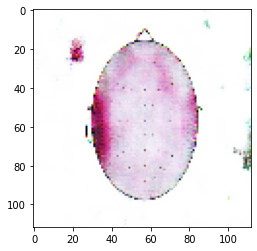

In [60]:
plt.imshow(generated_img[0])